In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2018/PRUEBA B.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 5:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D", "option_E"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D", "E"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]), len(answer_positions["C"]),
                          len(answer_positions["D"]), len(answer_positions["E"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D", "E"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
            else:
                correct_answers.append("DK")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 9 questions
Page 1, Q1 - A: Detected box: x0=82.6, y0=121.5, x1=115.0, y1=133.6
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 173
Page 1, Q1, A: Yellow percentage: 0.0%


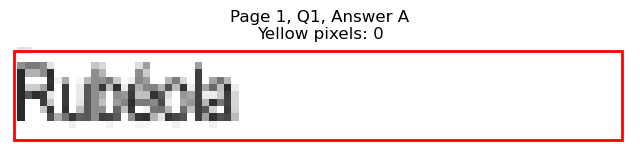

Page 1, Q1 - B: Detected box: x0=71.3, y0=133.5, x1=120.2, y1=145.6
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 256
Page 1, Q1, B: Yellow percentage: 0.0%


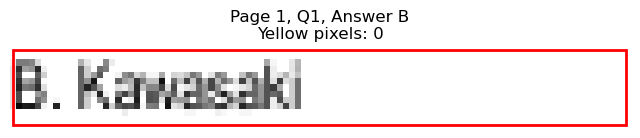

Page 1, Q1 - C: Detected box: x0=71.3, y0=145.6, x1=180.4, y1=157.6
Page 1, Q1, C: Yellow pixels: 847
Page 1, Q1, C: Total non-white pixels: 1391
Page 1, Q1, C: Yellow percentage: 60.9%


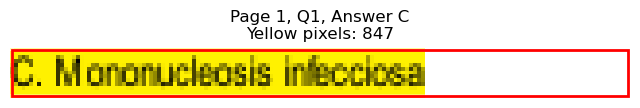

Page 1, Q1 - D: Detected box: x0=322.9, y0=121.5, x1=377.0, y1=133.6
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 269
Page 1, Q1, D: Yellow percentage: 0.0%


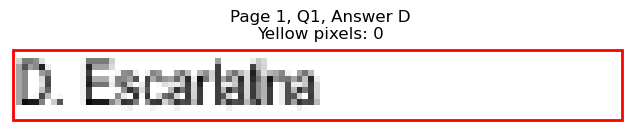

Page 1, Q1 - E: Detected box: x0=322.9, y0=133.5, x1=404.0, y1=145.6
Page 1, Q1, E: Yellow pixels: 0
Page 1, Q1, E: Total non-white pixels: 395
Page 1, Q1, E: Yellow percentage: 0.0%


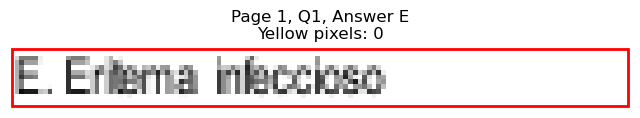


Page 1, Q1 - Selected Answer: C (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=82.6, y0=217.6, x1=136.0, y1=229.7
Page 1, Q2, A: Yellow pixels: 0
Page 1, Q2, A: Total non-white pixels: 473
Page 1, Q2, A: Yellow percentage: 0.0%


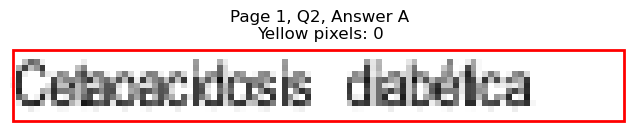

Page 1, Q2 - B: Detected box: x0=71.3, y0=229.6, x1=126.2, y1=241.7
Page 1, Q2, B: Yellow pixels: 0
Page 1, Q2, B: Total non-white pixels: 420
Page 1, Q2, B: Yellow percentage: 0.0%


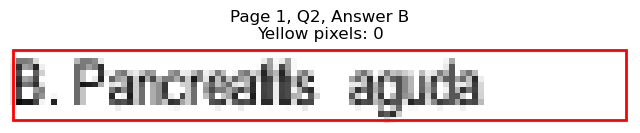

Page 1, Q2 - C: Detected box: x0=71.3, y0=241.6, x1=127.7, y1=253.7
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 491
Page 1, Q2, C: Yellow percentage: 0.0%


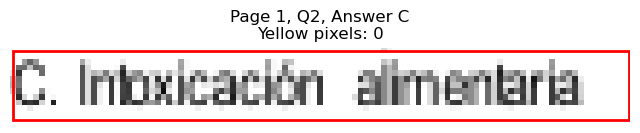

Page 1, Q2 - D: Detected box: x0=322.9, y0=217.6, x1=385.4, y1=229.7
Page 1, Q2, D: Yellow pixels: 485
Page 1, Q2, D: Total non-white pixels: 793
Page 1, Q2, D: Yellow percentage: 61.2%


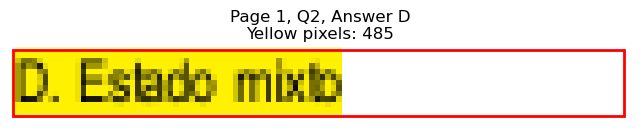

Page 1, Q2 - E: Detected box: x0=322.9, y0=229.6, x1=413.0, y1=241.7
Page 1, Q2, E: Yellow pixels: 60
Page 1, Q2, E: Total non-white pixels: 493
Page 1, Q2, E: Yellow percentage: 12.2%


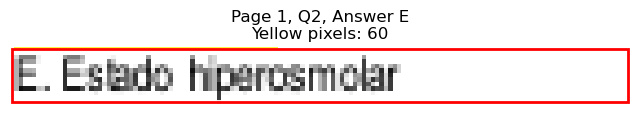


Page 1, Q2 - Selected Answer: D (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=138.8, y0=289.7, x1=192.3, y1=301.8
Page 1, Q3, A: Yellow pixels: 0
Page 1, Q3, A: Total non-white pixels: 281
Page 1, Q3, A: Yellow percentage: 0.0%


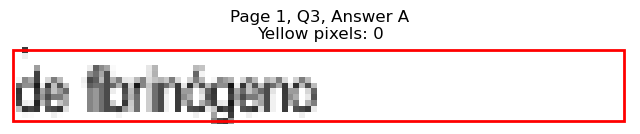

Page 1, Q3 - B: Detected box: x0=71.3, y0=302.5, x1=157.8, y1=314.5
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 421
Page 1, Q3, B: Yellow percentage: 0.0%


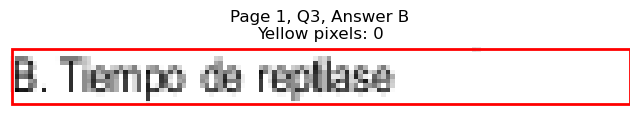

Page 1, Q3 - C: Detected box: x0=71.3, y0=314.5, x1=180.2, y1=326.5
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 785
Page 1, Q3, C: Yellow percentage: 0.0%


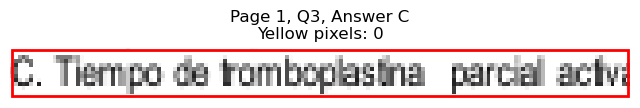

Page 1, Q3 - D: Detected box: x0=322.9, y0=289.7, x1=410.8, y1=301.8
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 415
Page 1, Q3, D: Yellow percentage: 0.0%


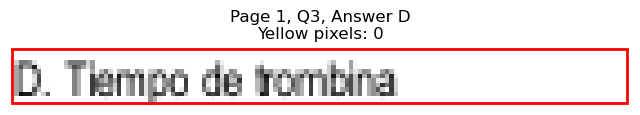

Page 1, Q3 - E: Detected box: x0=322.9, y0=302.5, x1=447.7, y1=314.5
Page 1, Q3, E: Yellow pixels: 1067
Page 1, Q3, E: Total non-white pixels: 1612
Page 1, Q3, E: Yellow percentage: 66.2%


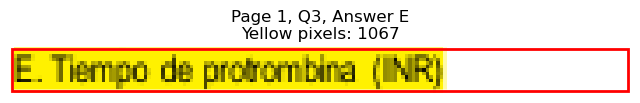


Page 1, Q3 - Selected Answer: E (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=82.6, y0=350.5, x1=217.2, y1=362.5
Page 1, Q4, A: Yellow pixels: 1194
Page 1, Q4, A: Total non-white pixels: 1731
Page 1, Q4, A: Yellow percentage: 69.0%


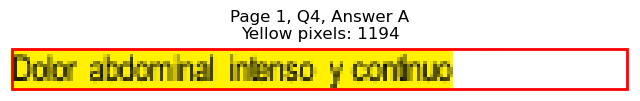

Page 1, Q4 - B: Detected box: x0=71.3, y0=362.5, x1=136.0, y1=374.6
Page 1, Q4, B: Yellow pixels: 103
Page 1, Q4, B: Total non-white pixels: 401
Page 1, Q4, B: Yellow percentage: 25.7%


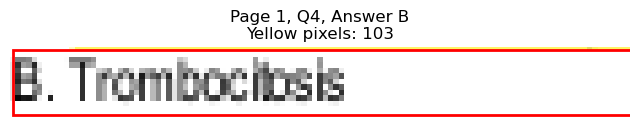

Page 1, Q4 - C: Detected box: x0=71.3, y0=374.5, x1=164.5, y1=386.6
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 463
Page 1, Q4, C: Yellow percentage: 0.0%


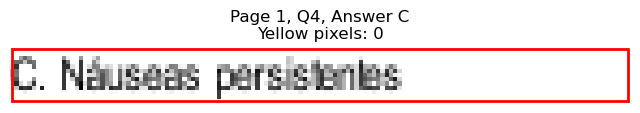

Page 1, Q4 - D: Detected box: x0=322.9, y0=350.5, x1=363.5, y1=362.5
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 195
Page 1, Q4, D: Yellow percentage: 0.0%


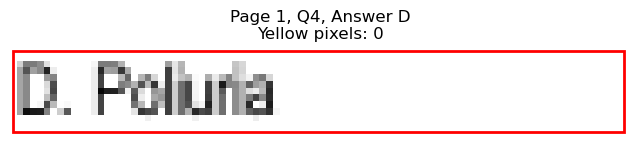

Page 1, Q4 - E: Detected box: x0=322.9, y0=362.5, x1=359.0, y1=374.6
Page 1, Q4, E: Yellow pixels: 0
Page 1, Q4, E: Total non-white pixels: 169
Page 1, Q4, E: Yellow percentage: 0.0%


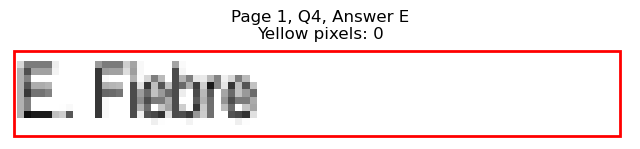


Page 1, Q4 - Selected Answer: A (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=82.6, y0=410.5, x1=131.5, y1=422.6
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 255
Page 1, Q5, A: Yellow percentage: 0.0%


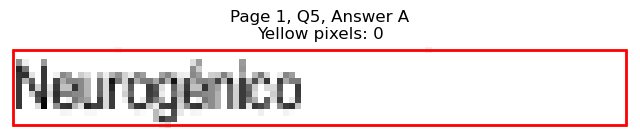

Page 1, Q5 - B: Detected box: x0=71.3, y0=422.5, x1=133.7, y1=434.6
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 314
Page 1, Q5, B: Yellow percentage: 0.0%


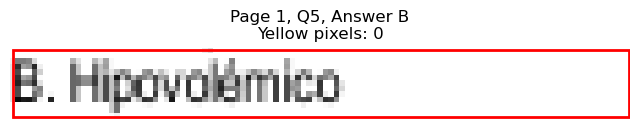

Page 1, Q5 - C: Detected box: x0=71.3, y0=434.6, x1=124.0, y1=446.6
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 251
Page 1, Q5, C: Yellow percentage: 0.0%


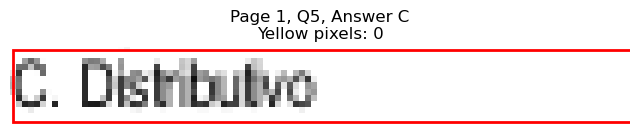

Page 1, Q5 - D: Detected box: x0=322.9, y0=410.5, x1=377.9, y1=422.6
Page 1, Q5, D: Yellow pixels: 418
Page 1, Q5, D: Total non-white pixels: 702
Page 1, Q5, D: Yellow percentage: 59.5%


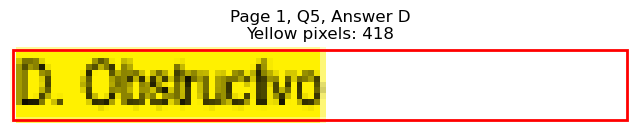

Page 1, Q5 - E: Detected box: x0=322.9, y0=422.5, x1=383.9, y1=434.6
Page 1, Q5, E: Yellow pixels: 52
Page 1, Q5, E: Total non-white pixels: 362
Page 1, Q5, E: Yellow percentage: 14.4%


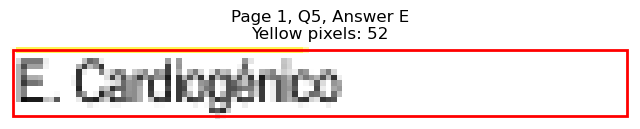


Page 1, Q5 - Selected Answer: D (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=82.6, y0=483.4, x1=112.0, y1=495.4
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 150
Page 1, Q6, A: Yellow percentage: 0.0%


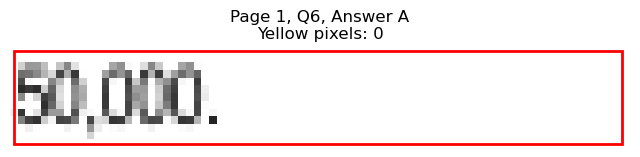

Page 1, Q6 - B: Detected box: x0=71.3, y0=495.4, x1=111.2, y1=507.4
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 181
Page 1, Q6, B: Yellow percentage: 0.0%


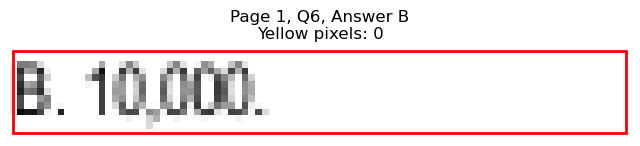

Page 1, Q6 - C: Detected box: x0=71.3, y0=507.4, x1=116.5, y1=519.4
Page 1, Q6, C: Yellow pixels: 0
Page 1, Q6, C: Total non-white pixels: 197
Page 1, Q6, C: Yellow percentage: 0.0%


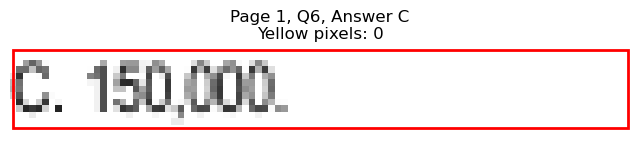

Page 1, Q6 - D: Detected box: x0=322.9, y0=483.4, x1=359.0, y1=495.4
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 155
Page 1, Q6, D: Yellow percentage: 0.0%


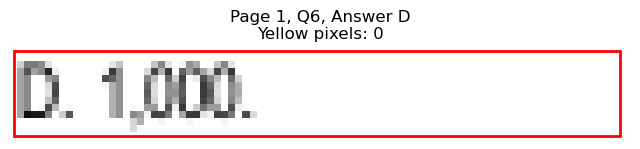

Page 1, Q6 - E: Detected box: x0=322.9, y0=495.4, x1=367.3, y1=507.4
Page 1, Q6, E: Yellow pixels: 379
Page 1, Q6, E: Total non-white pixels: 559
Page 1, Q6, E: Yellow percentage: 67.8%


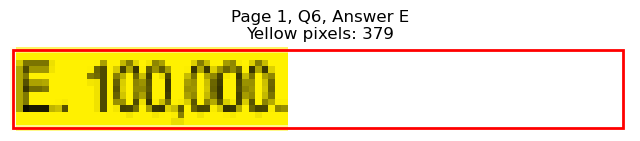


Page 1, Q6 - Selected Answer: E (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=82.6, y0=555.4, x1=115.0, y1=567.5
Page 1, Q7, A: Yellow pixels: 0
Page 1, Q7, A: Total non-white pixels: 173
Page 1, Q7, A: Yellow percentage: 0.0%


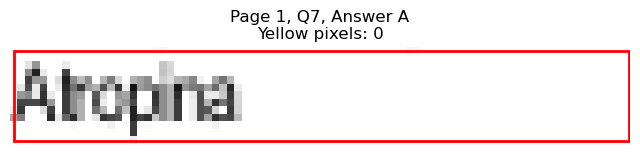

Page 1, Q7 - B: Detected box: x0=71.3, y0=567.5, x1=121.7, y1=579.5
Page 1, Q7, B: Yellow pixels: 0
Page 1, Q7, B: Total non-white pixels: 248
Page 1, Q7, B: Yellow percentage: 0.0%


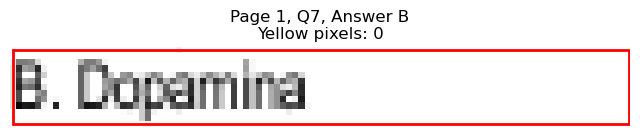

Page 1, Q7 - C: Detected box: x0=71.3, y0=579.4, x1=124.0, y1=591.5
Page 1, Q7, C: Yellow pixels: 457
Page 1, Q7, C: Total non-white pixels: 663
Page 1, Q7, C: Yellow percentage: 68.9%


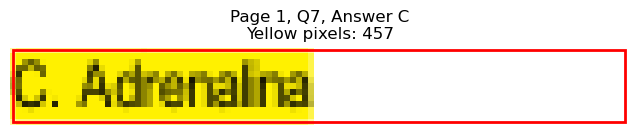

Page 1, Q7 - D: Detected box: x0=322.9, y0=555.4, x1=416.0, y1=567.5
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 455
Page 1, Q7, D: Yellow percentage: 0.0%


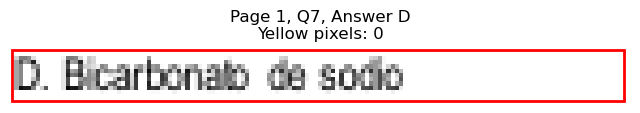

Page 1, Q7 - E: Detected box: x0=322.9, y0=567.5, x1=372.5, y1=579.5
Page 1, Q7, E: Yellow pixels: 0
Page 1, Q7, E: Total non-white pixels: 412
Page 1, Q7, E: Yellow percentage: 0.0%


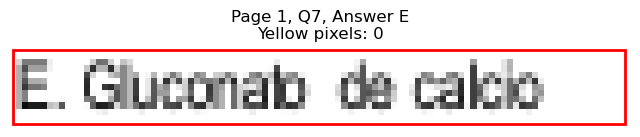


Page 1, Q7 - Selected Answer: C (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=108.8, y0=627.5, x1=148.8, y1=639.6
Page 1, Q8, A: Yellow pixels: 342
Page 1, Q8, A: Total non-white pixels: 509
Page 1, Q8, A: Yellow percentage: 67.2%


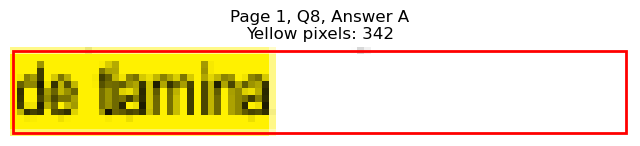

Page 1, Q8 - B: Detected box: x0=71.3, y0=639.5, x1=149.5, y1=651.6
Page 1, Q8, B: Yellow pixels: 63
Page 1, Q8, B: Total non-white pixels: 487
Page 1, Q8, B: Yellow percentage: 12.9%


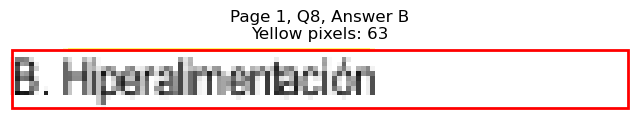

Page 1, Q8 - C: Detected box: x0=71.3, y0=651.5, x1=133.0, y1=663.6
Page 1, Q8, C: Yellow pixels: 0
Page 1, Q8, C: Total non-white pixels: 294
Page 1, Q8, C: Yellow percentage: 0.0%


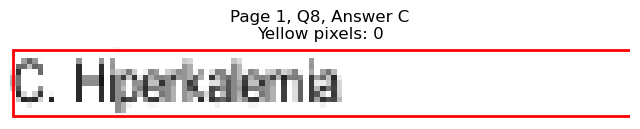

Page 1, Q8 - D: Detected box: x0=322.9, y0=627.5, x1=384.5, y1=639.6
Page 1, Q8, D: Yellow pixels: 0
Page 1, Q8, D: Total non-white pixels: 323
Page 1, Q8, D: Yellow percentage: 0.0%


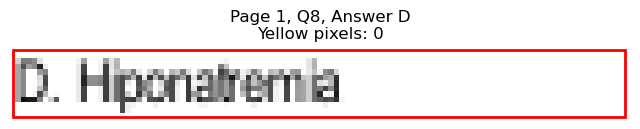

Page 1, Q8 - E: Detected box: x0=359.6, y0=639.5, x1=414.5, y1=651.6
Page 1, Q8, E: Yellow pixels: 0
Page 1, Q8, E: Total non-white pixels: 261
Page 1, Q8, E: Yellow percentage: 0.0%


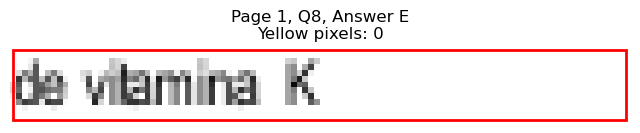


Page 1, Q8 - Selected Answer: A (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=82.6, y0=700.3, x1=134.5, y1=712.3
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 263
Page 1, Q9, A: Yellow percentage: 0.0%


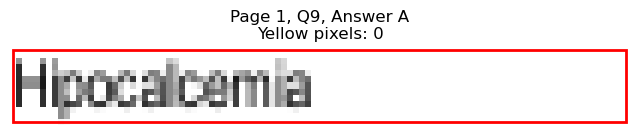

Page 1, Q9 - B: Detected box: x0=71.3, y0=712.3, x1=129.3, y1=724.4
Page 1, Q9, B: Yellow pixels: 418
Page 1, Q9, B: Total non-white pixels: 728
Page 1, Q9, B: Yellow percentage: 57.4%


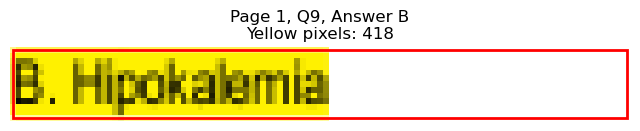

Page 1, Q9 - C: Detected box: x0=71.3, y0=724.3, x1=137.5, y1=736.4
Page 1, Q9, C: Yellow pixels: 1
Page 1, Q9, C: Total non-white pixels: 372
Page 1, Q9, C: Yellow percentage: 0.3%


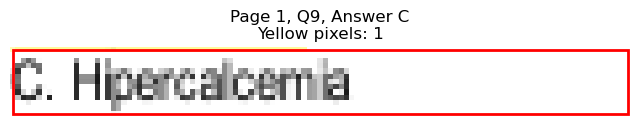

Page 1, Q9 - D: Detected box: x0=322.9, y0=700.3, x1=384.5, y1=712.3
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 330
Page 1, Q9, D: Yellow percentage: 0.0%


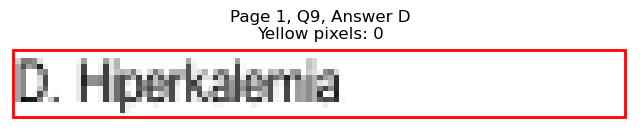

Page 1, Q9 - E: Detected box: x0=322.9, y0=712.3, x1=381.7, y1=724.4
Page 1, Q9, E: Yellow pixels: 0
Page 1, Q9, E: Total non-white pixels: 299
Page 1, Q9, E: Yellow percentage: 0.0%


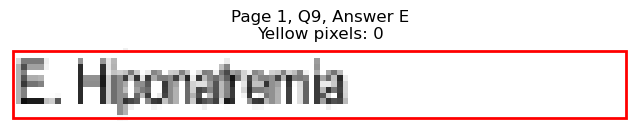


Page 1, Q9 - Selected Answer: B (based on yellow pixel count)





Page 2: Found 10 questions
Page 2, Q1 - A: Detected box: x0=82.6, y0=109.5, x1=150.3, y1=121.6
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 340
Page 2, Q1, A: Yellow percentage: 0.0%


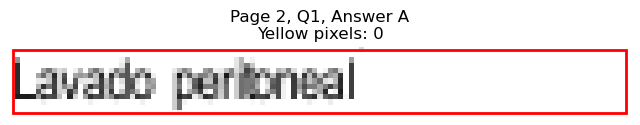

Page 2, Q1 - B: Detected box: x0=71.3, y0=121.5, x1=170.6, y1=133.6
Page 2, Q1, B: Yellow pixels: 900
Page 2, Q1, B: Total non-white pixels: 1274
Page 2, Q1, B: Yellow percentage: 70.6%


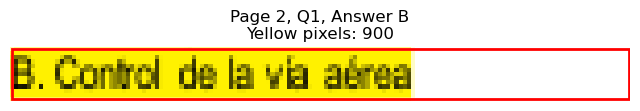

Page 2, Q1 - C: Detected box: x0=71.3, y0=133.5, x1=170.5, y1=145.6
Page 2, Q1, C: Yellow pixels: 97
Page 2, Q1, C: Total non-white pixels: 580
Page 2, Q1, C: Yellow percentage: 16.7%


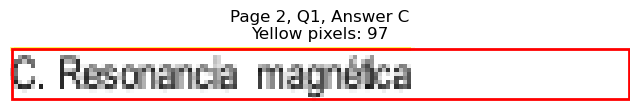

Page 2, Q1 - D: Detected box: x0=322.9, y0=109.5, x1=431.0, y1=121.6
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 508
Page 2, Q1, D: Yellow percentage: 0.0%


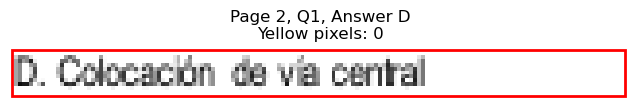

Page 2, Q1 - E: Detected box: x0=380.6, y0=121.5, x1=456.5, y1=133.6
Page 2, Q1, E: Yellow pixels: 0
Page 2, Q1, E: Total non-white pixels: 389
Page 2, Q1, E: Yellow percentage: 0.0%


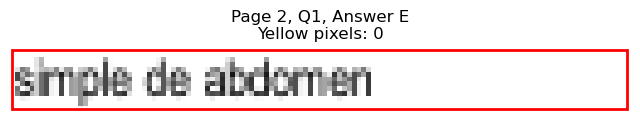


Page 2, Q1 - Selected Answer: B (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=82.6, y0=169.6, x1=154.0, y1=181.6
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 325
Page 2, Q2, A: Yellow percentage: 0.0%


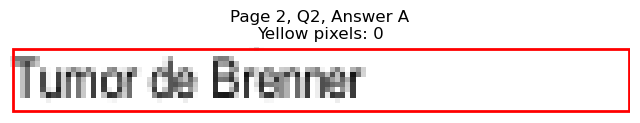

Page 2, Q2 - B: Detected box: x0=71.3, y0=181.6, x1=157.8, y1=193.6
Page 2, Q2, B: Yellow pixels: 694
Page 2, Q2, B: Total non-white pixels: 1105
Page 2, Q2, B: Yellow percentage: 62.8%


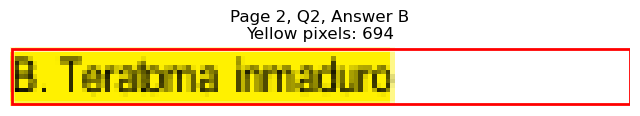

Page 2, Q2 - C: Detected box: x0=71.3, y0=193.6, x1=152.5, y1=205.6
Page 2, Q2, C: Yellow pixels: 84
Page 2, Q2, C: Total non-white pixels: 456
Page 2, Q2, C: Yellow percentage: 18.4%


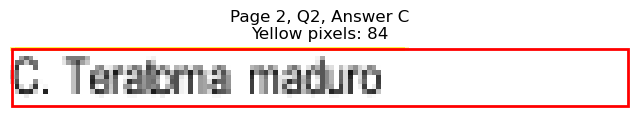

Page 2, Q2 - D: Detected box: x0=322.9, y0=169.6, x1=390.5, y1=181.6
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 336
Page 2, Q2, D: Yellow percentage: 0.0%


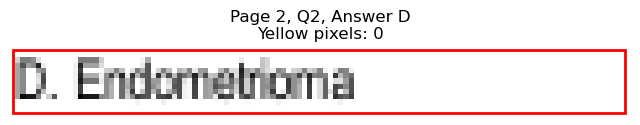

Page 2, Q2 - E: Detected box: x0=322.9, y0=181.6, x1=388.3, y1=193.6
Page 2, Q2, E: Yellow pixels: 0
Page 2, Q2, E: Total non-white pixels: 325
Page 2, Q2, E: Yellow percentage: 0.0%


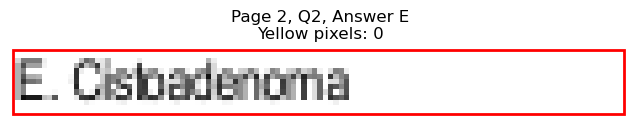


Page 2, Q2 - Selected Answer: B (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=82.6, y0=229.6, x1=103.0, y1=241.7
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 106
Page 2, Q3, A: Yellow percentage: 0.0%


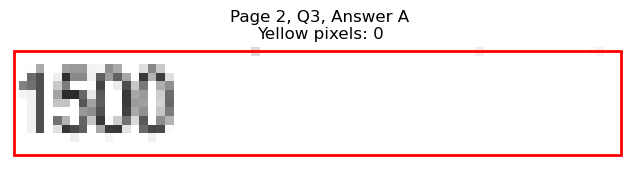

Page 2, Q3 - B: Detected box: x0=71.3, y0=241.6, x1=102.2, y1=253.7
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 156
Page 2, Q3, B: Yellow percentage: 0.0%


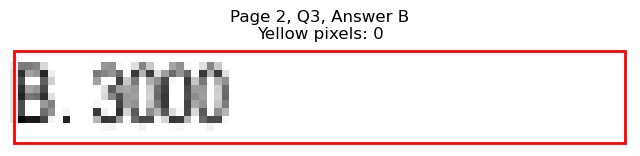

Page 2, Q3 - C: Detected box: x0=71.3, y0=253.6, x1=103.0, y1=265.7
Page 2, Q3, C: Yellow pixels: 0
Page 2, Q3, C: Total non-white pixels: 142
Page 2, Q3, C: Yellow percentage: 0.0%


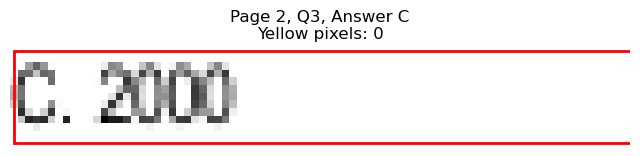

Page 2, Q3 - D: Detected box: x0=322.9, y0=229.6, x1=354.6, y1=241.7
Page 2, Q3, D: Yellow pixels: 222
Page 2, Q3, D: Total non-white pixels: 403
Page 2, Q3, D: Yellow percentage: 55.1%


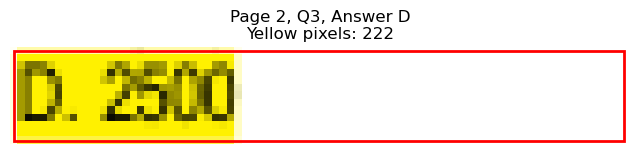

Page 2, Q3 - E: Detected box: x0=322.9, y0=241.6, x1=353.8, y1=253.7
Page 2, Q3, E: Yellow pixels: 29
Page 2, Q3, E: Total non-white pixels: 173
Page 2, Q3, E: Yellow percentage: 16.8%


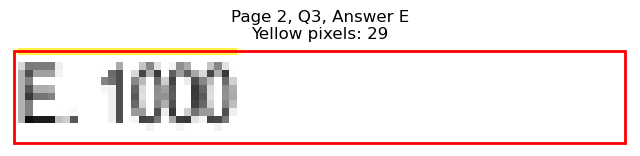


Page 2, Q3 - Selected Answer: D (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=82.6, y0=302.5, x1=158.6, y1=314.5
Page 2, Q4, A: Yellow pixels: 616
Page 2, Q4, A: Total non-white pixels: 977
Page 2, Q4, A: Yellow percentage: 63.1%


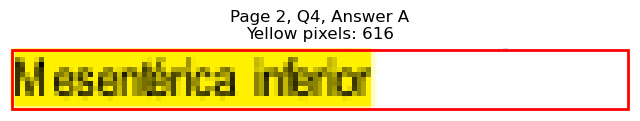

Page 2, Q4 - B: Detected box: x0=71.3, y0=314.5, x1=140.5, y1=326.5
Page 2, Q4, B: Yellow pixels: 73
Page 2, Q4, B: Total non-white pixels: 416
Page 2, Q4, B: Yellow percentage: 17.5%


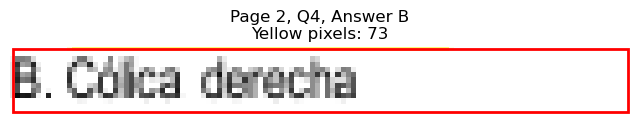

Page 2, Q4 - C: Detected box: x0=71.3, y0=326.5, x1=163.7, y1=338.5
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 445
Page 2, Q4, C: Yellow percentage: 0.0%


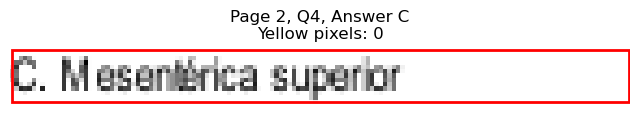

Page 2, Q4 - D: Detected box: x0=322.9, y0=302.5, x1=386.8, y1=314.5
Page 2, Q4, D: Yellow pixels: 0
Page 2, Q4, D: Total non-white pixels: 305
Page 2, Q4, D: Yellow percentage: 0.0%


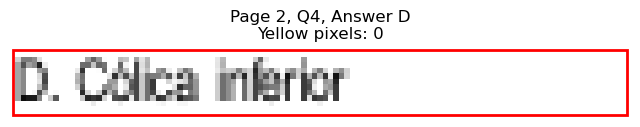

Page 2, Q4 - E: Detected box: x0=322.9, y0=314.5, x1=392.0, y1=326.5
Page 2, Q4, E: Yellow pixels: 0
Page 2, Q4, E: Total non-white pixels: 327
Page 2, Q4, E: Yellow percentage: 0.0%


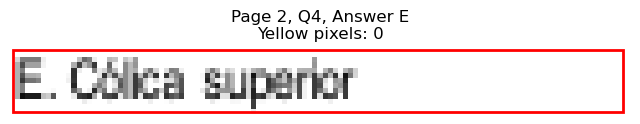


Page 2, Q4 - Selected Answer: A (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=82.6, y0=374.5, x1=190.0, y1=386.6
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 527
Page 2, Q5, A: Yellow percentage: 0.0%


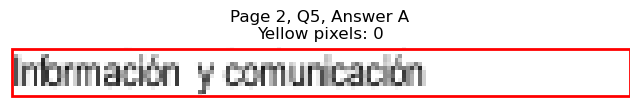

Page 2, Q5 - B: Detected box: x0=71.3, y0=386.5, x1=167.6, y1=398.6
Page 2, Q5, B: Yellow pixels: 747
Page 2, Q5, B: Total non-white pixels: 1235
Page 2, Q5, B: Yellow percentage: 60.5%


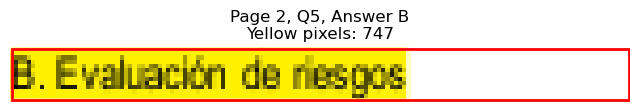

Page 2, Q5 - C: Detected box: x0=71.3, y0=398.5, x1=159.2, y1=410.6
Page 2, Q5, C: Yellow pixels: 94
Page 2, Q5, C: Total non-white pixels: 491
Page 2, Q5, C: Yellow percentage: 19.1%


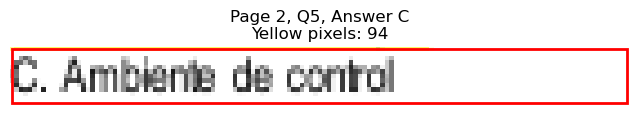

Page 2, Q5 - D: Detected box: x0=322.9, y0=374.5, x1=419.1, y1=386.6
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 468
Page 2, Q5, D: Yellow percentage: 0.0%


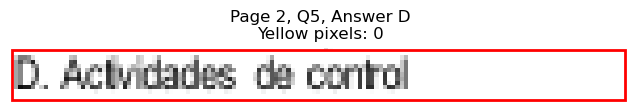

Page 2, Q5 - E: Detected box: x0=322.9, y0=386.5, x1=379.3, y1=398.6
Page 2, Q5, E: Yellow pixels: 0
Page 2, Q5, E: Total non-white pixels: 282
Page 2, Q5, E: Yellow percentage: 0.0%


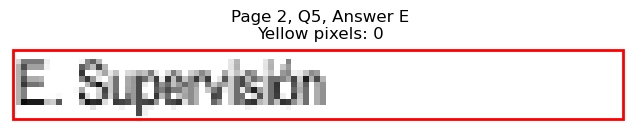


Page 2, Q5 - Selected Answer: B (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=82.6, y0=458.6, x1=172.1, y1=470.6
Page 2, Q6, A: Yellow pixels: 669
Page 2, Q6, A: Total non-white pixels: 1144
Page 2, Q6, A: Yellow percentage: 58.5%


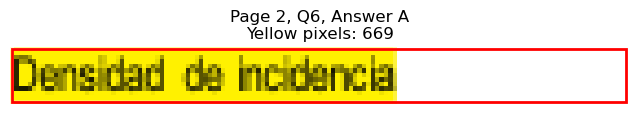

Page 2, Q6 - B: Detected box: x0=71.3, y0=470.6, x1=166.0, y1=482.6
Page 2, Q6, B: Yellow pixels: 87
Page 2, Q6, B: Total non-white pixels: 561
Page 2, Q6, B: Yellow percentage: 15.5%


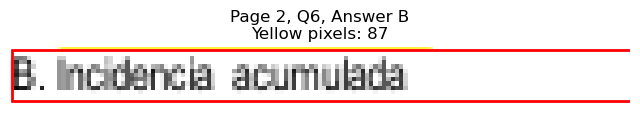

Page 2, Q6 - C: Detected box: x0=71.3, y0=483.4, x1=157.7, y1=495.4
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 414
Page 2, Q6, C: Yellow percentage: 0.0%


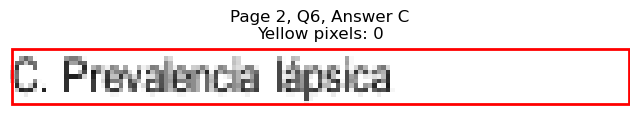

Page 2, Q6 - D: Detected box: x0=322.9, y0=458.6, x1=409.3, y1=470.6
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 424
Page 2, Q6, D: Yellow percentage: 0.0%


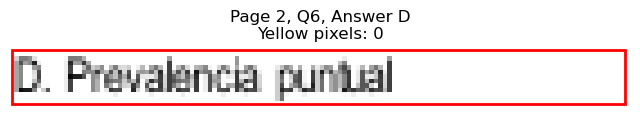

Page 2, Q6 - E: Detected box: x0=322.9, y0=470.6, x1=396.5, y1=482.6
Page 2, Q6, E: Yellow pixels: 0
Page 2, Q6, E: Total non-white pixels: 380
Page 2, Q6, E: Yellow percentage: 0.0%


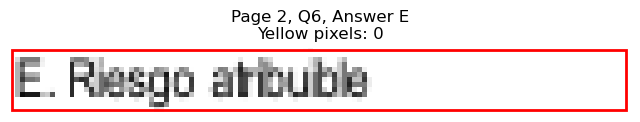


Page 2, Q6 - Selected Answer: A (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=82.6, y0=519.4, x1=157.0, y1=531.4
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 381
Page 2, Q7, A: Yellow percentage: 0.0%


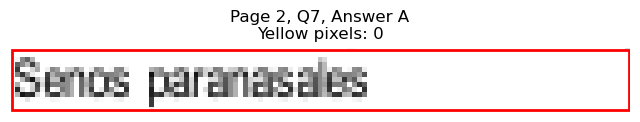

Page 2, Q7 - B: Detected box: x0=71.3, y0=531.4, x1=137.5, y1=543.5
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 311
Page 2, Q7, B: Yellow percentage: 0.0%


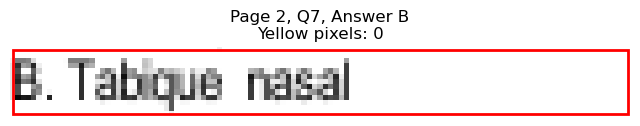

Page 2, Q7 - C: Detected box: x0=71.3, y0=543.4, x1=123.2, y1=555.5
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 244
Page 2, Q7, C: Yellow percentage: 0.0%


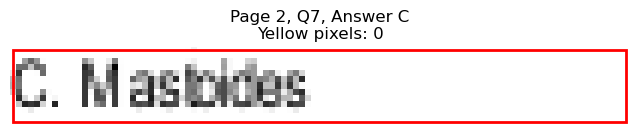

Page 2, Q7 - D: Detected box: x0=322.9, y0=519.4, x1=363.6, y1=531.4
Page 2, Q7, D: Yellow pixels: 347
Page 2, Q7, D: Total non-white pixels: 522
Page 2, Q7, D: Yellow percentage: 66.5%


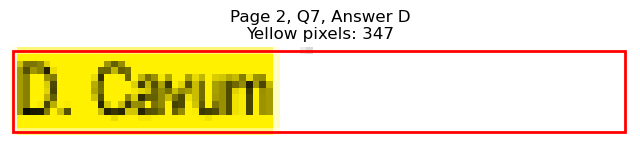

Page 2, Q7 - E: Detected box: x0=322.9, y0=531.4, x1=380.8, y1=543.5
Page 2, Q7, E: Yellow pixels: 38
Page 2, Q7, E: Total non-white pixels: 310
Page 2, Q7, E: Yellow percentage: 12.3%


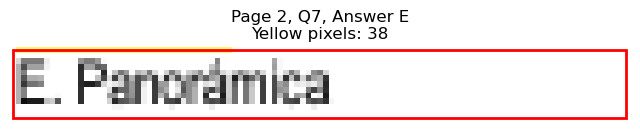


Page 2, Q7 - Selected Answer: D (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=82.6, y0=579.4, x1=154.8, y1=591.5
Page 2, Q8, A: Yellow pixels: 617
Page 2, Q8, A: Total non-white pixels: 923
Page 2, Q8, A: Yellow percentage: 66.8%


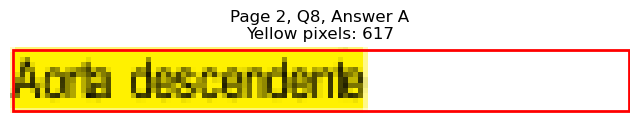

Page 2, Q8 - B: Detected box: x0=71.3, y0=591.5, x1=136.0, y1=603.5
Page 2, Q8, B: Yellow pixels: 69
Page 2, Q8, B: Total non-white pixels: 386
Page 2, Q8, B: Yellow percentage: 17.9%


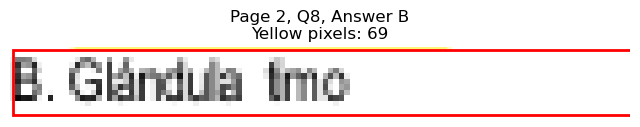

Page 2, Q8 - C: Detected box: x0=71.3, y0=603.5, x1=172.7, y1=615.5
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 463
Page 2, Q8, C: Yellow percentage: 0.0%


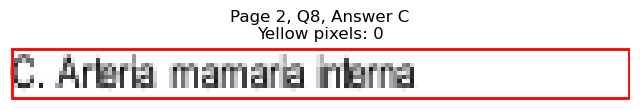

Page 2, Q8 - D: Detected box: x0=322.9, y0=579.4, x1=387.5, y1=591.5
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 306
Page 2, Q8, D: Yellow percentage: 0.0%


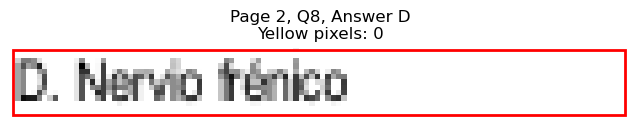

Page 2, Q8 - E: Detected box: x0=322.9, y0=591.5, x1=366.5, y1=603.5
Page 2, Q8, E: Yellow pixels: 0
Page 2, Q8, E: Total non-white pixels: 209
Page 2, Q8, E: Yellow percentage: 0.0%


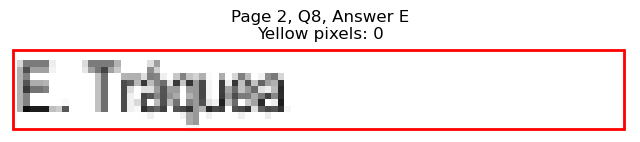


Page 2, Q8 - Selected Answer: A (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=82.6, y0=651.5, x1=221.5, y1=663.6
Page 2, Q9, A: Yellow pixels: 0
Page 2, Q9, A: Total non-white pixels: 655
Page 2, Q9, A: Yellow percentage: 0.0%


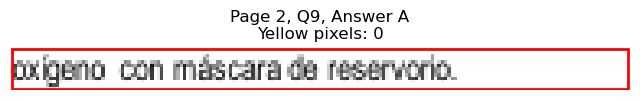

Page 2, Q9 - B: Detected box: x0=71.3, y0=663.5, x1=187.7, y1=675.6
Page 2, Q9, B: Yellow pixels: 0
Page 2, Q9, B: Total non-white pixels: 555
Page 2, Q9, B: Yellow percentage: 0.0%


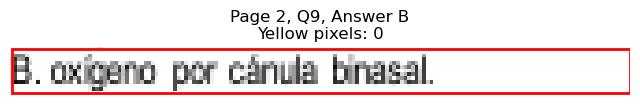

Page 2, Q9 - C: Detected box: x0=71.3, y0=676.3, x1=210.9, y1=688.3
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 653
Page 2, Q9, C: Yellow percentage: 0.0%


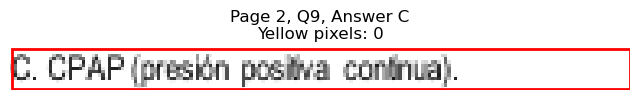

Page 2, Q9 - D: Detected box: x0=375.4, y0=651.5, x1=426.6, y1=663.6
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 272
Page 2, Q9, D: Yellow percentage: 0.0%


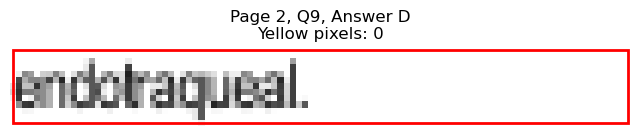

Page 2, Q9 - E: Detected box: x0=408.5, y0=663.5, x1=492.0, y1=675.6
Page 2, Q9, E: Yellow pixels: 682
Page 2, Q9, E: Total non-white pixels: 1066
Page 2, Q9, E: Yellow percentage: 64.0%


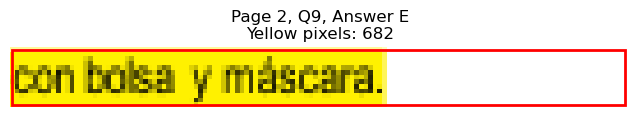


Page 2, Q9 - Selected Answer: E (based on yellow pixel count)




Page 2, Q10 - A: Detected box: x0=126.8, y0=736.4, x1=181.7, y1=748.4
Page 2, Q10, A: Yellow pixels: 0
Page 2, Q10, A: Total non-white pixels: 265
Page 2, Q10, A: Yellow percentage: 0.0%


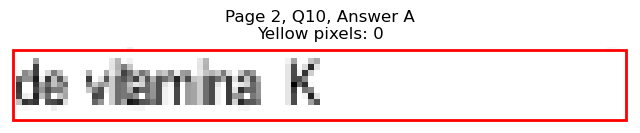

Page 2, Q10 - B: Detected box: x0=71.3, y0=748.4, x1=117.2, y1=760.4
Page 2, Q10, B: Yellow pixels: 493
Page 2, Q10, B: Total non-white pixels: 728
Page 2, Q10, B: Yellow percentage: 67.7%


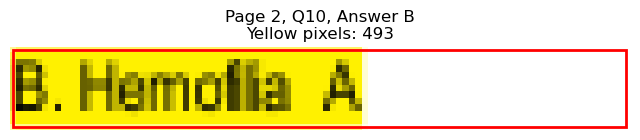

Page 2, Q10 - C: Detected box: x0=71.3, y0=760.4, x1=118.0, y1=772.4
Page 2, Q10, C: Yellow pixels: 54
Page 2, Q10, C: Total non-white pixels: 301
Page 2, Q10, C: Yellow percentage: 17.9%


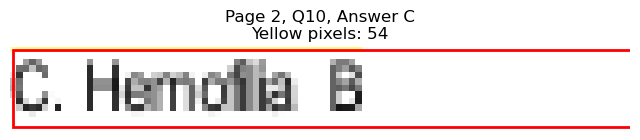

Page 2, Q10 - D: Detected box: x0=322.9, y0=736.4, x1=437.0, y1=748.4
Page 2, Q10, D: Yellow pixels: 0
Page 2, Q10, D: Total non-white pixels: 555
Page 2, Q10, D: Yellow percentage: 0.0%


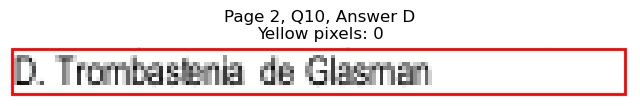

Page 2, Q10 - E: Detected box: x0=322.9, y0=748.4, x1=450.7, y1=760.4
Page 2, Q10, E: Yellow pixels: 0
Page 2, Q10, E: Total non-white pixels: 644
Page 2, Q10, E: Yellow percentage: 0.0%


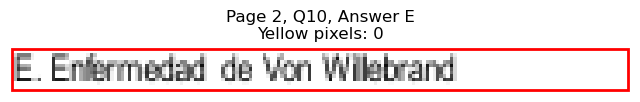


Page 2, Q10 - Selected Answer: B (based on yellow pixel count)





Page 3: Found 9 questions
Page 3, Q1 - A: Detected box: x0=82.6, y0=109.5, x1=120.3, y1=121.6
Page 3, Q1, A: Yellow pixels: 317
Page 3, Q1, A: Total non-white pixels: 470
Page 3, Q1, A: Yellow percentage: 67.4%


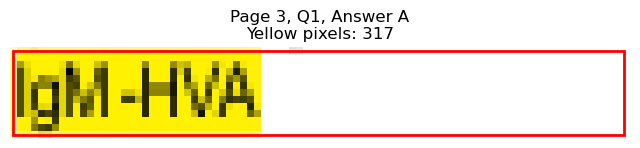

Page 3, Q1 - B: Detected box: x0=71.3, y0=121.5, x1=138.3, y1=133.6
Page 3, Q1, B: Yellow pixels: 35
Page 3, Q1, B: Total non-white pixels: 387
Page 3, Q1, B: Yellow percentage: 9.0%


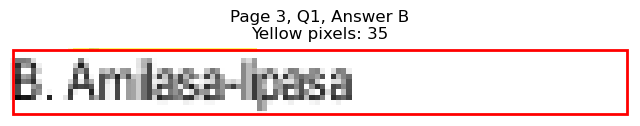

Page 3, Q1 - C: Detected box: x0=71.3, y0=133.5, x1=180.3, y1=145.6
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 534
Page 3, Q1, C: Yellow percentage: 0.0%


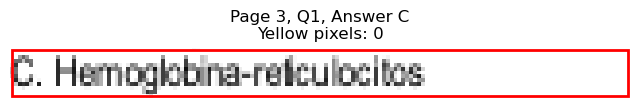

Page 3, Q1 - D: Detected box: x0=322.9, y0=109.5, x1=394.4, y1=121.6
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 346
Page 3, Q1, D: Yellow percentage: 0.0%


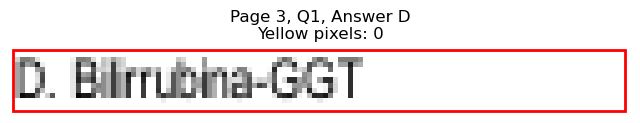

Page 3, Q1 - E: Detected box: x0=322.9, y0=121.5, x1=415.4, y1=133.6
Page 3, Q1, E: Yellow pixels: 0
Page 3, Q1, E: Total non-white pixels: 470
Page 3, Q1, E: Yellow percentage: 0.0%


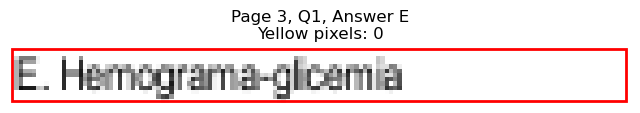


Page 3, Q1 - Selected Answer: A (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=82.6, y0=169.6, x1=145.0, y1=181.6
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 514
Page 3, Q2, A: Yellow percentage: 0.0%


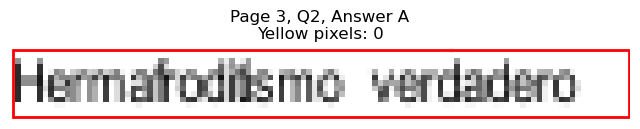

Page 3, Q2 - B: Detected box: x0=71.3, y0=181.6, x1=174.9, y1=193.6
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 501
Page 3, Q2, B: Yellow percentage: 0.0%


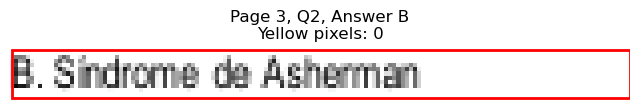

Page 3, Q2 - C: Detected box: x0=71.3, y0=193.6, x1=152.5, y1=205.6
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 403
Page 3, Q2, C: Yellow percentage: 0.0%


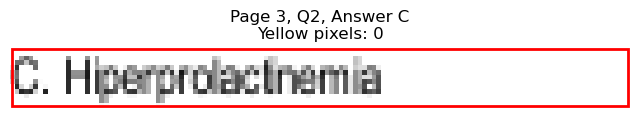

Page 3, Q2 - D: Detected box: x0=322.9, y0=169.6, x1=462.0, y1=181.6
Page 3, Q2, D: Yellow pixels: 1098
Page 3, Q2, D: Total non-white pixels: 1794
Page 3, Q2, D: Yellow percentage: 61.2%


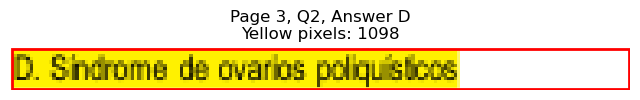

Page 3, Q2 - E: Detected box: x0=382.9, y0=181.6, x1=446.0, y1=193.6
Page 3, Q2, E: Yellow pixels: 78
Page 3, Q2, E: Total non-white pixels: 384
Page 3, Q2, E: Yellow percentage: 20.3%


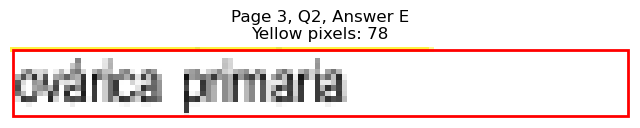


Page 3, Q2 - Selected Answer: D (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=82.6, y0=241.6, x1=128.5, y1=253.7
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 230
Page 3, Q3, A: Yellow percentage: 0.0%


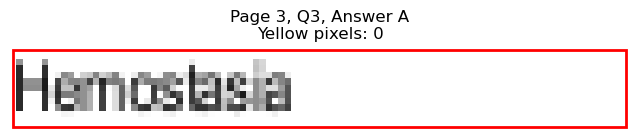

Page 3, Q3 - B: Detected box: x0=71.3, y0=253.6, x1=124.7, y1=265.7
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 282
Page 3, Q3, B: Yellow percentage: 0.0%


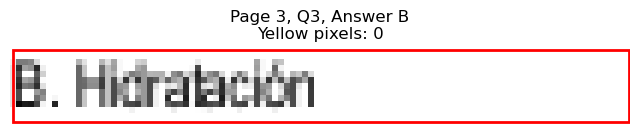

Page 3, Q3 - C: Detected box: x0=71.3, y0=265.7, x1=121.0, y1=277.7
Page 3, Q3, C: Yellow pixels: 395
Page 3, Q3, C: Total non-white pixels: 624
Page 3, Q3, C: Yellow percentage: 63.3%


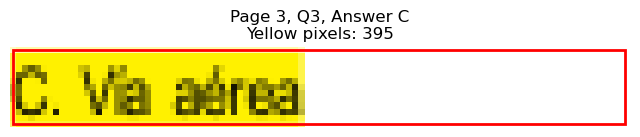

Page 3, Q3 - D: Detected box: x0=322.9, y0=241.6, x1=384.5, y1=253.7
Page 3, Q3, D: Yellow pixels: 0
Page 3, Q3, D: Total non-white pixels: 311
Page 3, Q3, D: Yellow percentage: 0.0%


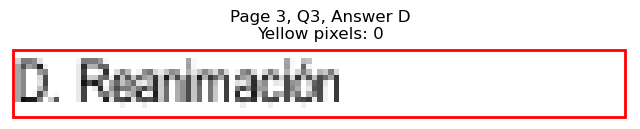

Page 3, Q3 - E: Detected box: x0=322.9, y0=253.6, x1=387.5, y1=265.7
Page 3, Q3, E: Yellow pixels: 0
Page 3, Q3, E: Total non-white pixels: 303
Page 3, Q3, E: Yellow percentage: 0.0%


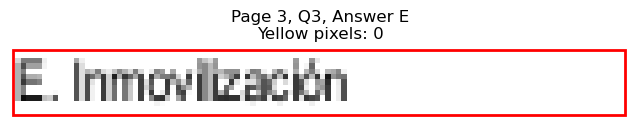


Page 3, Q3 - Selected Answer: C (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=82.6, y0=302.5, x1=106.0, y1=314.5
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 100
Page 3, Q4, A: Yellow percentage: 0.0%


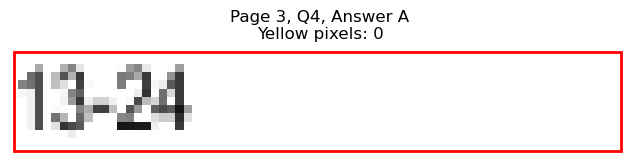

Page 3, Q4 - B: Detected box: x0=71.3, y0=314.5, x1=105.3, y1=326.5
Page 3, Q4, B: Yellow pixels: 289
Page 3, Q4, B: Total non-white pixels: 416
Page 3, Q4, B: Yellow percentage: 69.5%


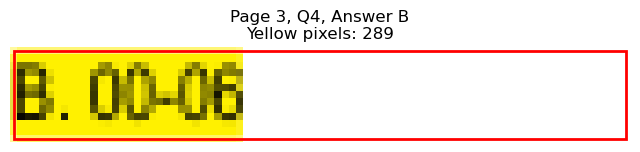

Page 3, Q4 - C: Detected box: x0=71.3, y0=326.5, x1=106.0, y1=338.5
Page 3, Q4, C: Yellow pixels: 32
Page 3, Q4, C: Total non-white pixels: 156
Page 3, Q4, C: Yellow percentage: 20.5%


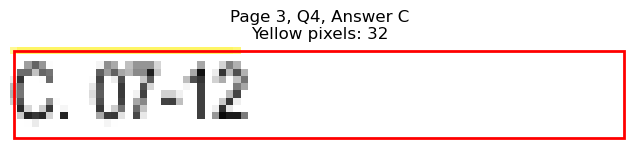

Page 3, Q4 - D: Detected box: x0=322.9, y0=302.5, x1=357.6, y1=314.5
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 161
Page 3, Q4, D: Yellow percentage: 0.0%


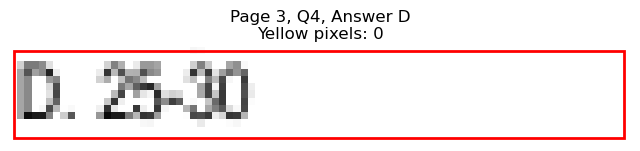

Page 3, Q4 - E: Detected box: x0=322.9, y0=314.5, x1=356.8, y1=326.5
Page 3, Q4, E: Yellow pixels: 0
Page 3, Q4, E: Total non-white pixels: 151
Page 3, Q4, E: Yellow percentage: 0.0%


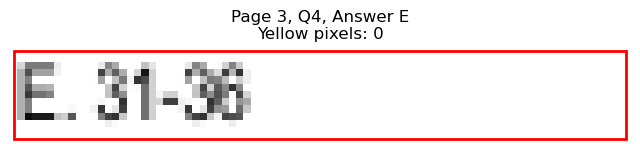


Page 3, Q4 - Selected Answer: B (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=82.6, y0=398.5, x1=127.0, y1=410.6
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 227
Page 3, Q5, A: Yellow percentage: 0.0%


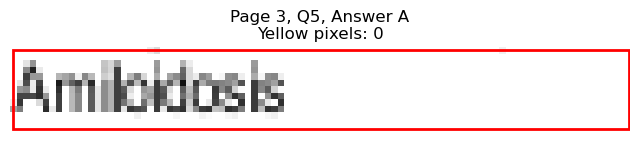

Page 3, Q5 - B: Detected box: x0=71.3, y0=410.5, x1=121.0, y1=422.6
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 502
Page 3, Q5, B: Yellow percentage: 0.0%


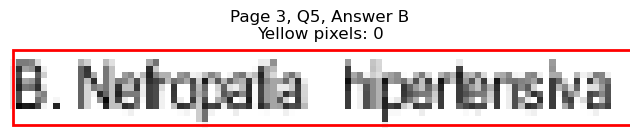

Page 3, Q5 - C: Detected box: x0=71.3, y0=422.5, x1=121.0, y1=434.6
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 447
Page 3, Q5, C: Yellow percentage: 0.0%


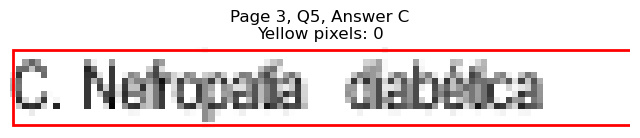

Page 3, Q5 - D: Detected box: x0=322.9, y0=398.5, x1=372.5, y1=410.6
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 435
Page 3, Q5, D: Yellow percentage: 0.0%


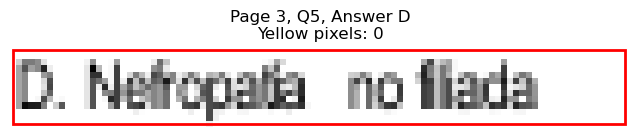

Page 3, Q5 - E: Detected box: x0=322.9, y0=410.5, x1=372.5, y1=422.6
Page 3, Q5, E: Yellow pixels: 572
Page 3, Q5, E: Total non-white pixels: 988
Page 3, Q5, E: Yellow percentage: 57.9%


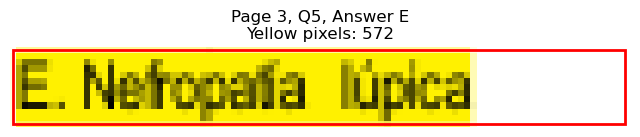


Page 3, Q5 - Selected Answer: E (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=82.6, y0=483.4, x1=136.0, y1=495.4
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 247
Page 3, Q6, A: Yellow percentage: 0.0%


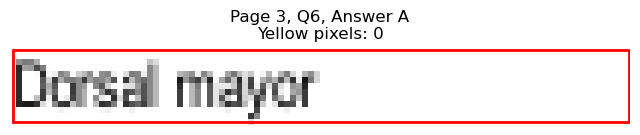

Page 3, Q6 - B: Detected box: x0=71.3, y0=495.4, x1=145.7, y1=507.4
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 347
Page 3, Q6, B: Yellow percentage: 0.0%


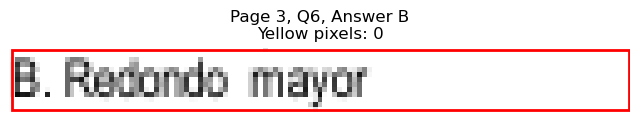

Page 3, Q6 - C: Detected box: x0=71.3, y0=507.4, x1=140.6, y1=519.4
Page 3, Q6, C: Yellow pixels: 592
Page 3, Q6, C: Total non-white pixels: 884
Page 3, Q6, C: Yellow percentage: 67.0%


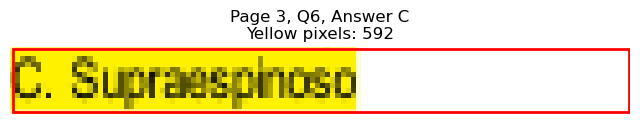

Page 3, Q6 - D: Detected box: x0=322.9, y0=483.4, x1=366.5, y1=495.4
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 203
Page 3, Q6, D: Yellow percentage: 0.0%


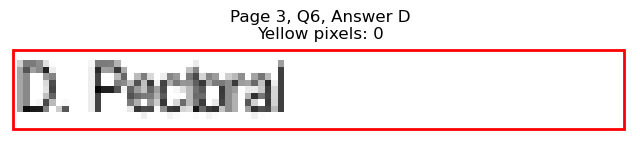

Page 3, Q6 - E: Detected box: x0=322.9, y0=495.4, x1=361.3, y1=507.4
Page 3, Q6, E: Yellow pixels: 0
Page 3, Q6, E: Total non-white pixels: 176
Page 3, Q6, E: Yellow percentage: 0.0%


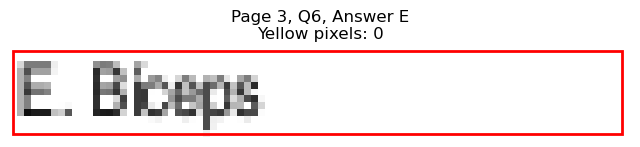


Page 3, Q6 - Selected Answer: C (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=82.6, y0=555.4, x1=113.5, y1=567.5
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 141
Page 3, Q7, A: Yellow percentage: 0.0%


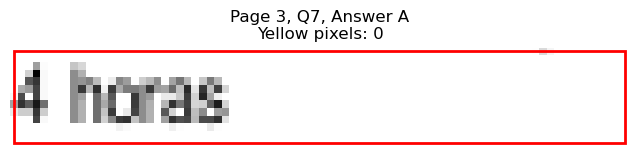

Page 3, Q7 - B: Detected box: x0=71.3, y0=567.5, x1=112.7, y1=579.5
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 186
Page 3, Q7, B: Yellow percentage: 0.0%


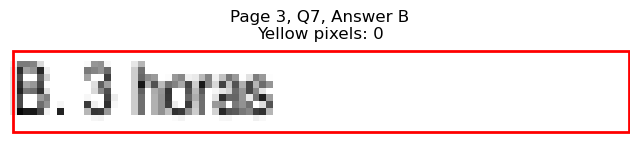

Page 3, Q7 - C: Detected box: x0=71.3, y0=579.4, x1=108.3, y1=591.5
Page 3, Q7, C: Yellow pixels: 336
Page 3, Q7, C: Total non-white pixels: 455
Page 3, Q7, C: Yellow percentage: 73.8%


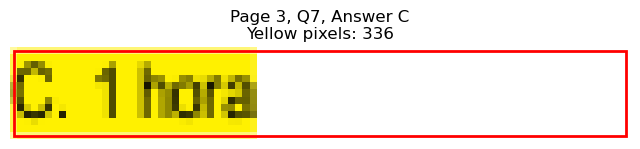

Page 3, Q7 - D: Detected box: x0=322.9, y0=555.4, x1=377.0, y1=567.5
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 236
Page 3, Q7, D: Yellow percentage: 0.0%


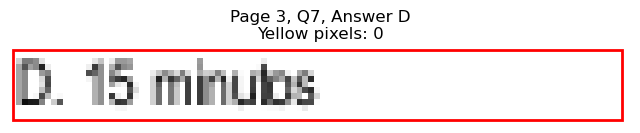

Page 3, Q7 - E: Detected box: x0=322.9, y0=567.5, x1=376.3, y1=579.5
Page 3, Q7, E: Yellow pixels: 0
Page 3, Q7, E: Total non-white pixels: 243
Page 3, Q7, E: Yellow percentage: 0.0%


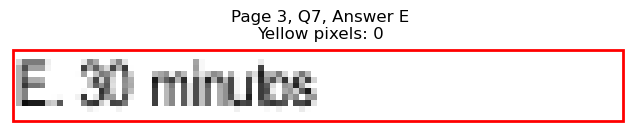


Page 3, Q7 - Selected Answer: C (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=82.6, y0=639.5, x1=240.2, y1=651.6
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 953
Page 3, Q8, A: Yellow percentage: 0.0%


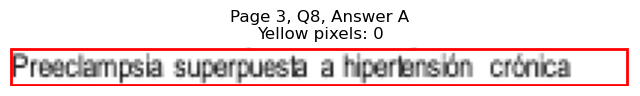

Page 3, Q8 - B: Detected box: x0=71.3, y0=651.5, x1=123.3, y1=663.6
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 264
Page 3, Q8, B: Yellow percentage: 0.0%


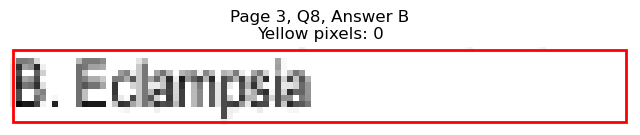

Page 3, Q8 - C: Detected box: x0=71.3, y0=663.5, x1=186.2, y1=675.6
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 562
Page 3, Q8, C: Yellow percentage: 0.0%


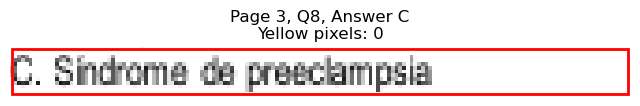

Page 3, Q8 - D: Detected box: x0=322.9, y0=639.5, x1=381.5, y1=651.6
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 537
Page 3, Q8, D: Yellow percentage: 0.0%


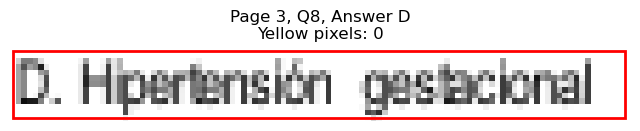

Page 3, Q8 - E: Detected box: x0=384.4, y0=651.5, x1=442.4, y1=663.6
Page 3, Q8, E: Yellow pixels: 482
Page 3, Q8, E: Total non-white pixels: 741
Page 3, Q8, E: Yellow percentage: 65.0%


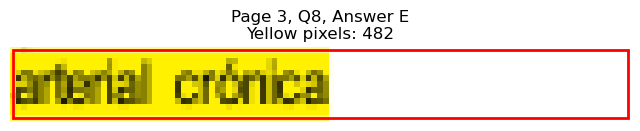


Page 3, Q8 - Selected Answer: E (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=82.6, y0=712.3, x1=105.2, y1=724.4
Page 3, Q9, A: Yellow pixels: 0
Page 3, Q9, A: Total non-white pixels: 112
Page 3, Q9, A: Yellow percentage: 0.0%


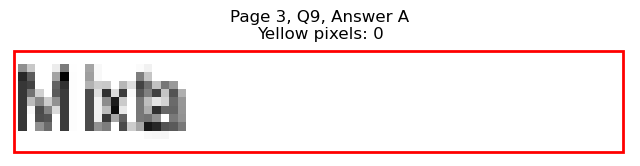

Page 3, Q9 - B: Detected box: x0=71.3, y0=724.3, x1=117.2, y1=736.4
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 215
Page 3, Q9, B: Yellow percentage: 0.0%


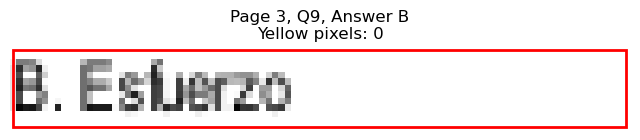

Page 3, Q9 - C: Detected box: x0=71.3, y0=736.4, x1=109.0, y1=748.4
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 159
Page 3, Q9, C: Yellow percentage: 0.0%


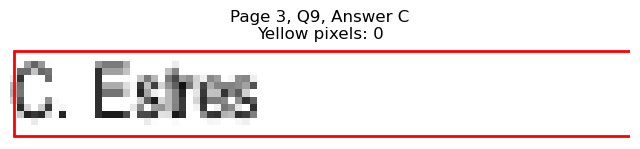

Page 3, Q9 - D: Detected box: x0=322.9, y0=712.3, x1=369.6, y1=724.4
Page 3, Q9, D: Yellow pixels: 346
Page 3, Q9, D: Total non-white pixels: 598
Page 3, Q9, D: Yellow percentage: 57.9%


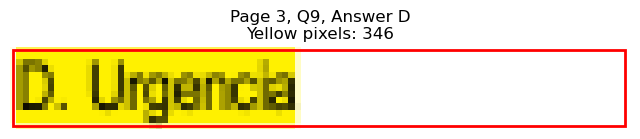

Page 3, Q9 - E: Detected box: x0=322.9, y0=724.3, x1=386.2, y1=736.4
Page 3, Q9, E: Yellow pixels: 2
Page 3, Q9, E: Total non-white pixels: 367
Page 3, Q9, E: Yellow percentage: 0.5%


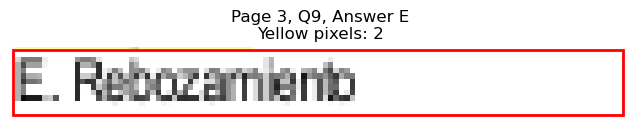


Page 3, Q9 - Selected Answer: D (based on yellow pixel count)





Page 4: Found 9 questions
Page 4, Q1 - A: Detected box: x0=82.6, y0=121.5, x1=172.9, y1=133.6
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 450
Page 4, Q1, A: Yellow percentage: 0.0%


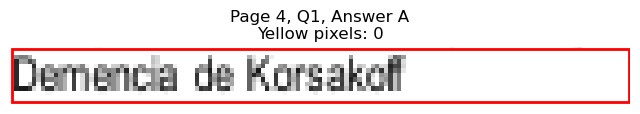

Page 4, Q1 - B: Detected box: x0=71.3, y0=133.5, x1=133.0, y1=145.6
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 507
Page 4, Q1, B: Yellow percentage: 0.0%


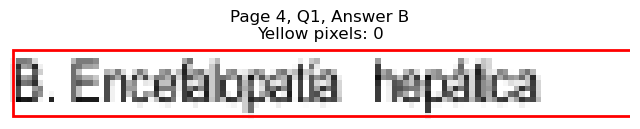

Page 4, Q1 - C: Detected box: x0=71.3, y0=145.6, x1=127.7, y1=157.6
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 407
Page 4, Q1, C: Yellow percentage: 0.0%


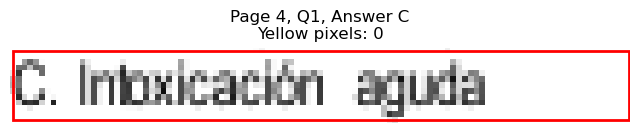

Page 4, Q1 - D: Detected box: x0=322.9, y0=121.5, x1=400.3, y1=133.6
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 363
Page 4, Q1, D: Yellow percentage: 0.0%


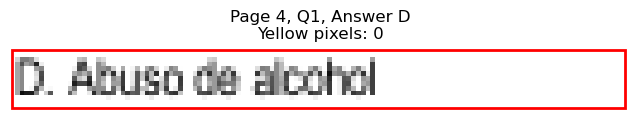

Page 4, Q1 - E: Detected box: x0=322.9, y0=133.5, x1=377.8, y1=145.6
Page 4, Q1, E: Yellow pixels: 733
Page 4, Q1, E: Total non-white pixels: 1235
Page 4, Q1, E: Yellow percentage: 59.4%


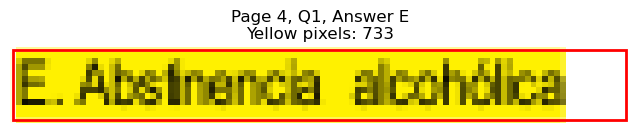


Page 4, Q1 - Selected Answer: E (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=82.6, y0=193.6, x1=135.2, y1=205.6
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 272
Page 4, Q2, A: Yellow percentage: 0.0%


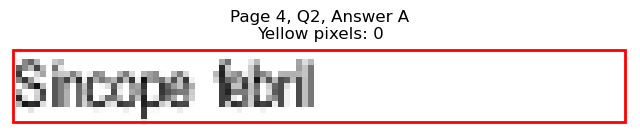

Page 4, Q2 - B: Detected box: x0=71.3, y0=205.6, x1=124.0, y1=217.7
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 261
Page 4, Q2, B: Yellow percentage: 0.0%


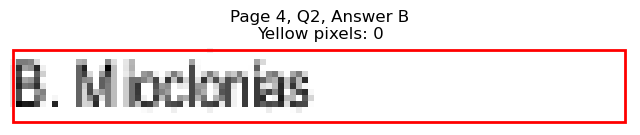

Page 4, Q2 - C: Detected box: x0=71.3, y0=217.6, x1=148.7, y1=229.7
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 495
Page 4, Q2, C: Yellow percentage: 0.0%


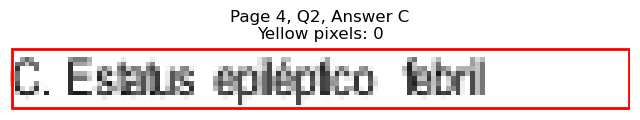

Page 4, Q2 - D: Detected box: x0=322.9, y0=193.6, x1=426.5, y1=205.6
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 498
Page 4, Q2, D: Yellow percentage: 0.0%


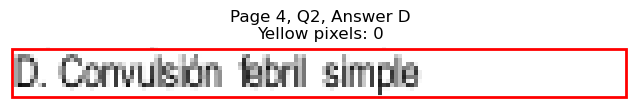

Page 4, Q2 - E: Detected box: x0=322.9, y0=205.6, x1=434.9, y1=217.7
Page 4, Q2, E: Yellow pixels: 885
Page 4, Q2, E: Total non-white pixels: 1443
Page 4, Q2, E: Yellow percentage: 61.3%


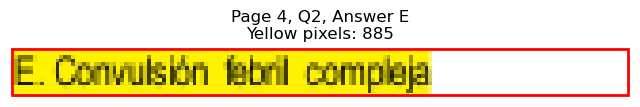


Page 4, Q2 - Selected Answer: E (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=82.6, y0=265.7, x1=132.2, y1=277.7
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 237
Page 4, Q3, A: Yellow percentage: 0.0%


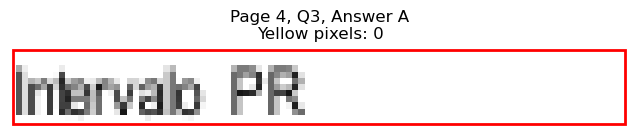

Page 4, Q3 - B: Detected box: x0=71.3, y0=277.7, x1=131.6, y1=289.7
Page 4, Q3, B: Yellow pixels: 474
Page 4, Q3, B: Total non-white pixels: 767
Page 4, Q3, B: Yellow percentage: 61.8%


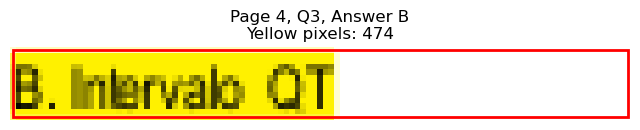

Page 4, Q3 - C: Detected box: x0=71.3, y0=289.7, x1=137.5, y1=301.8
Page 4, Q3, C: Yellow pixels: 58
Page 4, Q3, C: Total non-white pixels: 349
Page 4, Q3, C: Yellow percentage: 16.6%


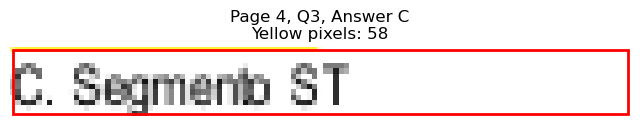

Page 4, Q3 - D: Detected box: x0=322.9, y0=265.7, x1=365.8, y1=277.7
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 179
Page 4, Q3, D: Yellow percentage: 0.0%


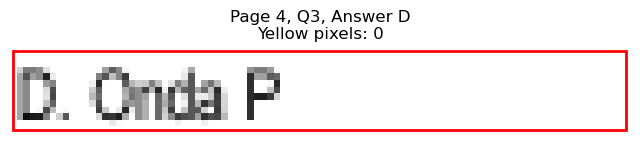

Page 4, Q3 - E: Detected box: x0=322.9, y0=277.7, x1=365.8, y1=289.7
Page 4, Q3, E: Yellow pixels: 0
Page 4, Q3, E: Total non-white pixels: 188
Page 4, Q3, E: Yellow percentage: 0.0%


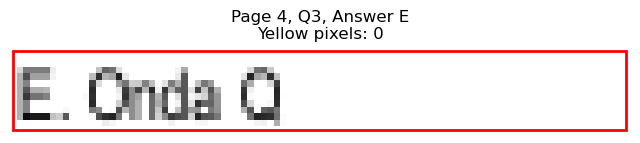


Page 4, Q3 - Selected Answer: B (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=82.6, y0=326.5, x1=235.2, y1=338.5
Page 4, Q4, A: Yellow pixels: 1352
Page 4, Q4, A: Total non-white pixels: 1963
Page 4, Q4, A: Yellow percentage: 68.9%


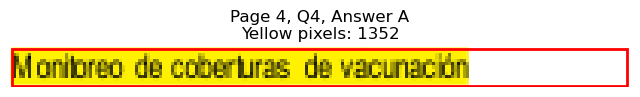

Page 4, Q4 - B: Detected box: x0=71.3, y0=338.5, x1=142.0, y1=350.5
Page 4, Q4, B: Yellow pixels: 109
Page 4, Q4, B: Total non-white pixels: 471
Page 4, Q4, B: Yellow percentage: 23.1%


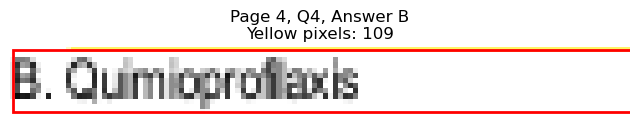

Page 4, Q4 - C: Detected box: x0=71.3, y0=350.5, x1=181.0, y1=362.5
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 559
Page 4, Q4, C: Yellow percentage: 0.0%


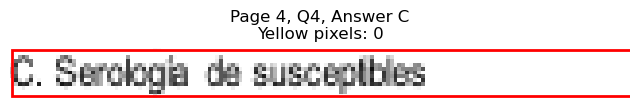

Page 4, Q4 - D: Detected box: x0=322.9, y0=326.5, x1=474.5, y1=338.5
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 733
Page 4, Q4, D: Yellow percentage: 0.0%


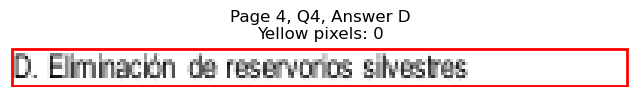

Page 4, Q4 - E: Detected box: x0=322.9, y0=338.5, x1=425.7, y1=350.5
Page 4, Q4, E: Yellow pixels: 0
Page 4, Q4, E: Total non-white pixels: 482
Page 4, Q4, E: Yellow percentage: 0.0%


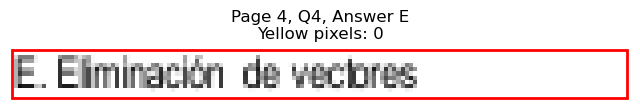


Page 4, Q4 - Selected Answer: A (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=82.6, y0=410.5, x1=128.5, y1=422.6
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 411
Page 4, Q5, A: Yellow percentage: 0.0%


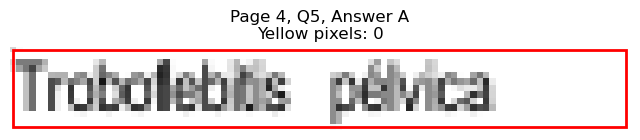

Page 4, Q5 - B: Detected box: x0=71.3, y0=422.5, x1=156.2, y1=434.6
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 442
Page 4, Q5, B: Yellow percentage: 0.0%


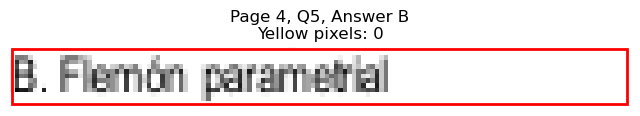

Page 4, Q5 - C: Detected box: x0=71.3, y0=434.6, x1=121.0, y1=446.6
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 259
Page 4, Q5, C: Yellow percentage: 0.0%


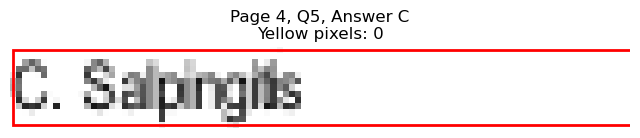

Page 4, Q5 - D: Detected box: x0=322.9, y0=410.5, x1=381.6, y1=422.6
Page 4, Q5, D: Yellow pixels: 424
Page 4, Q5, D: Total non-white pixels: 756
Page 4, Q5, D: Yellow percentage: 56.1%


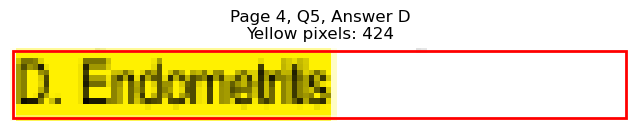

Page 4, Q5 - E: Detected box: x0=322.9, y0=422.5, x1=401.0, y1=434.6
Page 4, Q5, E: Yellow pixels: 56
Page 4, Q5, E: Total non-white pixels: 444
Page 4, Q5, E: Yellow percentage: 12.6%


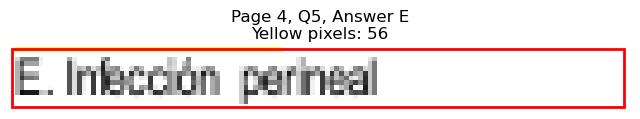


Page 4, Q5 - Selected Answer: D (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=82.6, y0=495.4, x1=94.0, y1=507.4
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 49
Page 4, Q6, A: Yellow percentage: 0.0%


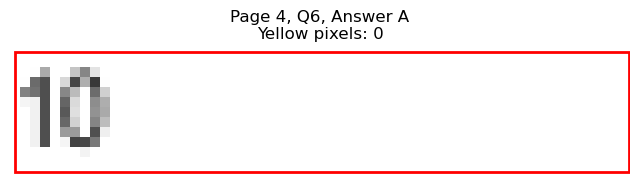

Page 4, Q6 - B: Detected box: x0=71.3, y0=507.4, x1=88.7, y1=519.4
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 73
Page 4, Q6, B: Yellow percentage: 0.0%


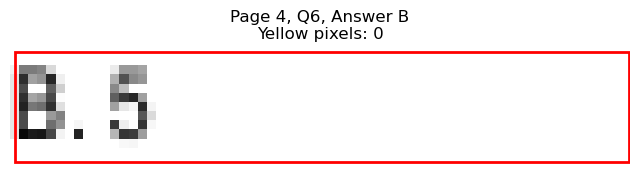

Page 4, Q6 - C: Detected box: x0=71.3, y0=519.4, x1=98.5, y1=531.4
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 103
Page 4, Q6, C: Yellow percentage: 0.0%


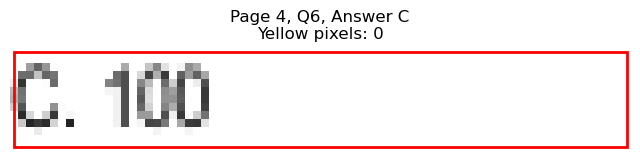

Page 4, Q6 - D: Detected box: x0=322.9, y0=495.4, x1=350.0, y1=507.4
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 123
Page 4, Q6, D: Yellow percentage: 0.0%


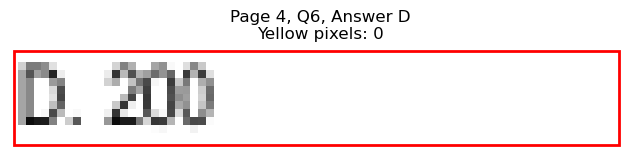

Page 4, Q6 - E: Detected box: x0=322.9, y0=507.4, x1=344.8, y1=519.4
Page 4, Q6, E: Yellow pixels: 178
Page 4, Q6, E: Total non-white pixels: 273
Page 4, Q6, E: Yellow percentage: 65.2%


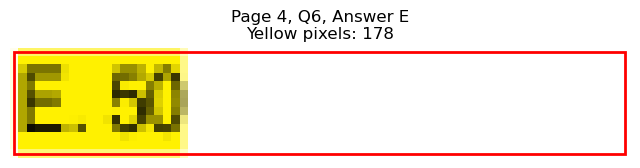


Page 4, Q6 - Selected Answer: E (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=82.6, y0=579.4, x1=165.2, y1=591.5
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 433
Page 4, Q7, A: Yellow percentage: 0.0%


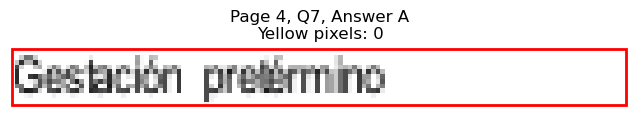

Page 4, Q7 - B: Detected box: x0=71.3, y0=591.5, x1=146.5, y1=603.5
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 375
Page 4, Q7, B: Yellow percentage: 0.0%


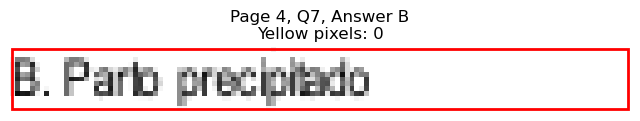

Page 4, Q7 - C: Detected box: x0=71.3, y0=603.5, x1=151.1, y1=615.5
Page 4, Q7, C: Yellow pixels: 707
Page 4, Q7, C: Total non-white pixels: 1014
Page 4, Q7, C: Yellow percentage: 69.7%


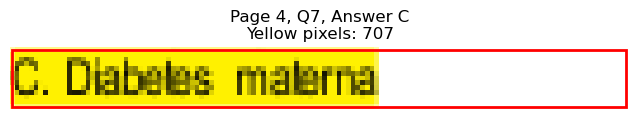

Page 4, Q7 - D: Detected box: x0=322.9, y0=579.4, x1=381.5, y1=591.5
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 454
Page 4, Q7, D: Yellow percentage: 0.0%


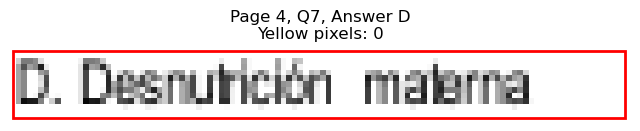

Page 4, Q7 - E: Detected box: x0=322.9, y0=591.5, x1=376.3, y1=603.5
Page 4, Q7, E: Yellow pixels: 0
Page 4, Q7, E: Total non-white pixels: 281
Page 4, Q7, E: Yellow percentage: 0.0%


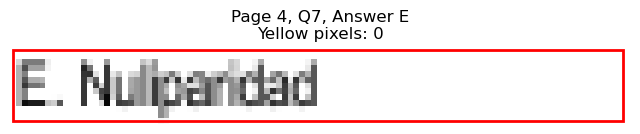


Page 4, Q7 - Selected Answer: C (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=82.6, y0=676.3, x1=136.0, y1=688.3
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 269
Page 4, Q8, A: Yellow percentage: 0.0%


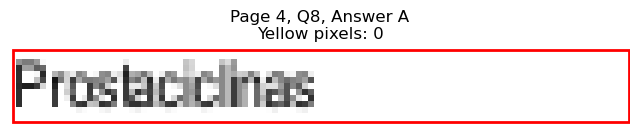

Page 4, Q8 - B: Detected box: x0=71.3, y0=688.3, x1=115.0, y1=700.3
Page 4, Q8, B: Yellow pixels: 692
Page 4, Q8, B: Total non-white pixels: 1092
Page 4, Q8, B: Yellow percentage: 63.4%


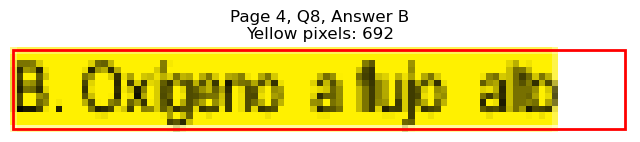

Page 4, Q8 - C: Detected box: x0=71.3, y0=700.3, x1=125.5, y1=712.3
Page 4, Q8, C: Yellow pixels: 3
Page 4, Q8, C: Total non-white pixels: 337
Page 4, Q8, C: Yellow percentage: 0.9%


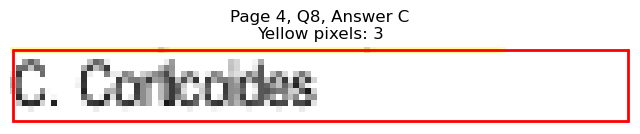

Page 4, Q8 - D: Detected box: x0=322.9, y0=676.3, x1=382.3, y1=688.3
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 309
Page 4, Q8, D: Yellow percentage: 0.0%


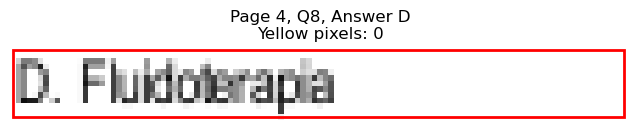

Page 4, Q8 - E: Detected box: x0=322.9, y0=688.3, x1=376.3, y1=700.3
Page 4, Q8, E: Yellow pixels: 0
Page 4, Q8, E: Total non-white pixels: 274
Page 4, Q8, E: Yellow percentage: 0.0%


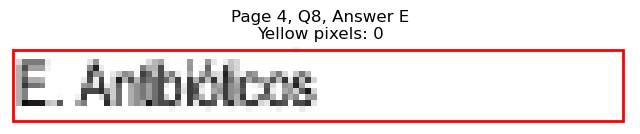


Page 4, Q8 - Selected Answer: B (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=82.6, y0=736.4, x1=213.3, y1=748.4
Page 4, Q9, A: Yellow pixels: 1455
Page 4, Q9, A: Total non-white pixels: 2132
Page 4, Q9, A: Yellow percentage: 68.2%


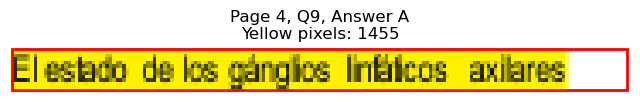

Page 4, Q9 - B: Detected box: x0=71.3, y0=748.4, x1=190.0, y1=760.4
Page 4, Q9, B: Yellow pixels: 157
Page 4, Q9, B: Total non-white pixels: 984
Page 4, Q9, B: Yellow percentage: 16.0%


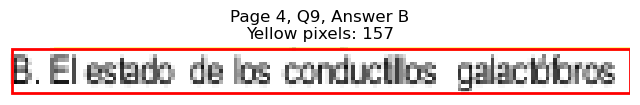

Page 4, Q9 - C: Detected box: x0=71.3, y0=760.4, x1=223.7, y1=772.4
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 730
Page 4, Q9, C: Yellow percentage: 0.0%


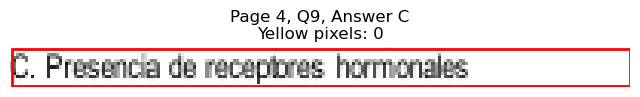

Page 4, Q9 - D: Detected box: x0=322.9, y0=736.4, x1=446.0, y1=748.4
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 586
Page 4, Q9, D: Yellow percentage: 0.0%


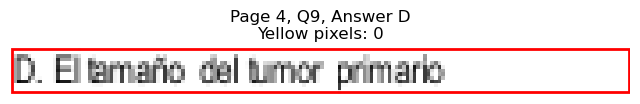

Page 4, Q9 - E: Detected box: x0=322.9, y0=748.4, x1=431.8, y1=760.4
Page 4, Q9, E: Yellow pixels: 0
Page 4, Q9, E: Total non-white pixels: 778
Page 4, Q9, E: Yellow percentage: 0.0%


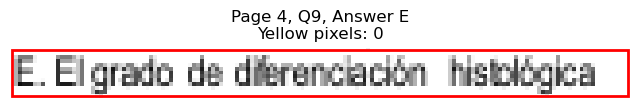


Page 4, Q9 - Selected Answer: A (based on yellow pixel count)





Page 5: Found 9 questions
Page 5, Q1 - A: Detected box: x0=82.6, y0=133.5, x1=139.0, y1=145.6
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 287
Page 5, Q1, A: Yellow percentage: 0.0%


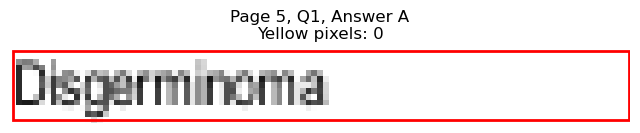

Page 5, Q1 - B: Detected box: x0=71.3, y0=145.6, x1=119.5, y1=157.6
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 219
Page 5, Q1, B: Yellow percentage: 0.0%


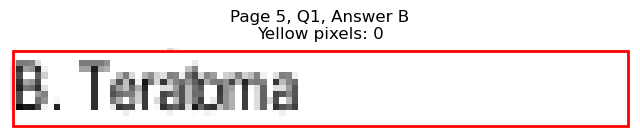

Page 5, Q1 - C: Detected box: x0=71.3, y0=157.6, x1=139.1, y1=169.6
Page 5, Q1, C: Yellow pixels: 537
Page 5, Q1, C: Total non-white pixels: 858
Page 5, Q1, C: Yellow percentage: 62.6%


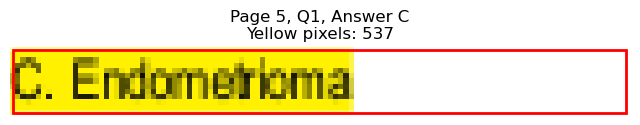

Page 5, Q1 - D: Detected box: x0=322.9, y0=133.5, x1=389.0, y1=145.6
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 331
Page 5, Q1, D: Yellow percentage: 0.0%


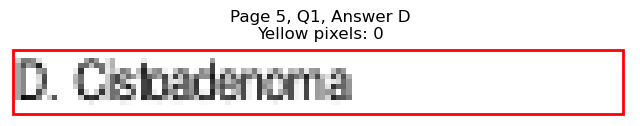

Page 5, Q1 - E: Detected box: x0=322.9, y0=145.6, x1=388.3, y1=157.6
Page 5, Q1, E: Yellow pixels: 0
Page 5, Q1, E: Total non-white pixels: 312
Page 5, Q1, E: Yellow percentage: 0.0%


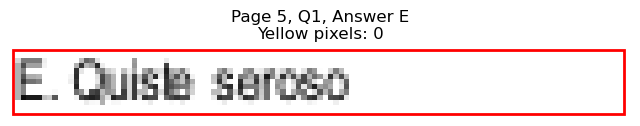


Page 5, Q1 - Selected Answer: C (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=82.6, y0=193.6, x1=100.8, y1=205.6
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 66
Page 5, Q2, A: Yellow percentage: 0.0%


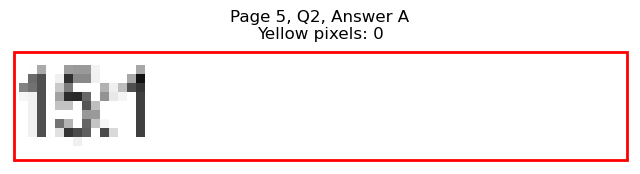

Page 5, Q2 - B: Detected box: x0=71.3, y0=205.6, x1=100.0, y1=217.7
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 126
Page 5, Q2, B: Yellow percentage: 0.0%


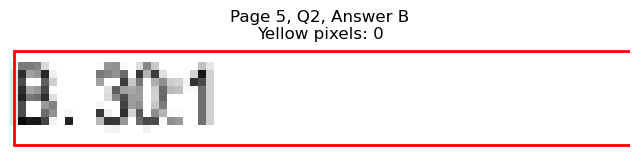

Page 5, Q2 - C: Detected box: x0=71.3, y0=217.6, x1=100.7, y1=229.7
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 108
Page 5, Q2, C: Yellow percentage: 0.0%


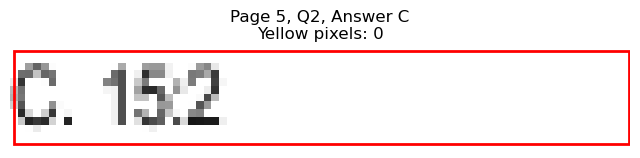

Page 5, Q2 - D: Detected box: x0=322.9, y0=193.6, x1=352.3, y1=205.6
Page 5, Q2, D: Yellow pixels: 226
Page 5, Q2, D: Total non-white pixels: 364
Page 5, Q2, D: Yellow percentage: 62.1%


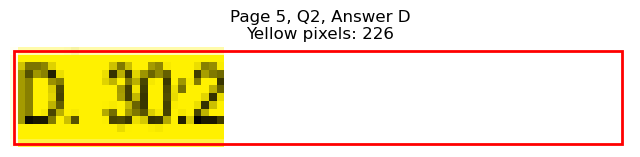

Page 5, Q2 - E: Detected box: x0=322.9, y0=205.6, x1=351.5, y1=217.7
Page 5, Q2, E: Yellow pixels: 27
Page 5, Q2, E: Total non-white pixels: 152
Page 5, Q2, E: Yellow percentage: 17.8%


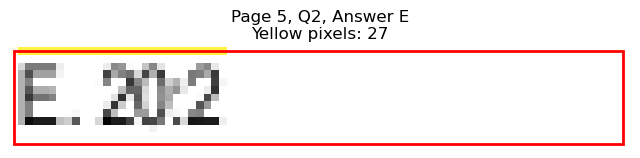


Page 5, Q2 - Selected Answer: D (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=133.6, y0=265.7, x1=191.5, y1=277.7
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 288
Page 5, Q3, A: Yellow percentage: 0.0%


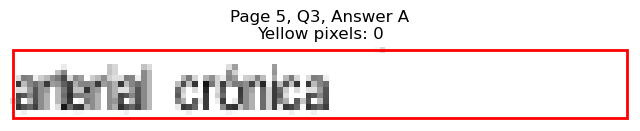

Page 5, Q3 - B: Detected box: x0=71.3, y0=277.7, x1=230.7, y1=289.7
Page 5, Q3, B: Yellow pixels: 1255
Page 5, Q3, B: Total non-white pixels: 2054
Page 5, Q3, B: Yellow percentage: 61.1%


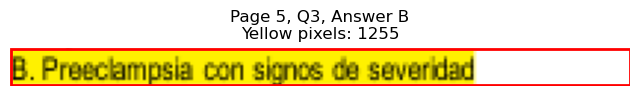

Page 5, Q3 - C: Detected box: x0=71.3, y0=289.7, x1=193.0, y1=301.8
Page 5, Q3, C: Yellow pixels: 153
Page 5, Q3, C: Total non-white pixels: 752
Page 5, Q3, C: Yellow percentage: 20.3%


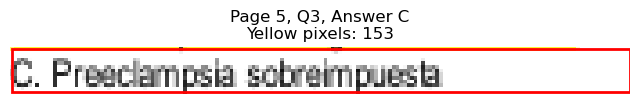

Page 5, Q3 - D: Detected box: x0=322.9, y0=265.7, x1=381.5, y1=277.7
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 534
Page 5, Q3, D: Yellow percentage: 0.0%


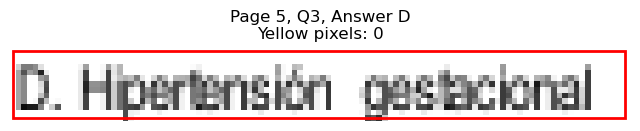

Page 5, Q3 - E: Detected box: x0=322.9, y0=277.7, x1=479.0, y1=289.7
Page 5, Q3, E: Yellow pixels: 0
Page 5, Q3, E: Total non-white pixels: 783
Page 5, Q3, E: Yellow percentage: 0.0%


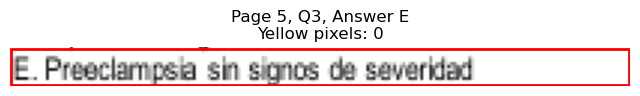


Page 5, Q3 - Selected Answer: B (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=71.3, y0=338.5, x1=79.7, y1=350.5
Page 5, Q4, A: Yellow pixels: 34
Page 5, Q4, A: Total non-white pixels: 112
Page 5, Q4, A: Yellow percentage: 30.4%


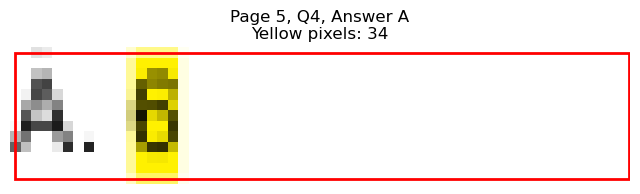

Page 5, Q4 - B: Detected box: x0=71.3, y0=350.5, x1=93.2, y1=362.5
Page 5, Q4, B: Yellow pixels: 4
Page 5, Q4, B: Total non-white pixels: 91
Page 5, Q4, B: Yellow percentage: 4.4%


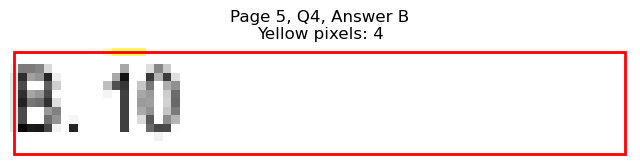

Page 5, Q4 - C: Detected box: x0=71.3, y0=362.5, x1=94.0, y1=374.6
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 72
Page 5, Q4, C: Yellow percentage: 0.0%


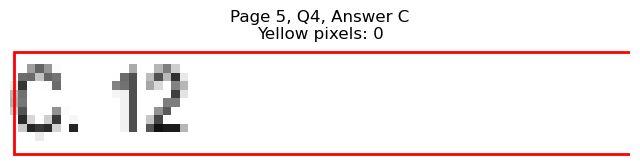

Page 5, Q4 - D: Detected box: x0=322.9, y0=338.5, x1=341.0, y1=350.5
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 72
Page 5, Q4, D: Yellow percentage: 0.0%


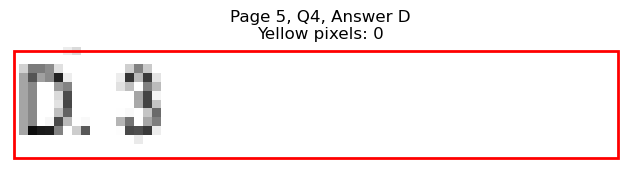

Page 5, Q4 - E: Detected box: x0=322.9, y0=350.5, x1=340.3, y1=362.5
Page 5, Q4, E: Yellow pixels: 0
Page 5, Q4, E: Total non-white pixels: 68
Page 5, Q4, E: Yellow percentage: 0.0%


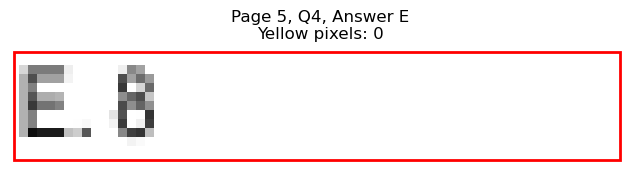


Page 5, Q4 - Selected Answer: A (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=82.6, y0=410.5, x1=164.5, y1=422.6
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 446
Page 5, Q5, A: Yellow percentage: 0.0%


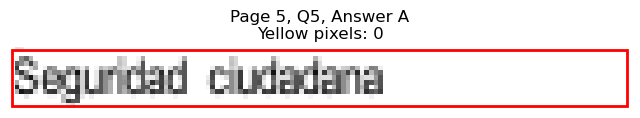

Page 5, Q5 - B: Detected box: x0=71.3, y0=422.5, x1=211.7, y1=434.6
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 669
Page 5, Q5, B: Yellow percentage: 0.0%


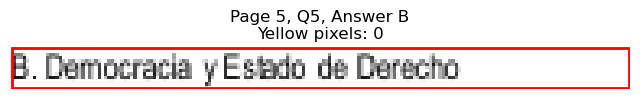

Page 5, Q5 - C: Detected box: x0=71.3, y0=434.6, x1=229.7, y1=446.6
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 768
Page 5, Q5, C: Yellow percentage: 0.0%


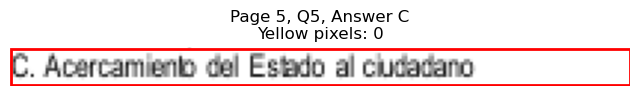

Page 5, Q5 - D: Detected box: x0=322.9, y0=410.5, x1=395.8, y1=422.6
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 609
Page 5, Q5, D: Yellow percentage: 0.0%


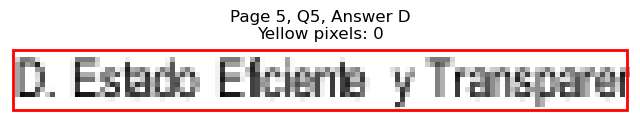

Page 5, Q5 - E: Detected box: x0=322.9, y0=422.5, x1=430.4, y1=434.6
Page 5, Q5, E: Yellow pixels: 839
Page 5, Q5, E: Total non-white pixels: 1391
Page 5, Q5, E: Yellow percentage: 60.3%


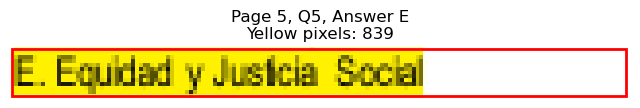


Page 5, Q5 - Selected Answer: E (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=82.6, y0=470.6, x1=130.8, y1=482.6
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 269
Page 5, Q6, A: Yellow percentage: 0.0%


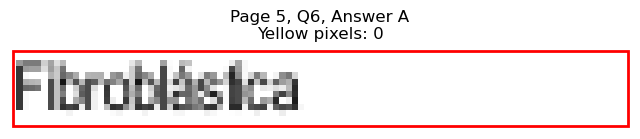

Page 5, Q6 - B: Detected box: x0=71.3, y0=483.4, x1=125.5, y1=495.4
Page 5, Q6, B: Yellow pixels: 436
Page 5, Q6, B: Total non-white pixels: 689
Page 5, Q6, B: Yellow percentage: 63.3%


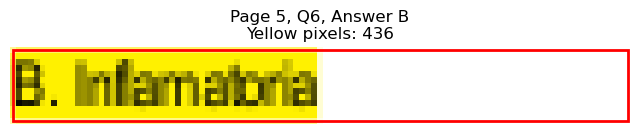

Page 5, Q6 - C: Detected box: x0=71.3, y0=495.4, x1=129.2, y1=507.4
Page 5, Q6, C: Yellow pixels: 51
Page 5, Q6, C: Total non-white pixels: 321
Page 5, Q6, C: Yellow percentage: 15.9%


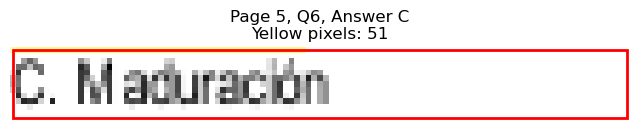

Page 5, Q6 - D: Detected box: x0=322.9, y0=470.6, x1=381.5, y1=482.6
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 314
Page 5, Q6, D: Yellow percentage: 0.0%


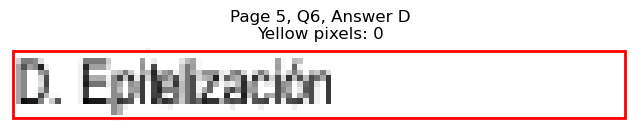

Page 5, Q6 - E: Detected box: x0=322.9, y0=483.4, x1=388.3, y1=495.4
Page 5, Q6, E: Yellow pixels: 0
Page 5, Q6, E: Total non-white pixels: 323
Page 5, Q6, E: Yellow percentage: 0.0%


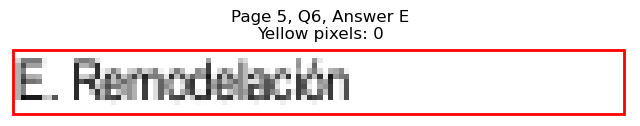


Page 5, Q6 - Selected Answer: B (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=82.6, y0=543.4, x1=220.9, y1=555.5
Page 5, Q7, A: Yellow pixels: 1224
Page 5, Q7, A: Total non-white pixels: 1782
Page 5, Q7, A: Yellow percentage: 68.7%


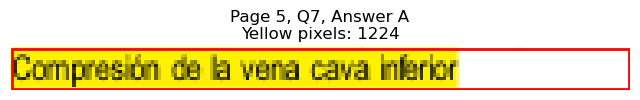

Page 5, Q7 - B: Detected box: x0=71.3, y0=555.4, x1=196.7, y1=567.5
Page 5, Q7, B: Yellow pixels: 135
Page 5, Q7, B: Total non-white pixels: 745
Page 5, Q7, B: Yellow percentage: 18.1%


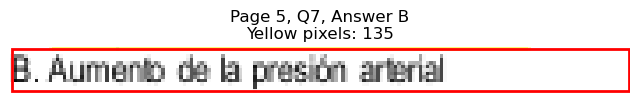

Page 5, Q7 - C: Detected box: x0=71.3, y0=567.5, x1=212.5, y1=579.5
Page 5, Q7, C: Yellow pixels: 0
Page 5, Q7, C: Total non-white pixels: 655
Page 5, Q7, C: Yellow percentage: 0.0%


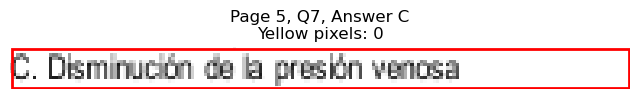

Page 5, Q7 - D: Detected box: x0=322.9, y0=543.4, x1=442.3, y1=555.5
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 578
Page 5, Q7, D: Yellow percentage: 0.0%


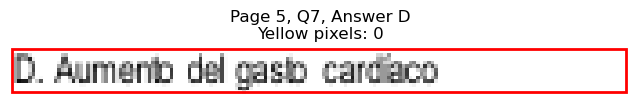

Page 5, Q7 - E: Detected box: x0=322.9, y0=555.4, x1=471.5, y1=567.5
Page 5, Q7, E: Yellow pixels: 0
Page 5, Q7, E: Total non-white pixels: 712
Page 5, Q7, E: Yellow percentage: 0.0%


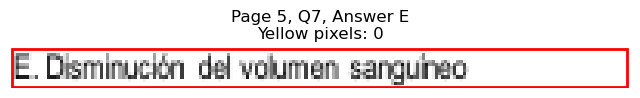


Page 5, Q7 - Selected Answer: A (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=82.6, y0=627.5, x1=163.8, y1=639.6
Page 5, Q8, A: Yellow pixels: 692
Page 5, Q8, A: Total non-white pixels: 1041
Page 5, Q8, A: Yellow percentage: 66.5%


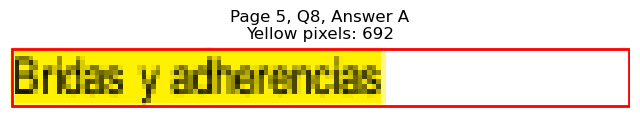

Page 5, Q8 - B: Detected box: x0=71.3, y0=639.5, x1=195.2, y1=651.6
Page 5, Q8, B: Yellow pixels: 78
Page 5, Q8, B: Total non-white pixels: 666
Page 5, Q8, B: Yellow percentage: 11.7%


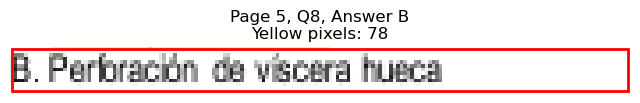

Page 5, Q8 - C: Detected box: x0=71.3, y0=651.5, x1=146.5, y1=663.6
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 329
Page 5, Q8, C: Yellow percentage: 0.0%


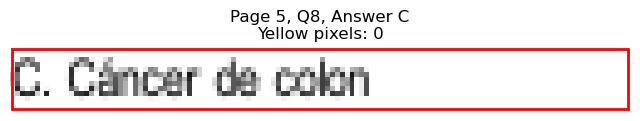

Page 5, Q8 - D: Detected box: x0=322.9, y0=627.5, x1=471.5, y1=639.6
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 711
Page 5, Q8, D: Yellow percentage: 0.0%


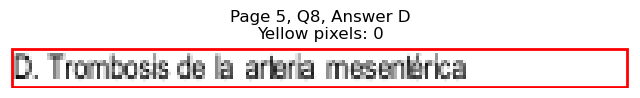

Page 5, Q8 - E: Detected box: x0=322.9, y0=639.5, x1=416.0, y1=651.6
Page 5, Q8, E: Yellow pixels: 0
Page 5, Q8, E: Total non-white pixels: 460
Page 5, Q8, E: Yellow percentage: 0.0%


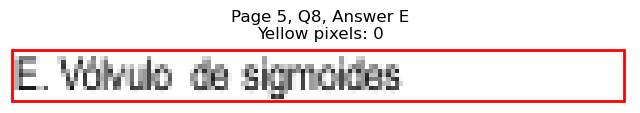


Page 5, Q8 - Selected Answer: A (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=71.3, y0=712.3, x1=79.7, y1=724.4
Page 5, Q9, A: Yellow pixels: 26
Page 5, Q9, A: Total non-white pixels: 110
Page 5, Q9, A: Yellow percentage: 23.6%


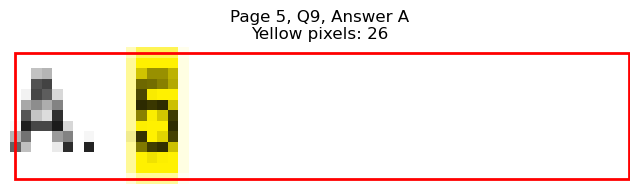

Page 5, Q9 - B: Detected box: x0=71.3, y0=724.3, x1=88.7, y1=736.4
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 77
Page 5, Q9, B: Yellow percentage: 0.0%


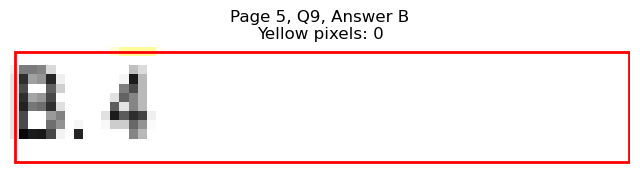

Page 5, Q9 - C: Detected box: x0=71.3, y0=736.4, x1=89.5, y1=748.4
Page 5, Q9, C: Yellow pixels: 0
Page 5, Q9, C: Total non-white pixels: 62
Page 5, Q9, C: Yellow percentage: 0.0%


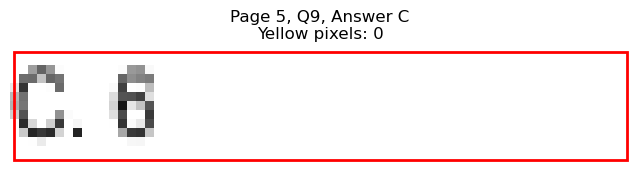

Page 5, Q9 - D: Detected box: x0=322.9, y0=712.3, x1=341.0, y1=724.4
Page 5, Q9, D: Yellow pixels: 0
Page 5, Q9, D: Total non-white pixels: 74
Page 5, Q9, D: Yellow percentage: 0.0%


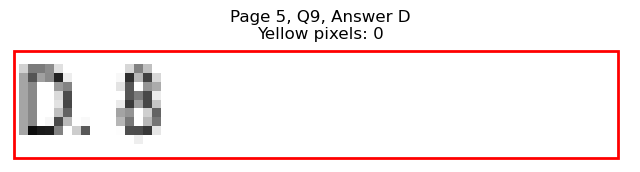

Page 5, Q9 - E: Detected box: x0=322.9, y0=724.3, x1=338.2, y1=736.4
Page 5, Q9, E: Yellow pixels: 0
Page 5, Q9, E: Total non-white pixels: 64
Page 5, Q9, E: Yellow percentage: 0.0%


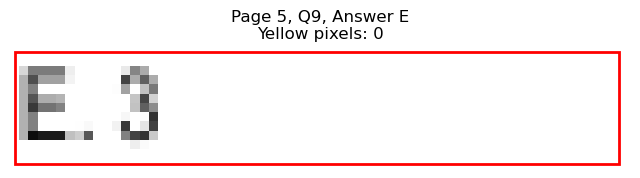


Page 5, Q9 - Selected Answer: A (based on yellow pixel count)





Page 6: Found 9 questions
Page 6, Q1 - A: Detected box: x0=82.6, y0=133.5, x1=163.7, y1=145.6
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 558
Page 6, Q1, A: Yellow percentage: 0.0%


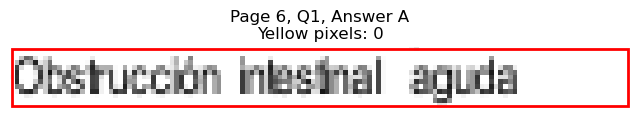

Page 6, Q1 - B: Detected box: x0=126.1, y0=145.6, x1=196.7, y1=157.6
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 375
Page 6, Q1, B: Yellow percentage: 0.0%


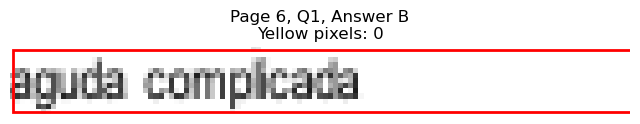

Page 6, Q1 - C: Detected box: x0=71.3, y0=157.6, x1=163.0, y1=169.6
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 443
Page 6, Q1, C: Yellow percentage: 0.0%


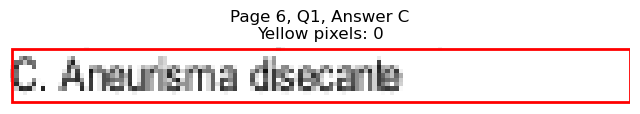

Page 6, Q1 - D: Detected box: x0=322.9, y0=133.5, x1=416.2, y1=145.6
Page 6, Q1, D: Yellow pixels: 729
Page 6, Q1, D: Total non-white pixels: 1196
Page 6, Q1, D: Yellow percentage: 61.0%


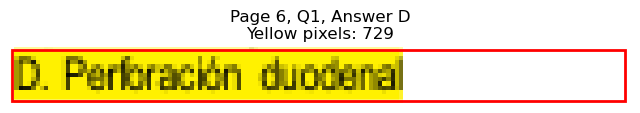

Page 6, Q1 - E: Detected box: x0=322.9, y0=145.6, x1=378.5, y1=157.6
Page 6, Q1, E: Yellow pixels: 91
Page 6, Q1, E: Total non-white pixels: 602
Page 6, Q1, E: Yellow percentage: 15.1%


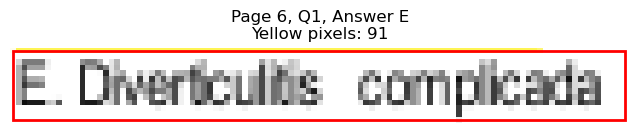


Page 6, Q1 - Selected Answer: D (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=82.6, y0=229.6, x1=178.0, y1=241.7
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 479
Page 6, Q2, A: Yellow percentage: 0.0%


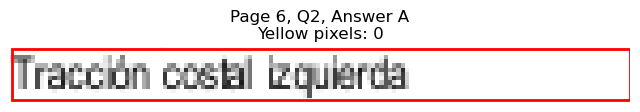

Page 6, Q2 - B: Detected box: x0=71.3, y0=241.6, x1=239.7, y1=253.7
Page 6, Q2, B: Yellow pixels: 1302
Page 6, Q2, B: Total non-white pixels: 2171
Page 6, Q2, B: Yellow percentage: 60.0%


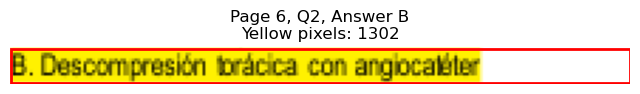

Page 6, Q2 - C: Detected box: x0=71.3, y0=253.6, x1=240.2, y1=265.7
Page 6, Q2, C: Yellow pixels: 166
Page 6, Q2, C: Total non-white pixels: 971
Page 6, Q2, C: Yellow percentage: 17.1%


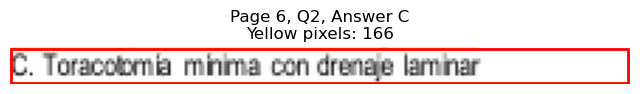

Page 6, Q2 - D: Detected box: x0=322.9, y0=229.6, x1=374.8, y1=241.7
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 425
Page 6, Q2, D: Yellow percentage: 0.0%


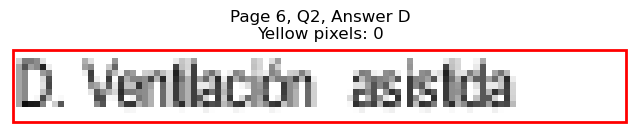

Page 6, Q2 - E: Detected box: x0=322.9, y0=241.6, x1=381.5, y1=253.7
Page 6, Q2, E: Yellow pixels: 0
Page 6, Q2, E: Total non-white pixels: 526
Page 6, Q2, E: Yellow percentage: 0.0%


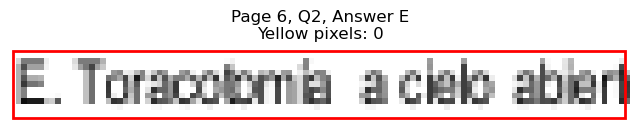


Page 6, Q2 - Selected Answer: B (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=82.6, y0=314.5, x1=143.5, y1=326.5
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 300
Page 6, Q3, A: Yellow percentage: 0.0%


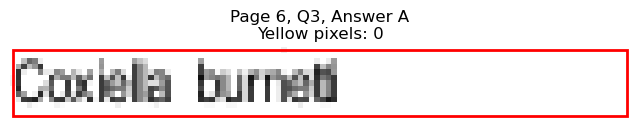

Page 6, Q3 - B: Detected box: x0=71.3, y0=326.5, x1=175.9, y1=338.5
Page 6, Q3, B: Yellow pixels: 899
Page 6, Q3, B: Total non-white pixels: 1339
Page 6, Q3, B: Yellow percentage: 67.1%


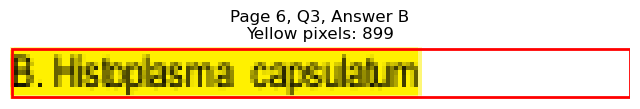

Page 6, Q3 - C: Detected box: x0=71.3, y0=338.5, x1=180.2, y1=350.5
Page 6, Q3, C: Yellow pixels: 102
Page 6, Q3, C: Total non-white pixels: 614
Page 6, Q3, C: Yellow percentage: 16.6%


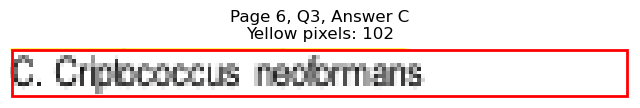

Page 6, Q3 - D: Detected box: x0=322.9, y0=314.5, x1=421.3, y1=326.5
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 490
Page 6, Q3, D: Yellow percentage: 0.0%


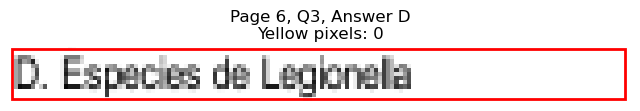

Page 6, Q3 - E: Detected box: x0=322.9, y0=326.5, x1=414.5, y1=338.5
Page 6, Q3, E: Yellow pixels: 0
Page 6, Q3, E: Total non-white pixels: 466
Page 6, Q3, E: Yellow percentage: 0.0%


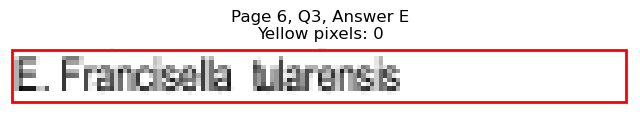


Page 6, Q3 - Selected Answer: B (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=82.6, y0=374.5, x1=126.2, y1=386.6
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 219
Page 6, Q4, A: Yellow percentage: 0.0%


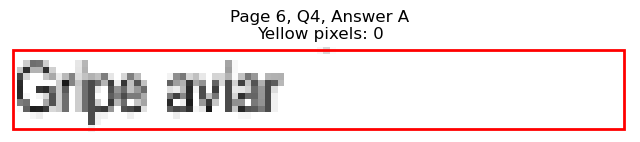

Page 6, Q4 - B: Detected box: x0=71.3, y0=386.5, x1=100.7, y1=398.6
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 136
Page 6, Q4, B: Yellow percentage: 0.0%


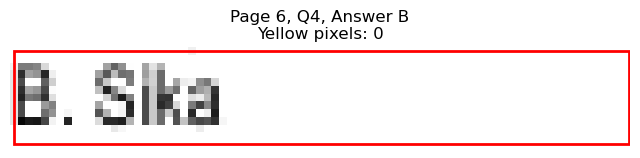

Page 6, Q4 - C: Detected box: x0=71.3, y0=398.5, x1=109.0, y1=410.6
Page 6, Q4, C: Yellow pixels: 328
Page 6, Q4, C: Total non-white pixels: 468
Page 6, Q4, C: Yellow percentage: 70.1%


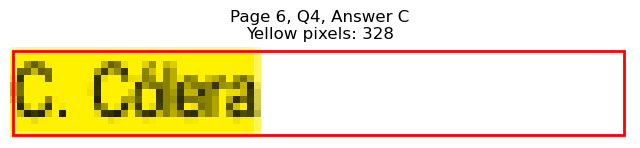

Page 6, Q4 - D: Detected box: x0=322.9, y0=374.5, x1=425.2, y1=386.6
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 491
Page 6, Q4, D: Yellow percentage: 0.0%


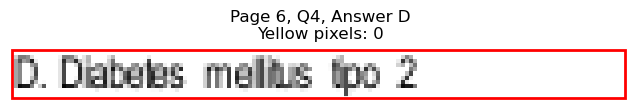

Page 6, Q4 - E: Detected box: x0=322.9, y0=386.5, x1=388.3, y1=398.6
Page 6, Q4, E: Yellow pixels: 0
Page 6, Q4, E: Total non-white pixels: 314
Page 6, Q4, E: Yellow percentage: 0.0%


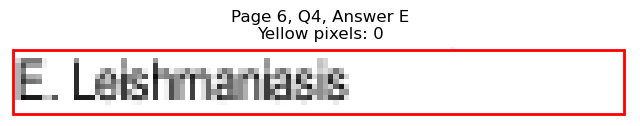


Page 6, Q4 - Selected Answer: C (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=82.6, y0=434.6, x1=116.5, y1=446.6
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 175
Page 6, Q5, A: Yellow percentage: 0.0%


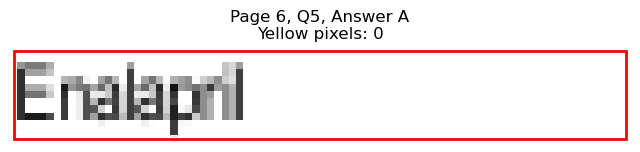

Page 6, Q5 - B: Detected box: x0=71.3, y0=446.6, x1=133.0, y1=458.6
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 321
Page 6, Q5, B: Yellow percentage: 0.0%


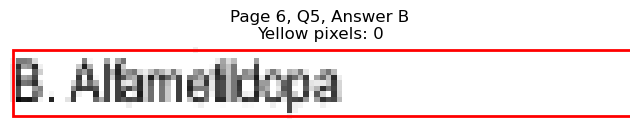

Page 6, Q5 - C: Detected box: x0=71.3, y0=458.6, x1=125.5, y1=470.6
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 252
Page 6, Q5, C: Yellow percentage: 0.0%


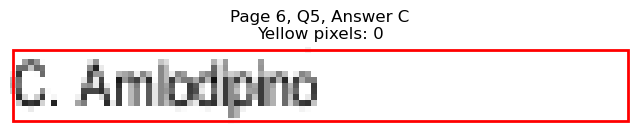

Page 6, Q5 - D: Detected box: x0=322.9, y0=434.6, x1=370.3, y1=446.6
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 234
Page 6, Q5, D: Yellow percentage: 0.0%


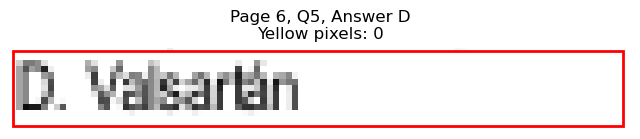

Page 6, Q5 - E: Detected box: x0=322.9, y0=446.6, x1=396.6, y1=458.6
Page 6, Q5, E: Yellow pixels: 561
Page 6, Q5, E: Total non-white pixels: 949
Page 6, Q5, E: Yellow percentage: 59.1%


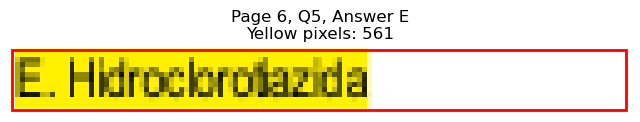


Page 6, Q5 - Selected Answer: E (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=82.6, y0=507.4, x1=94.0, y1=519.4
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 65
Page 6, Q6, A: Yellow percentage: 0.0%


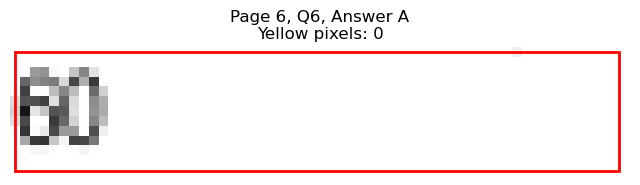

Page 6, Q6 - B: Detected box: x0=71.3, y0=519.4, x1=93.2, y1=531.4
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 101
Page 6, Q6, B: Yellow percentage: 0.0%


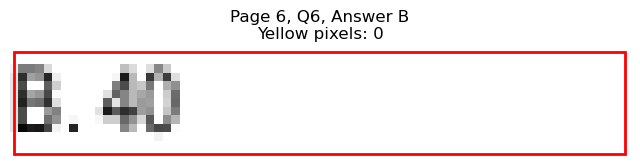

Page 6, Q6 - C: Detected box: x0=71.3, y0=531.4, x1=94.0, y1=543.5
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 86
Page 6, Q6, C: Yellow percentage: 0.0%


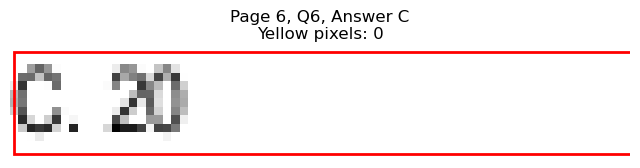

Page 6, Q6 - D: Detected box: x0=322.9, y0=507.4, x1=345.6, y1=519.4
Page 6, Q6, D: Yellow pixels: 184
Page 6, Q6, D: Total non-white pixels: 286
Page 6, Q6, D: Yellow percentage: 64.3%


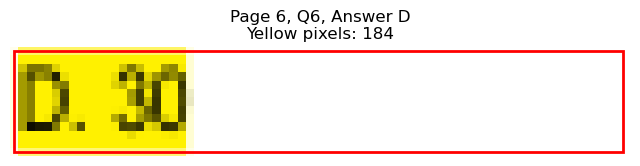

Page 6, Q6 - E: Detected box: x0=322.9, y0=519.4, x1=344.8, y1=531.4
Page 6, Q6, E: Yellow pixels: 20
Page 6, Q6, E: Total non-white pixels: 106
Page 6, Q6, E: Yellow percentage: 18.9%


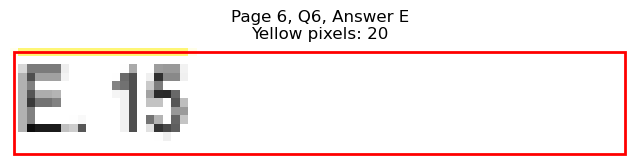


Page 6, Q6 - Selected Answer: D (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=82.6, y0=579.4, x1=109.7, y1=591.5
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 122
Page 6, Q7, A: Yellow percentage: 0.0%


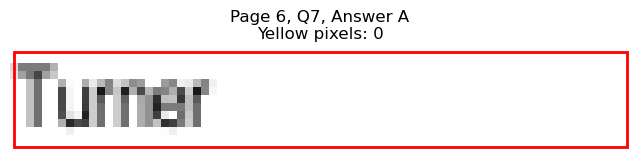

Page 6, Q7 - B: Detected box: x0=71.3, y0=591.5, x1=112.7, y1=603.5
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 209
Page 6, Q7, B: Yellow percentage: 0.0%


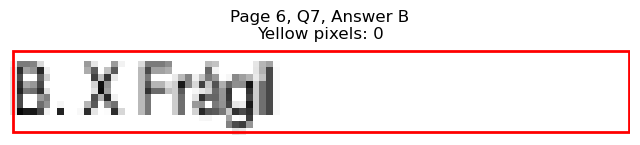

Page 6, Q7 - C: Detected box: x0=71.3, y0=603.5, x1=127.8, y1=615.5
Page 6, Q7, C: Yellow pixels: 492
Page 6, Q7, C: Total non-white pixels: 715
Page 6, Q7, C: Yellow percentage: 68.8%


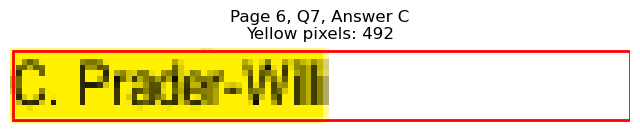

Page 6, Q7 - D: Detected box: x0=322.9, y0=579.4, x1=371.0, y1=591.5
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 256
Page 6, Q7, D: Yellow percentage: 0.0%


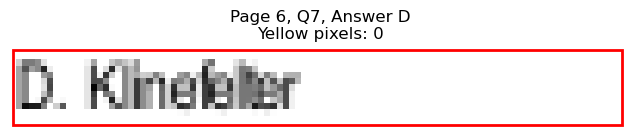

Page 6, Q7 - E: Detected box: x0=322.9, y0=591.5, x1=383.1, y1=603.5
Page 6, Q7, E: Yellow pixels: 0
Page 6, Q7, E: Total non-white pixels: 295
Page 6, Q7, E: Yellow percentage: 0.0%


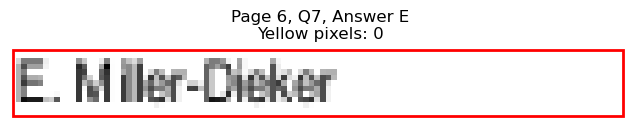


Page 6, Q7 - Selected Answer: C (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=82.6, y0=663.5, x1=185.6, y1=675.6
Page 6, Q8, A: Yellow pixels: 765
Page 6, Q8, A: Total non-white pixels: 1326
Page 6, Q8, A: Yellow percentage: 57.7%


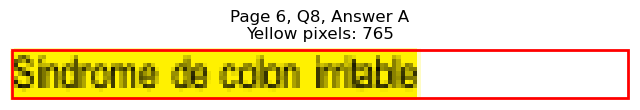

Page 6, Q8 - B: Detected box: x0=71.3, y0=676.3, x1=132.2, y1=688.3
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 573
Page 6, Q8, B: Yellow percentage: 0.0%


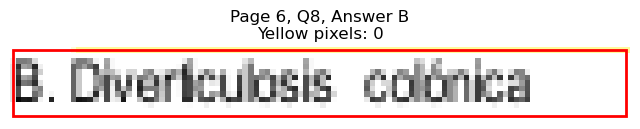

Page 6, Q8 - C: Detected box: x0=71.3, y0=688.3, x1=150.2, y1=700.3
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 375
Page 6, Q8, C: Yellow percentage: 0.0%


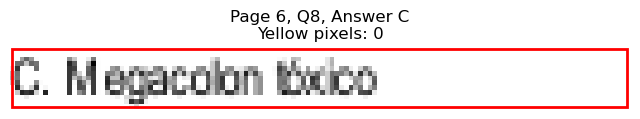

Page 6, Q8 - D: Detected box: x0=322.9, y0=663.5, x1=419.8, y1=675.6
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 461
Page 6, Q8, D: Yellow percentage: 0.0%


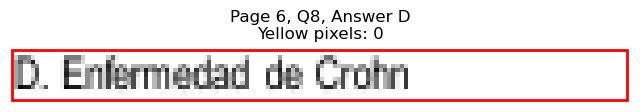

Page 6, Q8 - E: Detected box: x0=322.9, y0=676.3, x1=387.5, y1=688.3
Page 6, Q8, E: Yellow pixels: 0
Page 6, Q8, E: Total non-white pixels: 333
Page 6, Q8, E: Yellow percentage: 0.0%


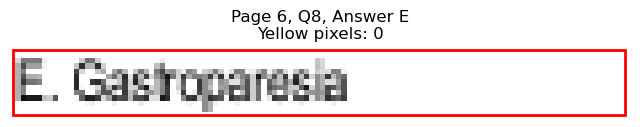


Page 6, Q8 - Selected Answer: A (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=82.6, y0=736.4, x1=150.3, y1=748.4
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 584
Page 6, Q9, A: Yellow percentage: 0.0%


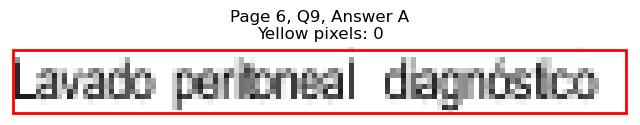

Page 6, Q9 - B: Detected box: x0=71.3, y0=748.4, x1=174.2, y1=760.4
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 519
Page 6, Q9, B: Yellow percentage: 0.0%


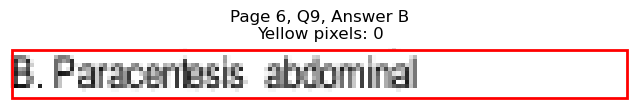

Page 6, Q9 - C: Detected box: x0=71.3, y0=760.4, x1=161.6, y1=772.4
Page 6, Q9, C: Yellow pixels: 782
Page 6, Q9, C: Total non-white pixels: 1157
Page 6, Q9, C: Yellow percentage: 67.6%


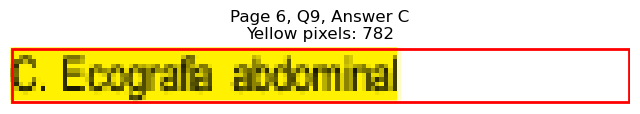

Page 6, Q9 - D: Detected box: x0=322.9, y0=736.4, x1=377.8, y1=748.4
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 490
Page 6, Q9, D: Yellow percentage: 0.0%


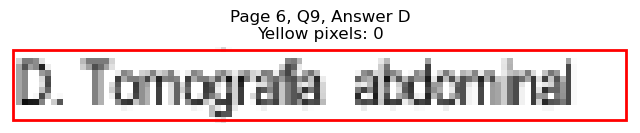

Page 6, Q9 - E: Detected box: x0=380.6, y0=748.4, x1=460.5, y1=760.4
Page 6, Q9, E: Yellow pixels: 0
Page 6, Q9, E: Total non-white pixels: 389
Page 6, Q9, E: Yellow percentage: 0.0%


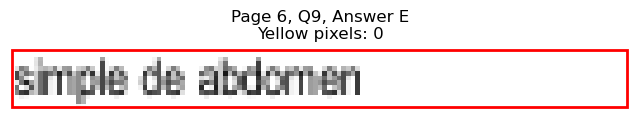


Page 6, Q9 - Selected Answer: C (based on yellow pixel count)





Page 7: Found 9 questions
Page 7, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=144.2, y1=108.8
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 324
Page 7, Q1, A: Yellow percentage: 0.0%


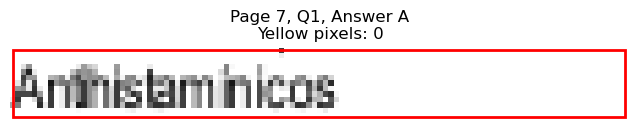

Page 7, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=141.2, y1=121.6
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 366
Page 7, Q1, B: Yellow percentage: 0.0%


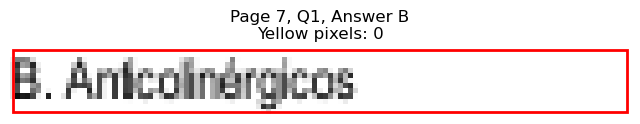

Page 7, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=111.3, y1=133.6
Page 7, Q1, C: Yellow pixels: 343
Page 7, Q1, C: Total non-white pixels: 496
Page 7, Q1, C: Yellow percentage: 69.2%


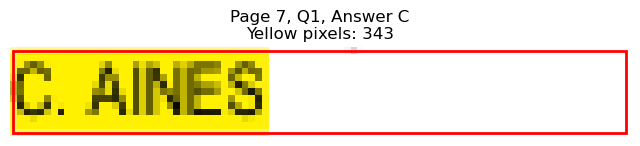

Page 7, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=377.0, y1=108.8
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 265
Page 7, Q1, D: Yellow percentage: 0.0%


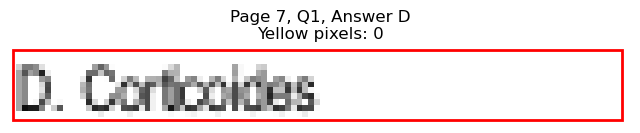

Page 7, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=392.8, y1=121.6
Page 7, Q1, E: Yellow pixels: 0
Page 7, Q1, E: Total non-white pixels: 349
Page 7, Q1, E: Yellow percentage: 0.0%


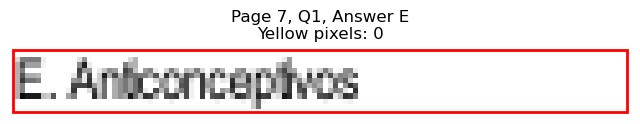


Page 7, Q1 - Selected Answer: C (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=82.6, y0=157.6, x1=160.8, y1=169.6
Page 7, Q2, A: Yellow pixels: 592
Page 7, Q2, A: Total non-white pixels: 1002
Page 7, Q2, A: Yellow percentage: 59.1%


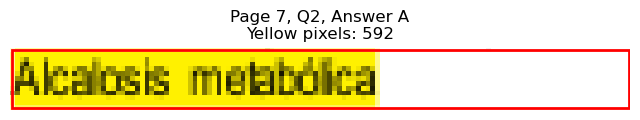

Page 7, Q2 - B: Detected box: x0=71.3, y0=169.6, x1=161.4, y1=181.6
Page 7, Q2, B: Yellow pixels: 75
Page 7, Q2, B: Total non-white pixels: 528
Page 7, Q2, B: Yellow percentage: 14.2%


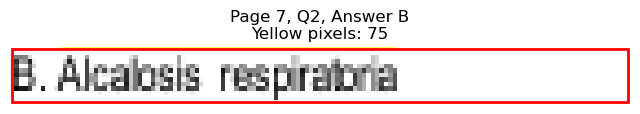

Page 7, Q2 - C: Detected box: x0=71.3, y0=181.6, x1=140.4, y1=193.6
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 312
Page 7, Q2, C: Yellow percentage: 0.0%


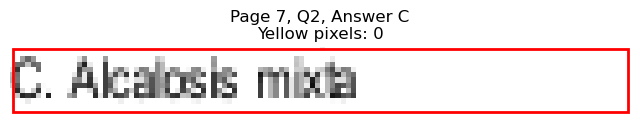

Page 7, Q2 - D: Detected box: x0=322.9, y0=157.6, x1=411.5, y1=169.6
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 431
Page 7, Q2, D: Yellow percentage: 0.0%


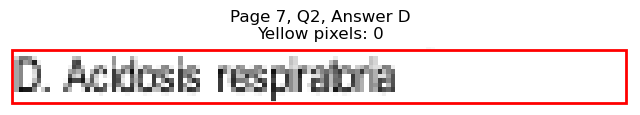

Page 7, Q2 - E: Detected box: x0=322.9, y0=169.6, x1=409.3, y1=181.6
Page 7, Q2, E: Yellow pixels: 0
Page 7, Q2, E: Total non-white pixels: 444
Page 7, Q2, E: Yellow percentage: 0.0%


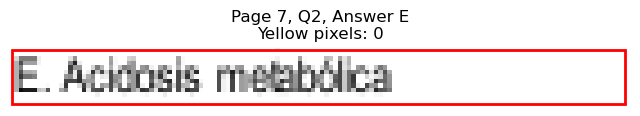


Page 7, Q2 - Selected Answer: A (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=82.6, y0=241.6, x1=173.5, y1=253.7
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 472
Page 7, Q3, A: Yellow percentage: 0.0%


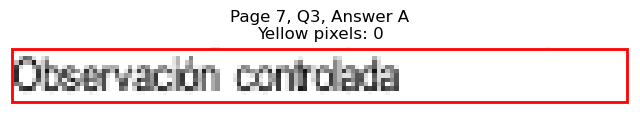

Page 7, Q3 - B: Detected box: x0=71.3, y0=253.6, x1=125.5, y1=265.7
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 476
Page 7, Q3, B: Yellow percentage: 0.0%


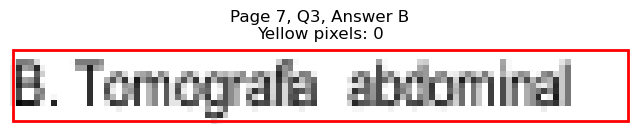

Page 7, Q3 - C: Detected box: x0=71.3, y0=265.7, x1=150.3, y1=277.7
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 377
Page 7, Q3, C: Yellow percentage: 0.0%


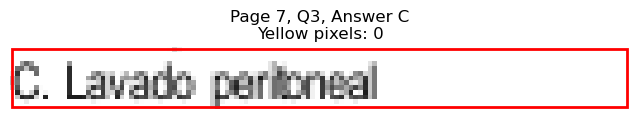

Page 7, Q3 - D: Detected box: x0=322.9, y0=241.6, x1=381.5, y1=253.7
Page 7, Q3, D: Yellow pixels: 828
Page 7, Q3, D: Total non-white pixels: 1365
Page 7, Q3, D: Yellow percentage: 60.7%


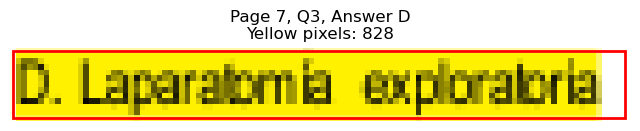

Page 7, Q3 - E: Detected box: x0=322.9, y0=253.6, x1=425.0, y1=265.7
Page 7, Q3, E: Yellow pixels: 104
Page 7, Q3, E: Total non-white pixels: 592
Page 7, Q3, E: Yellow percentage: 17.6%


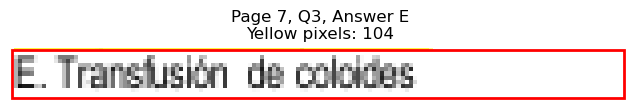


Page 7, Q3 - Selected Answer: D (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=82.6, y0=314.5, x1=148.0, y1=326.5
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 314
Page 7, Q4, A: Yellow percentage: 0.0%


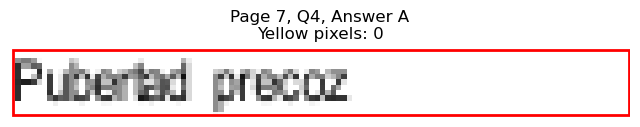

Page 7, Q4 - B: Detected box: x0=71.3, y0=326.5, x1=135.2, y1=338.5
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 306
Page 7, Q4, B: Yellow percentage: 0.0%


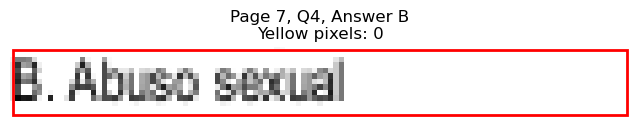

Page 7, Q4 - C: Detected box: x0=71.3, y0=338.5, x1=130.0, y1=350.5
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 270
Page 7, Q4, C: Yellow percentage: 0.0%


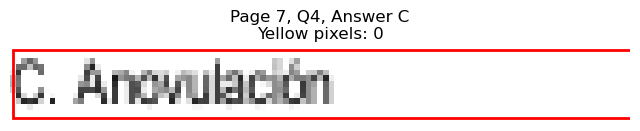

Page 7, Q4 - D: Detected box: x0=322.9, y0=314.5, x1=407.8, y1=326.5
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 424
Page 7, Q4, D: Yellow percentage: 0.0%


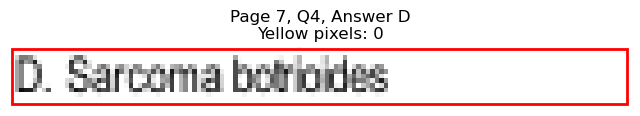

Page 7, Q4 - E: Detected box: x0=322.9, y0=326.5, x1=383.1, y1=338.5
Page 7, Q4, E: Yellow pixels: 499
Page 7, Q4, E: Total non-white pixels: 767
Page 7, Q4, E: Yellow percentage: 65.1%


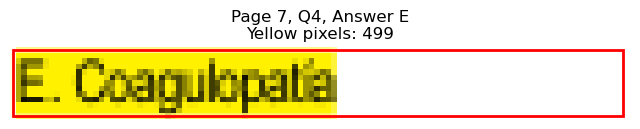


Page 7, Q4 - Selected Answer: E (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=82.6, y0=374.5, x1=121.0, y1=386.6
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 197
Page 7, Q5, A: Yellow percentage: 0.0%


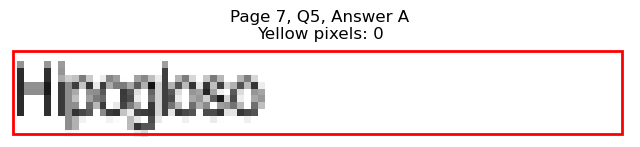

Page 7, Q5 - B: Detected box: x0=71.3, y0=386.5, x1=153.2, y1=398.6
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 405
Page 7, Q5, B: Yellow percentage: 0.0%


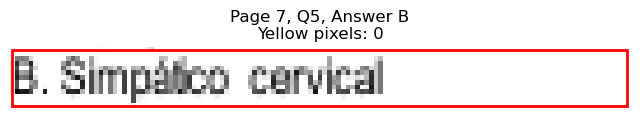

Page 7, Q5 - C: Detected box: x0=71.3, y0=398.5, x1=158.6, y1=410.6
Page 7, Q5, C: Yellow pixels: 777
Page 7, Q5, C: Total non-white pixels: 1118
Page 7, Q5, C: Yellow percentage: 69.5%


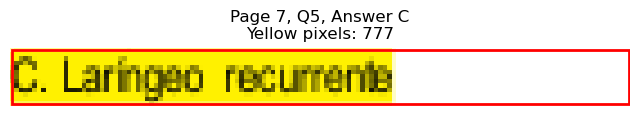

Page 7, Q5 - D: Detected box: x0=322.9, y0=374.5, x1=402.6, y1=386.6
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 376
Page 7, Q5, D: Yellow percentage: 0.0%


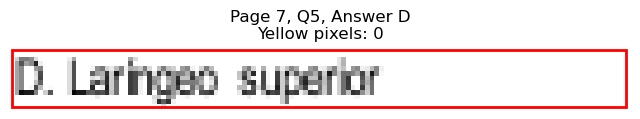

Page 7, Q5 - E: Detected box: x0=322.9, y0=386.5, x1=386.0, y1=398.6
Page 7, Q5, E: Yellow pixels: 0
Page 7, Q5, E: Total non-white pixels: 330
Page 7, Q5, E: Yellow percentage: 0.0%


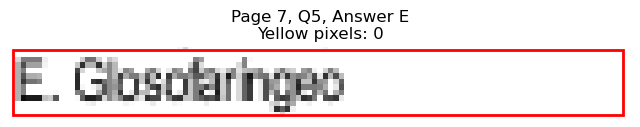


Page 7, Q5 - Selected Answer: C (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=82.6, y0=446.6, x1=194.6, y1=458.6
Page 7, Q6, A: Yellow pixels: 1266
Page 7, Q6, A: Total non-white pixels: 2093
Page 7, Q6, A: Yellow percentage: 60.5%


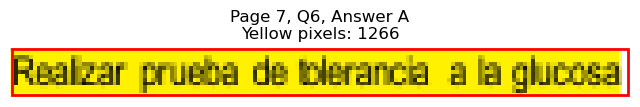

Page 7, Q6 - B: Detected box: x0=71.3, y0=458.6, x1=148.7, y1=470.6
Page 7, Q6, B: Yellow pixels: 116
Page 7, Q6, B: Total non-white pixels: 719
Page 7, Q6, B: Yellow percentage: 16.1%


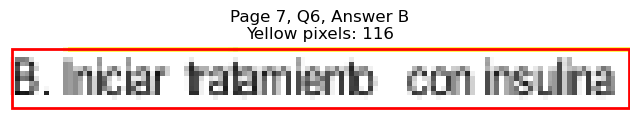

Page 7, Q6 - C: Detected box: x0=71.3, y0=470.6, x1=175.0, y1=482.6
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 498
Page 7, Q6, C: Yellow percentage: 0.0%


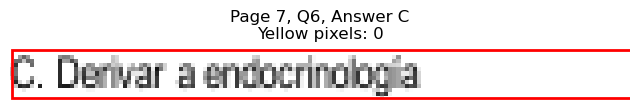

Page 7, Q6 - D: Detected box: x0=322.9, y0=446.6, x1=418.3, y1=458.6
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 478
Page 7, Q6, D: Yellow percentage: 0.0%


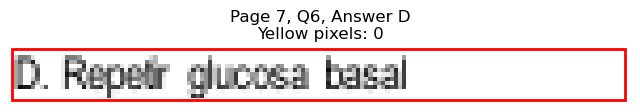

Page 7, Q6 - E: Detected box: x0=322.9, y0=458.6, x1=447.5, y1=470.6
Page 7, Q6, E: Yellow pixels: 0
Page 7, Q6, E: Total non-white pixels: 599
Page 7, Q6, E: Yellow percentage: 0.0%


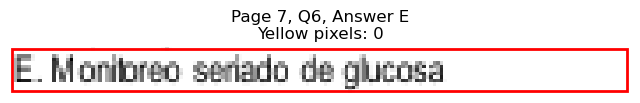


Page 7, Q6 - Selected Answer: A (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=82.6, y0=555.4, x1=126.2, y1=567.5
Page 7, Q7, A: Yellow pixels: 830
Page 7, Q7, A: Total non-white pixels: 1235
Page 7, Q7, A: Yellow percentage: 67.2%


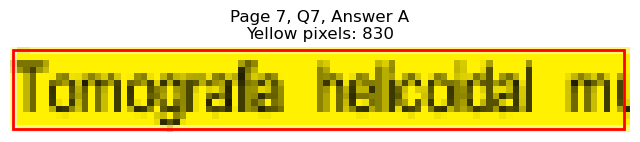

Page 7, Q7 - B: Detected box: x0=71.3, y0=567.5, x1=136.8, y1=579.5
Page 7, Q7, B: Yellow pixels: 104
Page 7, Q7, B: Total non-white pixels: 717
Page 7, Q7, B: Yellow percentage: 14.5%


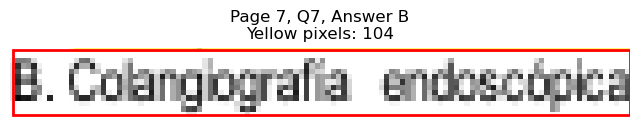

Page 7, Q7 - C: Detected box: x0=71.3, y0=579.4, x1=202.0, y1=591.5
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 632
Page 7, Q7, C: Yellow percentage: 0.0%


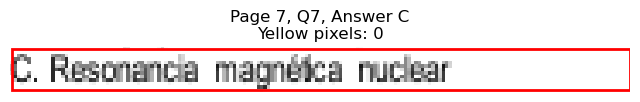

Page 7, Q7 - D: Detected box: x0=322.9, y0=555.4, x1=421.3, y1=567.5
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 511
Page 7, Q7, D: Yellow percentage: 0.0%


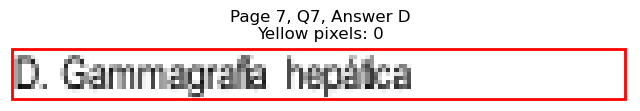

Page 7, Q7 - E: Detected box: x0=322.9, y0=567.5, x1=422.8, y1=579.5
Page 7, Q7, E: Yellow pixels: 0
Page 7, Q7, E: Total non-white pixels: 458
Page 7, Q7, E: Yellow percentage: 0.0%


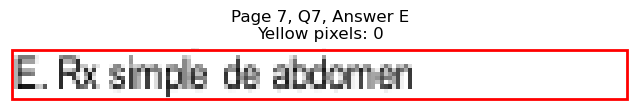


Page 7, Q7 - Selected Answer: A (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=82.6, y0=627.5, x1=136.0, y1=639.6
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 281
Page 7, Q8, A: Yellow percentage: 0.0%


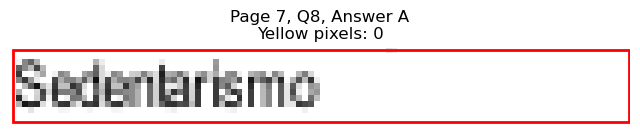

Page 7, Q8 - B: Detected box: x0=108.1, y0=639.5, x1=160.0, y1=651.6
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 266
Page 7, Q8, B: Yellow percentage: 0.0%


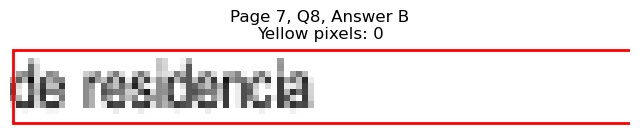

Page 7, Q8 - C: Detected box: x0=71.3, y0=651.5, x1=157.8, y1=663.6
Page 7, Q8, C: Yellow pixels: 768
Page 7, Q8, C: Total non-white pixels: 1105
Page 7, Q8, C: Yellow percentage: 69.5%


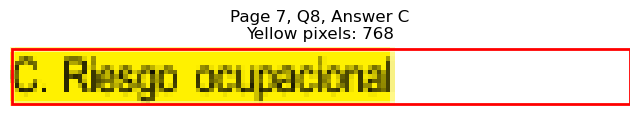

Page 7, Q8 - D: Detected box: x0=322.9, y0=627.5, x1=434.0, y1=639.6
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 562
Page 7, Q8, D: Yellow percentage: 0.0%


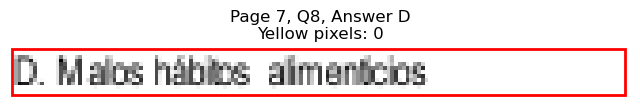

Page 7, Q8 - E: Detected box: x0=322.9, y0=639.5, x1=431.8, y1=651.6
Page 7, Q8, E: Yellow pixels: 0
Page 7, Q8, E: Total non-white pixels: 532
Page 7, Q8, E: Yellow percentage: 0.0%


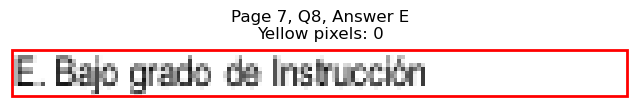


Page 7, Q8 - Selected Answer: C (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=82.6, y0=700.3, x1=147.2, y1=712.3
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 324
Page 7, Q9, A: Yellow percentage: 0.0%


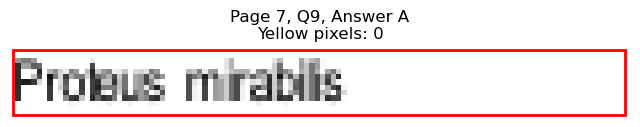

Page 7, Q9 - B: Detected box: x0=71.3, y0=712.3, x1=136.7, y1=724.4
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 336
Page 7, Q9, B: Yellow percentage: 0.0%


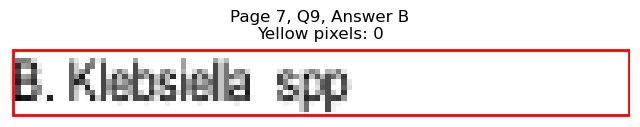

Page 7, Q9 - C: Detected box: x0=71.3, y0=724.3, x1=147.2, y1=736.4
Page 7, Q9, C: Yellow pixels: 0
Page 7, Q9, C: Total non-white pixels: 339
Page 7, Q9, C: Yellow percentage: 0.0%


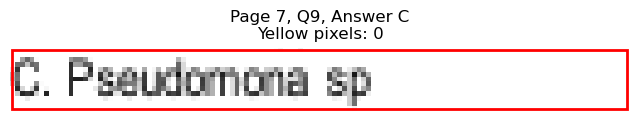

Page 7, Q9 - D: Detected box: x0=322.9, y0=700.3, x1=417.5, y1=712.3
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 479
Page 7, Q9, D: Yellow percentage: 0.0%


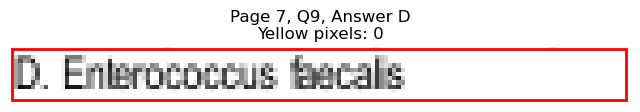

Page 7, Q9 - E: Detected box: x0=322.9, y0=712.3, x1=393.0, y1=724.4
Page 7, Q9, E: Yellow pixels: 541
Page 7, Q9, E: Total non-white pixels: 923
Page 7, Q9, E: Yellow percentage: 58.6%


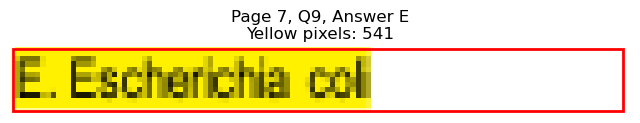


Page 7, Q9 - Selected Answer: E (based on yellow pixel count)





Page 8: Found 9 questions
Page 8, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=174.9, y1=108.8
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 453
Page 8, Q1, A: Yellow percentage: 0.0%


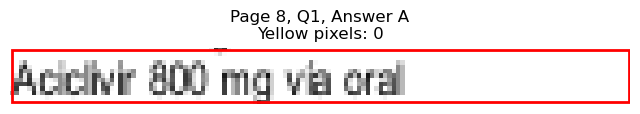

Page 8, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=187.0, y1=121.6
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 534
Page 8, Q1, B: Yellow percentage: 0.0%


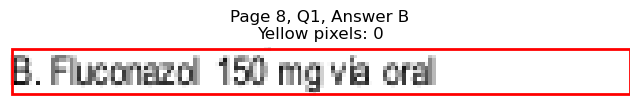

Page 8, Q1 - C: Detected box: x0=125.3, y0=121.5, x1=187.0, y1=133.6
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 300
Page 8, Q1, C: Yellow percentage: 0.0%


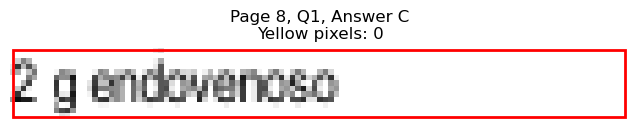

Page 8, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=421.3, y1=108.8
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 463
Page 8, Q1, D: Yellow percentage: 0.0%


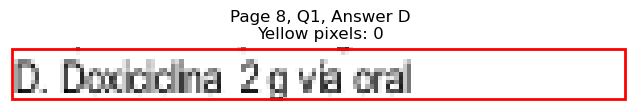

Page 8, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=389.8, y1=121.6
Page 8, Q1, E: Yellow pixels: 1096
Page 8, Q1, E: Total non-white pixels: 1534
Page 8, Q1, E: Yellow percentage: 71.4%


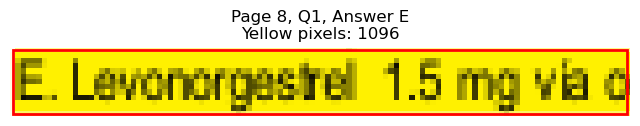


Page 8, Q1 - Selected Answer: E (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=82.6, y0=169.6, x1=121.8, y1=181.6
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 168
Page 8, Q2, A: Yellow percentage: 0.0%


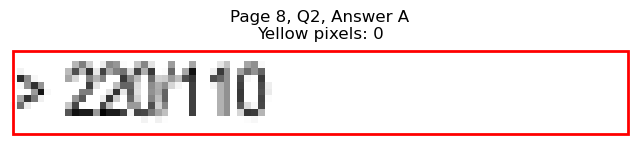

Page 8, Q2 - B: Detected box: x0=71.3, y0=181.6, x1=121.0, y1=193.6
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 231
Page 8, Q2, B: Yellow percentage: 0.0%


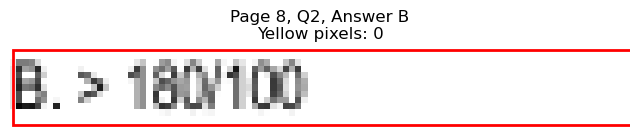

Page 8, Q2 - C: Detected box: x0=71.3, y0=193.6, x1=121.8, y1=205.6
Page 8, Q2, C: Yellow pixels: 419
Page 8, Q2, C: Total non-white pixels: 637
Page 8, Q2, C: Yellow percentage: 65.8%


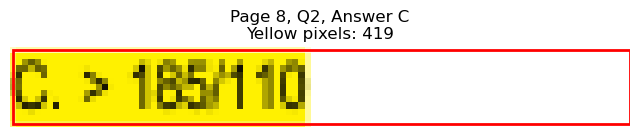

Page 8, Q2 - D: Detected box: x0=322.9, y0=169.6, x1=373.3, y1=181.6
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 224
Page 8, Q2, D: Yellow percentage: 0.0%


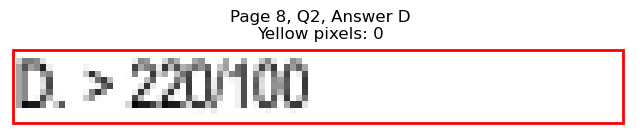

Page 8, Q2 - E: Detected box: x0=322.9, y0=181.6, x1=372.5, y1=193.6
Page 8, Q2, E: Yellow pixels: 0
Page 8, Q2, E: Total non-white pixels: 210
Page 8, Q2, E: Yellow percentage: 0.0%


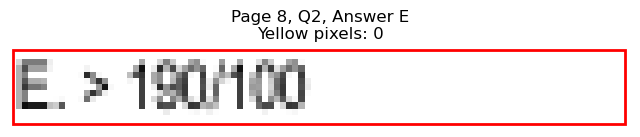


Page 8, Q2 - Selected Answer: C (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=82.6, y0=253.6, x1=130.0, y1=265.7
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 261
Page 8, Q3, A: Yellow percentage: 0.0%


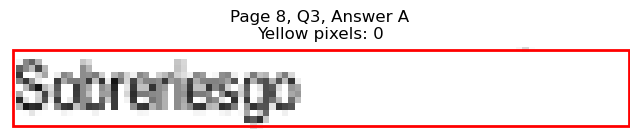

Page 8, Q3 - B: Detected box: x0=71.3, y0=265.7, x1=138.2, y1=277.7
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 611
Page 8, Q3, B: Yellow percentage: 0.0%


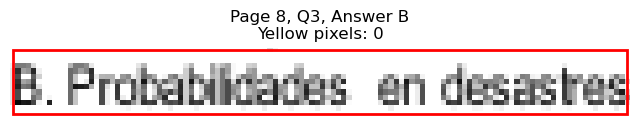

Page 8, Q3 - C: Detected box: x0=71.3, y0=277.7, x1=130.7, y1=289.7
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 272
Page 8, Q3, C: Yellow percentage: 0.0%


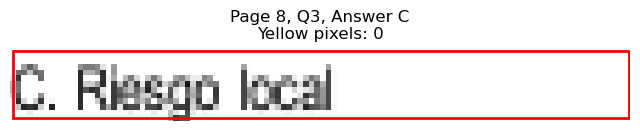

Page 8, Q3 - D: Detected box: x0=322.9, y0=253.6, x1=400.3, y1=265.7
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 407
Page 8, Q3, D: Yellow percentage: 0.0%


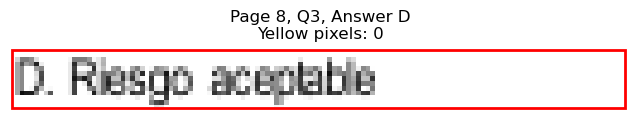

Page 8, Q3 - E: Detected box: x0=322.9, y0=265.7, x1=408.6, y1=277.7
Page 8, Q3, E: Yellow pixels: 651
Page 8, Q3, E: Total non-white pixels: 1105
Page 8, Q3, E: Yellow percentage: 58.9%


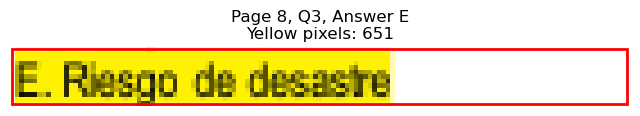


Page 8, Q3 - Selected Answer: E (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=82.6, y0=350.5, x1=201.2, y1=362.5
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 591
Page 8, Q4, A: Yellow percentage: 0.0%


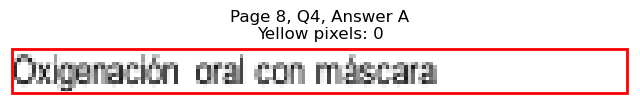

Page 8, Q4 - B: Detected box: x0=71.3, y0=362.5, x1=121.0, y1=374.6
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 488
Page 8, Q4, B: Yellow percentage: 0.0%


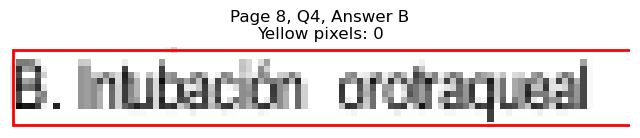

Page 8, Q4 - C: Detected box: x0=71.3, y0=374.5, x1=139.7, y1=386.6
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 326
Page 8, Q4, C: Yellow percentage: 0.0%


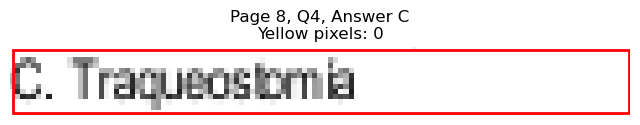

Page 8, Q4 - D: Detected box: x0=322.9, y0=350.5, x1=397.4, y1=362.5
Page 8, Q4, D: Yellow pixels: 629
Page 8, Q4, D: Total non-white pixels: 949
Page 8, Q4, D: Yellow percentage: 66.3%


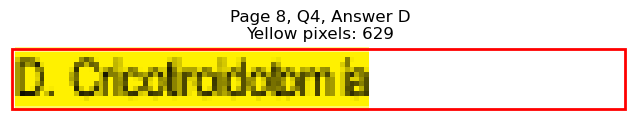

Page 8, Q4 - E: Detected box: x0=322.9, y0=362.5, x1=372.6, y1=374.6
Page 8, Q4, E: Yellow pixels: 72
Page 8, Q4, E: Total non-white pixels: 581
Page 8, Q4, E: Yellow percentage: 12.4%


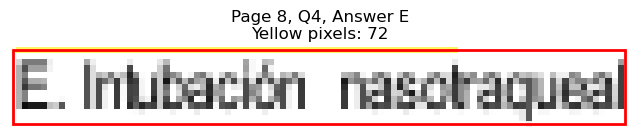


Page 8, Q4 - Selected Answer: D (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=82.6, y0=410.5, x1=210.2, y1=422.6
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 613
Page 8, Q5, A: Yellow percentage: 0.0%


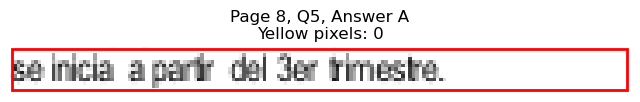

Page 8, Q5 - B: Detected box: x0=71.3, y0=422.5, x1=233.4, y1=434.6
Page 8, Q5, B: Yellow pixels: 0
Page 8, Q5, B: Total non-white pixels: 741
Page 8, Q5, B: Yellow percentage: 0.0%


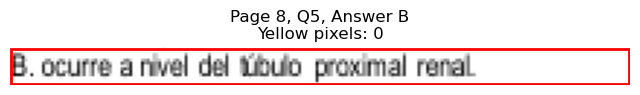

Page 8, Q5 - C: Detected box: x0=71.3, y0=434.6, x1=245.6, y1=446.6
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 826
Page 8, Q5, C: Yellow percentage: 0.0%


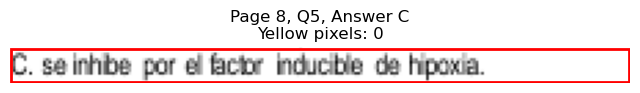

Page 8, Q5 - D: Detected box: x0=322.9, y0=410.5, x1=440.8, y1=422.6
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 753
Page 8, Q5, D: Yellow percentage: 0.0%


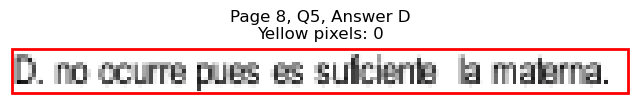

Page 8, Q5 - E: Detected box: x0=322.9, y0=422.5, x1=480.5, y1=434.6
Page 8, Q5, E: Yellow pixels: 1575
Page 8, Q5, E: Total non-white pixels: 2587
Page 8, Q5, E: Yellow percentage: 60.9%


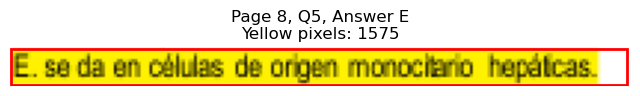


Page 8, Q5 - Selected Answer: E (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=82.6, y0=507.4, x1=94.0, y1=519.4
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 61
Page 8, Q6, A: Yellow percentage: 0.0%


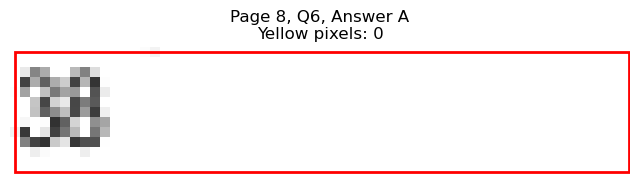

Page 8, Q6 - B: Detected box: x0=71.3, y0=519.4, x1=93.2, y1=531.4
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 101
Page 8, Q6, B: Yellow percentage: 0.0%


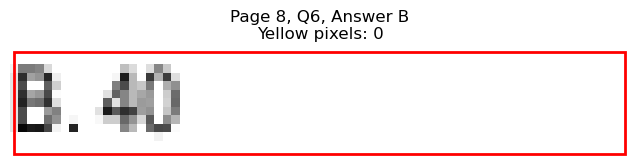

Page 8, Q6 - C: Detected box: x0=71.3, y0=531.4, x1=94.0, y1=543.5
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 90
Page 8, Q6, C: Yellow percentage: 0.0%


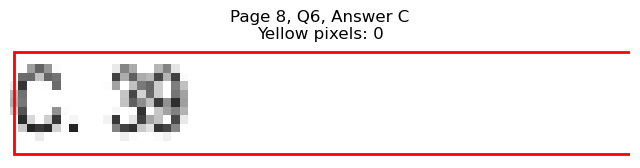

Page 8, Q6 - D: Detected box: x0=322.9, y0=507.4, x1=345.6, y1=519.4
Page 8, Q6, D: Yellow pixels: 188
Page 8, Q6, D: Total non-white pixels: 286
Page 8, Q6, D: Yellow percentage: 65.7%


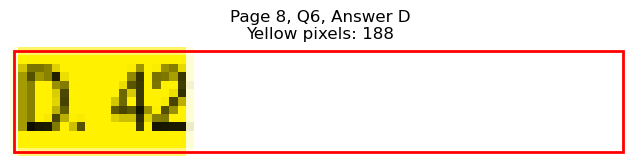

Page 8, Q6 - E: Detected box: x0=322.9, y0=519.4, x1=344.8, y1=531.4
Page 8, Q6, E: Yellow pixels: 20
Page 8, Q6, E: Total non-white pixels: 108
Page 8, Q6, E: Yellow percentage: 18.5%


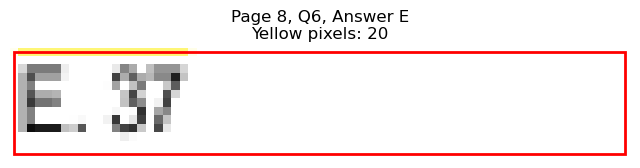


Page 8, Q6 - Selected Answer: D (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=82.6, y0=603.5, x1=122.5, y1=615.5
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 203
Page 8, Q7, A: Yellow percentage: 0.0%


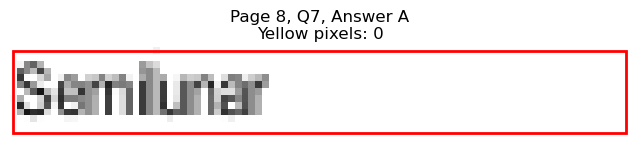

Page 8, Q7 - B: Detected box: x0=71.3, y0=615.5, x1=163.0, y1=627.5
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 489
Page 8, Q7, B: Yellow percentage: 0.0%


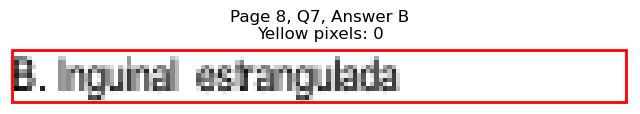

Page 8, Q7 - C: Detected box: x0=71.3, y0=627.5, x1=163.8, y1=639.6
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 456
Page 8, Q7, C: Yellow percentage: 0.0%


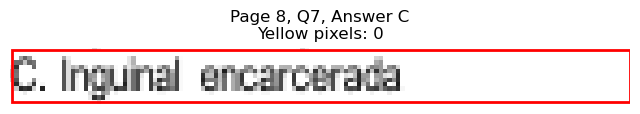

Page 8, Q7 - D: Detected box: x0=322.9, y0=603.5, x1=371.8, y1=615.5
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 237
Page 8, Q7, D: Yellow percentage: 0.0%


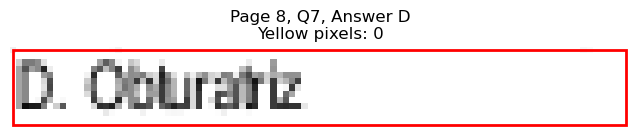

Page 8, Q7 - E: Detected box: x0=322.9, y0=615.5, x1=416.2, y1=627.5
Page 8, Q7, E: Yellow pixels: 792
Page 8, Q7, E: Total non-white pixels: 1196
Page 8, Q7, E: Yellow percentage: 66.2%


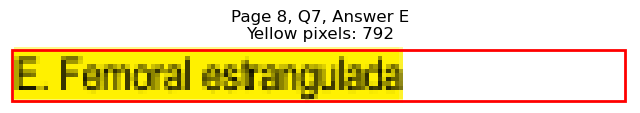


Page 8, Q7 - Selected Answer: E (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=82.6, y0=663.5, x1=139.0, y1=675.6
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 555
Page 8, Q8, A: Yellow percentage: 0.0%


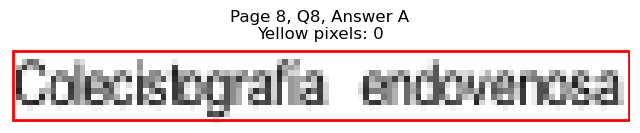

Page 8, Q8 - B: Detected box: x0=71.3, y0=676.3, x1=160.7, y1=688.3
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 462
Page 8, Q8, B: Yellow percentage: 0.0%


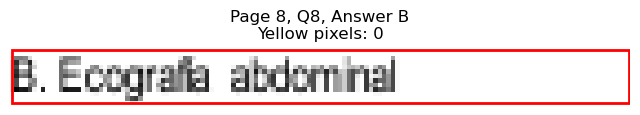

Page 8, Q8 - C: Detected box: x0=71.3, y0=688.3, x1=136.8, y1=700.3
Page 8, Q8, C: Yellow pixels: 924
Page 8, Q8, C: Total non-white pixels: 1508
Page 8, Q8, C: Yellow percentage: 61.3%


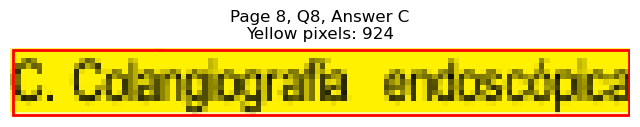

Page 8, Q8 - D: Detected box: x0=322.9, y0=663.5, x1=443.8, y1=675.6
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 639
Page 8, Q8, D: Yellow percentage: 0.0%


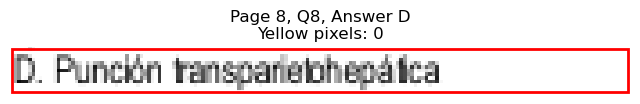

Page 8, Q8 - E: Detected box: x0=322.9, y0=676.3, x1=377.0, y1=688.3
Page 8, Q8, E: Yellow pixels: 0
Page 8, Q8, E: Total non-white pixels: 468
Page 8, Q8, E: Yellow percentage: 0.0%


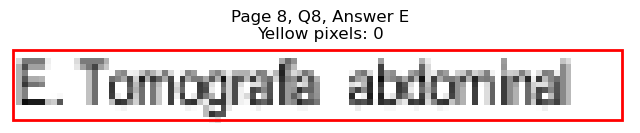


Page 8, Q8 - Selected Answer: C (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=82.6, y0=724.3, x1=154.8, y1=736.4
Page 8, Q9, A: Yellow pixels: 542
Page 8, Q9, A: Total non-white pixels: 924
Page 8, Q9, A: Yellow percentage: 58.7%


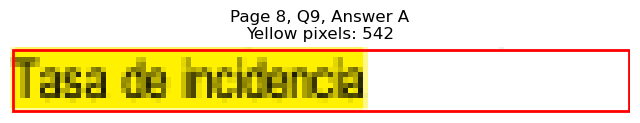

Page 8, Q9 - B: Detected box: x0=71.3, y0=736.4, x1=145.0, y1=748.4
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 465
Page 8, Q9, B: Yellow percentage: 0.0%


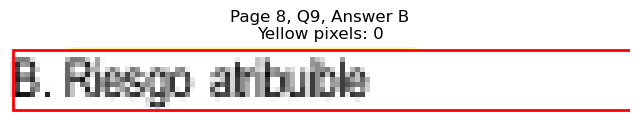

Page 8, Q9 - C: Detected box: x0=71.3, y0=748.4, x1=160.0, y1=760.4
Page 8, Q9, C: Yellow pixels: 0
Page 8, Q9, C: Total non-white pixels: 413
Page 8, Q9, C: Yellow percentage: 0.0%


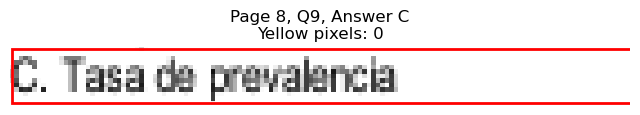

Page 8, Q9 - D: Detected box: x0=322.9, y0=724.3, x1=374.0, y1=736.4
Page 8, Q9, D: Yellow pixels: 0
Page 8, Q9, D: Total non-white pixels: 246
Page 8, Q9, D: Yellow percentage: 0.0%


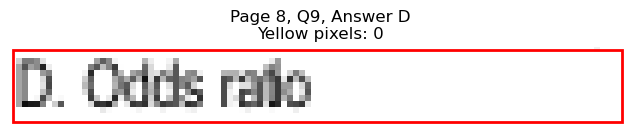

Page 8, Q9 - E: Detected box: x0=322.9, y0=736.4, x1=388.4, y1=748.4
Page 8, Q9, E: Yellow pixels: 0
Page 8, Q9, E: Total non-white pixels: 331
Page 8, Q9, E: Yellow percentage: 0.0%


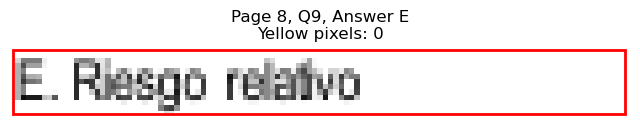


Page 8, Q9 - Selected Answer: A (based on yellow pixel count)





Page 9: Found 9 questions
Page 9, Q1 - A: Detected box: x0=82.6, y0=121.5, x1=115.0, y1=133.6
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 157
Page 9, Q1, A: Yellow percentage: 0.0%


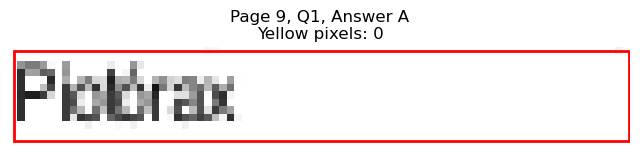

Page 9, Q1 - B: Detected box: x0=71.3, y0=133.5, x1=121.7, y1=145.6
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 245
Page 9, Q1, B: Yellow percentage: 0.0%


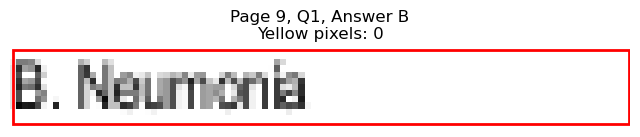

Page 9, Q1 - C: Detected box: x0=71.3, y0=145.6, x1=119.5, y1=157.6
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 211
Page 9, Q1, C: Yellow percentage: 0.0%


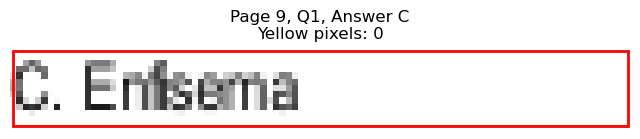

Page 9, Q1 - D: Detected box: x0=322.9, y0=121.5, x1=381.5, y1=133.6
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 280
Page 9, Q1, D: Yellow percentage: 0.0%


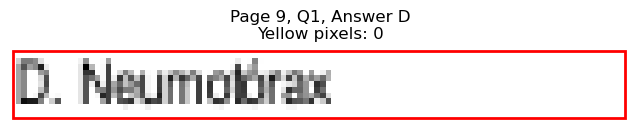

Page 9, Q1 - E: Detected box: x0=322.9, y0=133.5, x1=374.9, y1=145.6
Page 9, Q1, E: Yellow pixels: 381
Page 9, Q1, E: Total non-white pixels: 663
Page 9, Q1, E: Yellow percentage: 57.5%


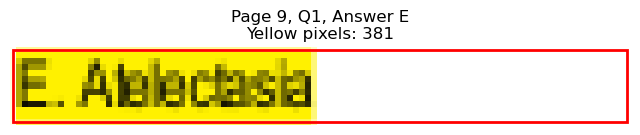


Page 9, Q1 - Selected Answer: E (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=82.6, y0=181.6, x1=149.6, y1=193.6
Page 9, Q2, A: Yellow pixels: 506
Page 9, Q2, A: Total non-white pixels: 860
Page 9, Q2, A: Yellow percentage: 58.8%


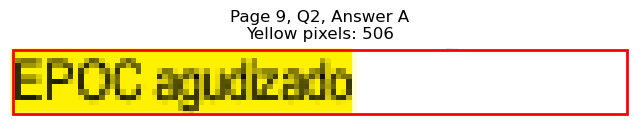

Page 9, Q2 - B: Detected box: x0=71.3, y0=193.6, x1=204.2, y1=205.6
Page 9, Q2, B: Yellow pixels: 64
Page 9, Q2, B: Total non-white pixels: 694
Page 9, Q2, B: Yellow percentage: 9.2%


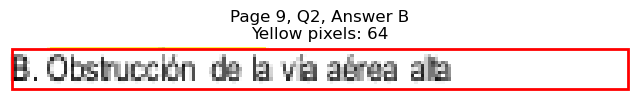

Page 9, Q2 - C: Detected box: x0=71.3, y0=205.6, x1=188.5, y1=217.7
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 587
Page 9, Q2, C: Yellow percentage: 0.0%


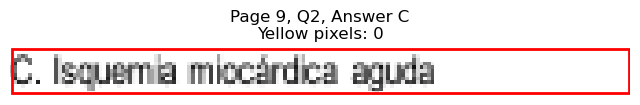

Page 9, Q2 - D: Detected box: x0=322.9, y0=181.6, x1=380.8, y1=193.6
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 564
Page 9, Q2, D: Yellow percentage: 0.0%


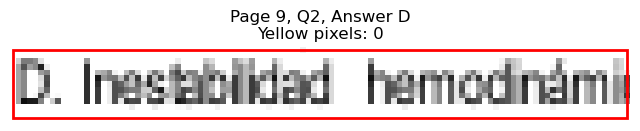

Page 9, Q2 - E: Detected box: x0=322.9, y0=193.6, x1=424.2, y1=205.6
Page 9, Q2, E: Yellow pixels: 0
Page 9, Q2, E: Total non-white pixels: 487
Page 9, Q2, E: Yellow percentage: 0.0%


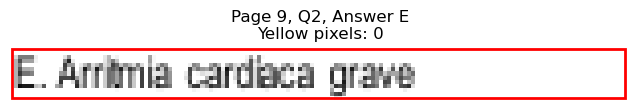


Page 9, Q2 - Selected Answer: A (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=82.6, y0=277.7, x1=127.0, y1=289.7
Page 9, Q3, A: Yellow pixels: 323
Page 9, Q3, A: Total non-white pixels: 559
Page 9, Q3, A: Yellow percentage: 57.8%


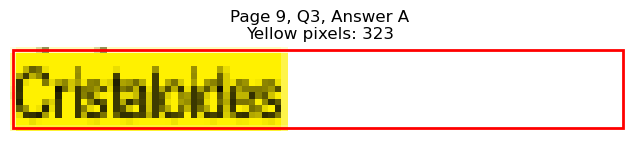

Page 9, Q3 - B: Detected box: x0=71.3, y0=289.7, x1=115.7, y1=301.8
Page 9, Q3, B: Yellow pixels: 42
Page 9, Q3, B: Total non-white pixels: 260
Page 9, Q3, B: Yellow percentage: 16.2%


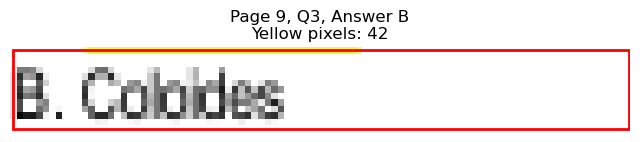

Page 9, Q3 - C: Detected box: x0=71.3, y0=302.5, x1=148.0, y1=314.5
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 365
Page 9, Q3, C: Yellow percentage: 0.0%


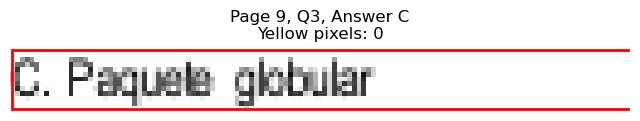

Page 9, Q3 - D: Detected box: x0=322.9, y0=277.7, x1=375.5, y1=289.7
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 257
Page 9, Q3, D: Yellow percentage: 0.0%


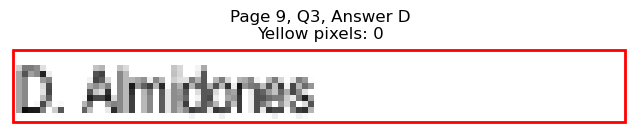

Page 9, Q3 - E: Detected box: x0=322.9, y0=289.7, x1=364.2, y1=301.8
Page 9, Q3, E: Yellow pixels: 0
Page 9, Q3, E: Total non-white pixels: 191
Page 9, Q3, E: Yellow percentage: 0.0%


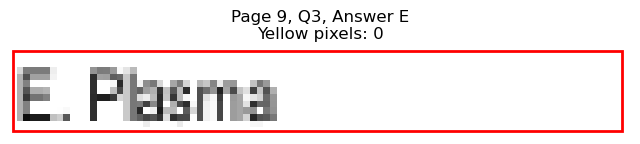


Page 9, Q3 - Selected Answer: A (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=82.6, y0=350.5, x1=145.0, y1=362.5
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 313
Page 9, Q4, A: Yellow percentage: 0.0%


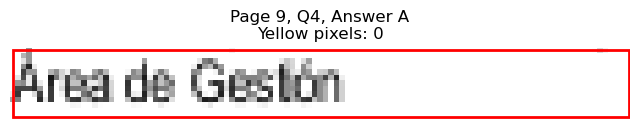

Page 9, Q4 - B: Detected box: x0=71.3, y0=362.5, x1=160.7, y1=374.6
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 664
Page 9, Q4, B: Yellow percentage: 0.0%


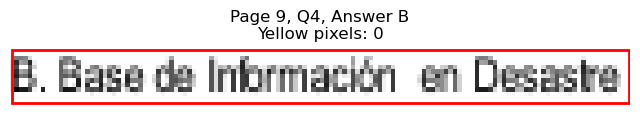

Page 9, Q4 - C: Detected box: x0=71.3, y0=374.5, x1=179.5, y1=386.6
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 489
Page 9, Q4, C: Yellow percentage: 0.0%


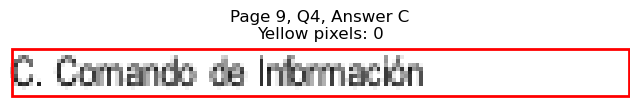

Page 9, Q4 - D: Detected box: x0=322.9, y0=350.5, x1=404.8, y1=362.5
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 403
Page 9, Q4, D: Yellow percentage: 0.0%


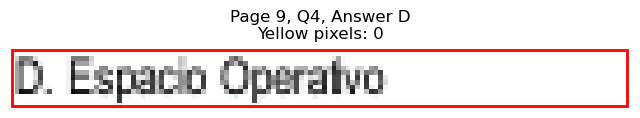

Page 9, Q4 - E: Detected box: x0=322.9, y0=362.5, x1=400.3, y1=374.6
Page 9, Q4, E: Yellow pixels: 1021
Page 9, Q4, E: Total non-white pixels: 1495
Page 9, Q4, E: Yellow percentage: 68.3%


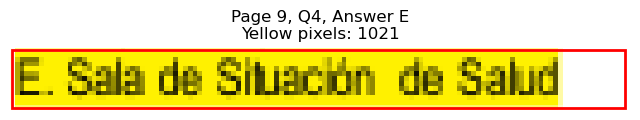


Page 9, Q4 - Selected Answer: E (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=82.6, y0=410.5, x1=139.8, y1=422.6
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 294
Page 9, Q5, A: Yellow percentage: 0.0%


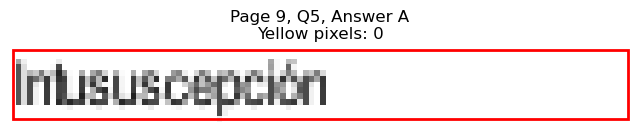

Page 9, Q5 - B: Detected box: x0=71.3, y0=422.5, x1=163.1, y1=434.6
Page 9, Q5, B: Yellow pixels: 718
Page 9, Q5, B: Total non-white pixels: 1170
Page 9, Q5, B: Yellow percentage: 61.4%


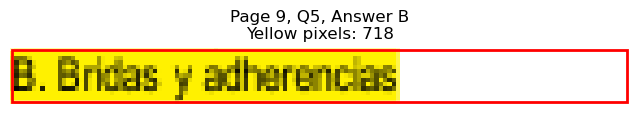

Page 9, Q5 - C: Detected box: x0=71.3, y0=434.6, x1=165.2, y1=446.6
Page 9, Q5, C: Yellow pixels: 90
Page 9, Q5, C: Total non-white pixels: 543
Page 9, Q5, C: Yellow percentage: 16.6%


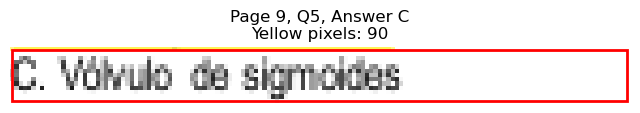

Page 9, Q5 - D: Detected box: x0=322.9, y0=410.5, x1=423.5, y1=422.6
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 485
Page 9, Q5, D: Yellow percentage: 0.0%


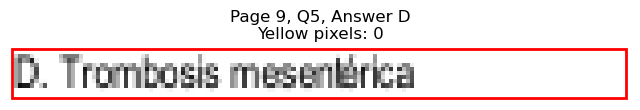

Page 9, Q5 - E: Detected box: x0=322.9, y0=422.5, x1=397.3, y1=434.6
Page 9, Q5, E: Yellow pixels: 0
Page 9, Q5, E: Total non-white pixels: 339
Page 9, Q5, E: Yellow percentage: 0.0%


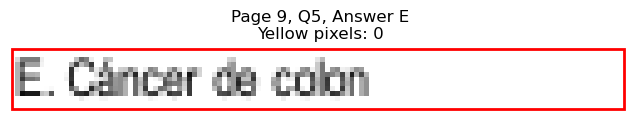


Page 9, Q5 - Selected Answer: B (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=124.6, y0=483.4, x1=164.6, y1=495.4
Page 9, Q6, A: Yellow pixels: 317
Page 9, Q6, A: Total non-white pixels: 507
Page 9, Q6, A: Yellow percentage: 62.5%


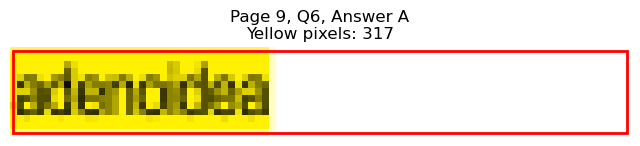

Page 9, Q6 - B: Detected box: x0=71.3, y0=495.4, x1=114.2, y1=507.4
Page 9, Q6, B: Yellow pixels: 79
Page 9, Q6, B: Total non-white pixels: 295
Page 9, Q6, B: Yellow percentage: 26.8%


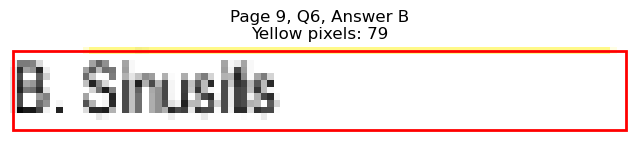

Page 9, Q6 - C: Detected box: x0=71.3, y0=507.4, x1=136.7, y1=519.4
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 311
Page 9, Q6, C: Yellow percentage: 0.0%


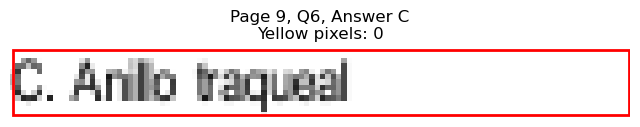

Page 9, Q6 - D: Detected box: x0=322.9, y0=483.4, x1=392.9, y1=495.4
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 351
Page 9, Q6, D: Yellow percentage: 0.0%


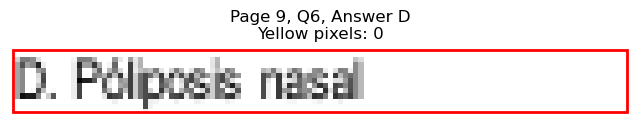

Page 9, Q6 - E: Detected box: x0=322.9, y0=495.4, x1=419.8, y1=507.4
Page 9, Q6, E: Yellow pixels: 0
Page 9, Q6, E: Total non-white pixels: 598
Page 9, Q6, E: Yellow percentage: 0.0%


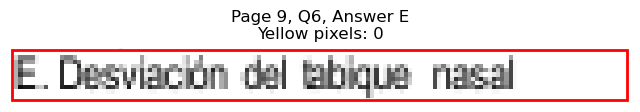


Page 9, Q6 - Selected Answer: A (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=82.6, y0=555.4, x1=147.2, y1=567.5
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 362
Page 9, Q7, A: Yellow percentage: 0.0%


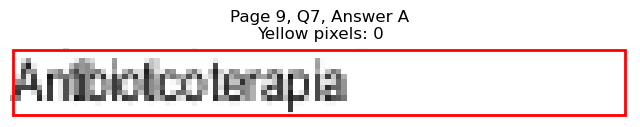

Page 9, Q7 - B: Detected box: x0=112.6, y0=567.5, x1=169.0, y1=579.5
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 279
Page 9, Q7, B: Yellow percentage: 0.0%


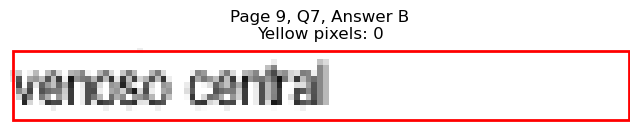

Page 9, Q7 - C: Detected box: x0=71.3, y0=579.4, x1=121.8, y1=591.5
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 517
Page 9, Q7, C: Yellow percentage: 0.0%


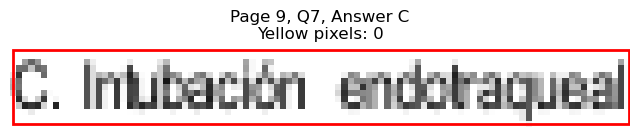

Page 9, Q7 - D: Detected box: x0=322.9, y0=555.4, x1=396.5, y1=567.5
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 334
Page 9, Q7, D: Yellow percentage: 0.0%


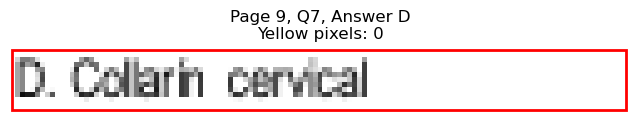

Page 9, Q7 - E: Detected box: x0=322.9, y0=567.5, x1=414.7, y1=579.5
Page 9, Q7, E: Yellow pixels: 802
Page 9, Q7, E: Total non-white pixels: 1183
Page 9, Q7, E: Yellow percentage: 67.8%


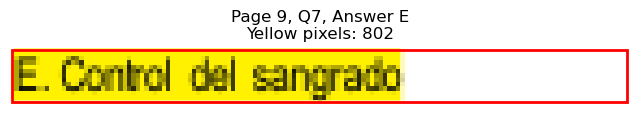


Page 9, Q7 - Selected Answer: E (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=82.6, y0=627.5, x1=115.0, y1=639.6
Page 9, Q8, A: Yellow pixels: 246
Page 9, Q8, A: Total non-white pixels: 405
Page 9, Q8, A: Yellow percentage: 60.7%


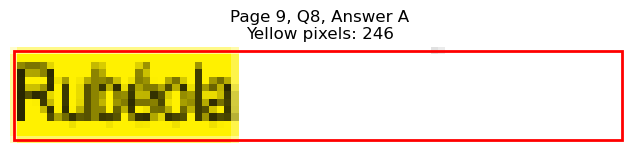

Page 9, Q8 - B: Detected box: x0=71.3, y0=639.5, x1=102.2, y1=651.6
Page 9, Q8, B: Yellow pixels: 30
Page 9, Q8, B: Total non-white pixels: 190
Page 9, Q8, B: Yellow percentage: 15.8%


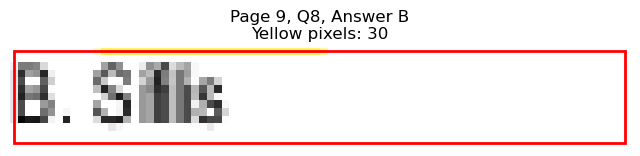

Page 9, Q8 - C: Detected box: x0=71.3, y0=651.5, x1=112.0, y1=663.6
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 172
Page 9, Q8, C: Yellow percentage: 0.0%


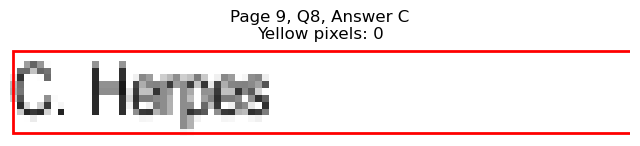

Page 9, Q8 - D: Detected box: x0=322.9, y0=627.5, x1=392.8, y1=639.6
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 329
Page 9, Q8, D: Yellow percentage: 0.0%


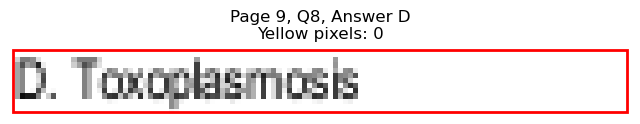

Page 9, Q8 - E: Detected box: x0=322.9, y0=639.5, x1=394.3, y1=651.6
Page 9, Q8, E: Yellow pixels: 0
Page 9, Q8, E: Total non-white pixels: 359
Page 9, Q8, E: Yellow percentage: 0.0%


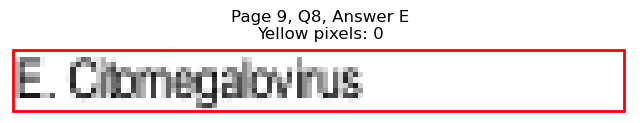


Page 9, Q8 - Selected Answer: A (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=133.6, y0=712.3, x1=184.0, y1=724.4
Page 9, Q9, A: Yellow pixels: 0
Page 9, Q9, A: Total non-white pixels: 270
Page 9, Q9, A: Yellow percentage: 0.0%


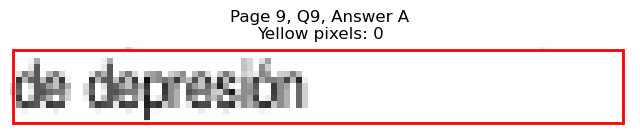

Page 9, Q9 - B: Detected box: x0=71.3, y0=724.3, x1=193.1, y1=736.4
Page 9, Q9, B: Yellow pixels: 979
Page 9, Q9, B: Total non-white pixels: 1560
Page 9, Q9, B: Yellow percentage: 62.8%


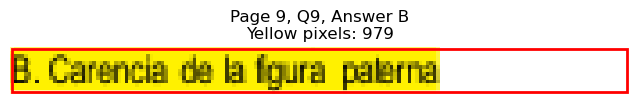

Page 9, Q9 - C: Detected box: x0=71.3, y0=736.4, x1=174.2, y1=748.4
Page 9, Q9, C: Yellow pixels: 3
Page 9, Q9, C: Total non-white pixels: 607
Page 9, Q9, C: Yellow percentage: 0.5%


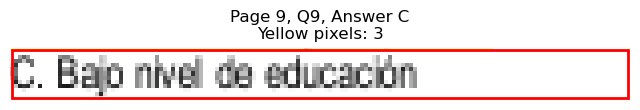

Page 9, Q9 - D: Detected box: x0=322.9, y0=712.3, x1=381.5, y1=724.4
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 522
Page 9, Q9, D: Yellow percentage: 0.0%


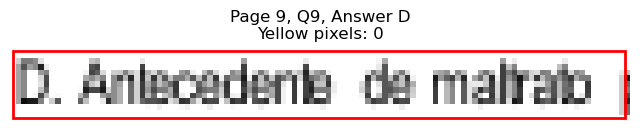

Page 9, Q9 - E: Detected box: x0=322.9, y0=724.3, x1=400.4, y1=736.4
Page 9, Q9, E: Yellow pixels: 0
Page 9, Q9, E: Total non-white pixels: 350
Page 9, Q9, E: Yellow percentage: 0.0%


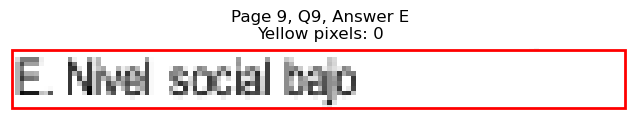


Page 9, Q9 - Selected Answer: B (based on yellow pixel count)





Page 10: Found 9 questions
Page 10, Q1 - A: Detected box: x0=82.6, y0=121.5, x1=137.5, y1=133.6
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 280
Page 10, Q1, A: Yellow percentage: 0.0%


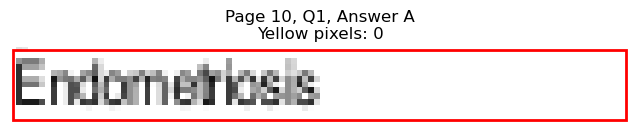

Page 10, Q1 - B: Detected box: x0=71.3, y0=133.5, x1=174.2, y1=145.6
Page 10, Q1, B: Yellow pixels: 1042
Page 10, Q1, B: Total non-white pixels: 1729
Page 10, Q1, B: Yellow percentage: 60.3%


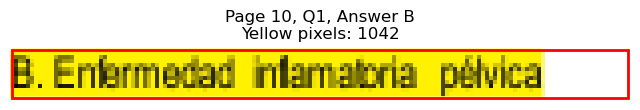

Page 10, Q1 - C: Detected box: x0=71.3, y0=145.6, x1=162.2, y1=157.6
Page 10, Q1, C: Yellow pixels: 132
Page 10, Q1, C: Total non-white pixels: 588
Page 10, Q1, C: Yellow percentage: 22.4%


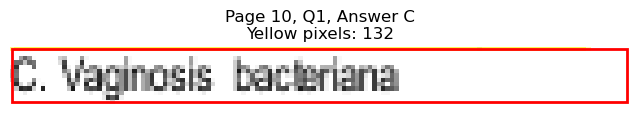

Page 10, Q1 - D: Detected box: x0=322.9, y0=121.5, x1=365.8, y1=133.6
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 365
Page 10, Q1, D: Yellow percentage: 0.0%


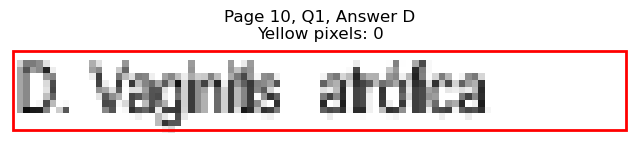

Page 10, Q1 - E: Detected box: x0=322.9, y0=133.5, x1=377.8, y1=145.6
Page 10, Q1, E: Yellow pixels: 0
Page 10, Q1, E: Total non-white pixels: 439
Page 10, Q1, E: Yellow percentage: 0.0%


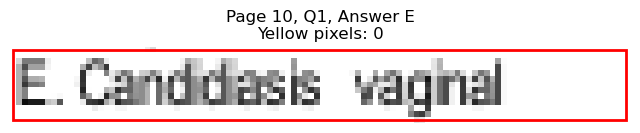


Page 10, Q1 - Selected Answer: B (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=82.6, y0=181.6, x1=258.9, y1=193.6
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 886
Page 10, Q2, A: Yellow percentage: 0.0%


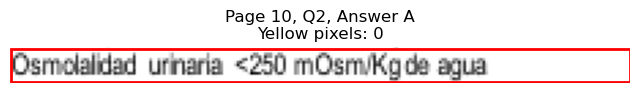

Page 10, Q2 - B: Detected box: x0=71.3, y0=193.6, x1=208.1, y1=205.6
Page 10, Q2, B: Yellow pixels: 1118
Page 10, Q2, B: Total non-white pixels: 1759
Page 10, Q2, B: Yellow percentage: 63.6%


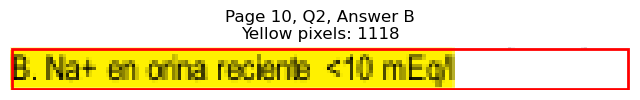

Page 10, Q2 - C: Detected box: x0=71.3, y0=205.6, x1=203.4, y1=217.7
Page 10, Q2, C: Yellow pixels: 135
Page 10, Q2, C: Total non-white pixels: 727
Page 10, Q2, C: Yellow percentage: 18.6%


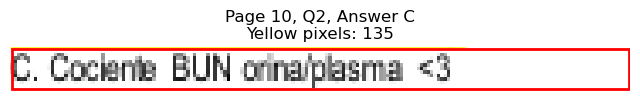

Page 10, Q2 - D: Detected box: x0=322.9, y0=181.6, x1=431.8, y1=193.6
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 499
Page 10, Q2, D: Yellow percentage: 0.0%


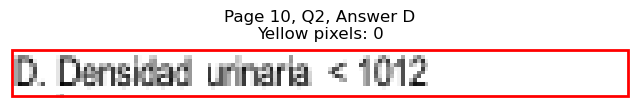

Page 10, Q2 - E: Detected box: x0=322.9, y0=193.6, x1=425.0, y1=205.6
Page 10, Q2, E: Yellow pixels: 0
Page 10, Q2, E: Total non-white pixels: 447
Page 10, Q2, E: Yellow percentage: 0.0%


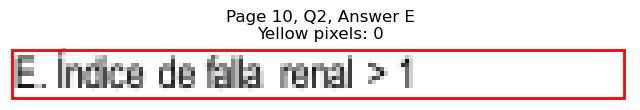


Page 10, Q2 - Selected Answer: B (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=82.6, y0=277.7, x1=230.5, y1=289.7
Page 10, Q3, A: Yellow pixels: 0
Page 10, Q3, A: Total non-white pixels: 716
Page 10, Q3, A: Yellow percentage: 0.0%


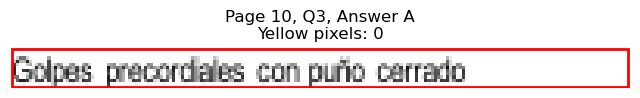

Page 10, Q3 - B: Detected box: x0=71.3, y0=289.7, x1=138.2, y1=301.8
Page 10, Q3, B: Yellow pixels: 0
Page 10, Q3, B: Total non-white pixels: 588
Page 10, Q3, B: Yellow percentage: 0.0%


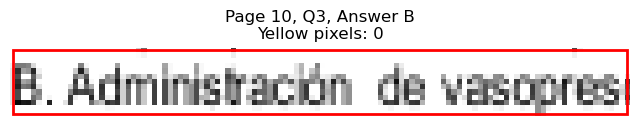

Page 10, Q3 - C: Detected box: x0=71.3, y0=302.5, x1=133.0, y1=314.5
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 508
Page 10, Q3, C: Yellow percentage: 0.0%


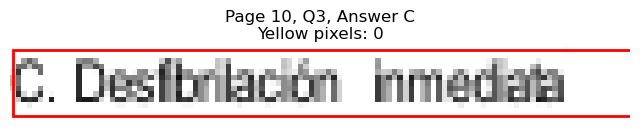

Page 10, Q3 - D: Detected box: x0=322.9, y0=277.7, x1=425.1, y1=289.7
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 501
Page 10, Q3, D: Yellow percentage: 0.0%


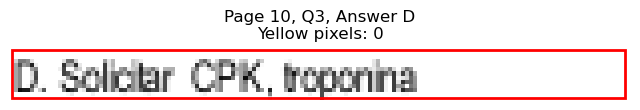

Page 10, Q3 - E: Detected box: x0=322.9, y0=289.7, x1=443.2, y1=301.8
Page 10, Q3, E: Yellow pixels: 915
Page 10, Q3, E: Total non-white pixels: 1547
Page 10, Q3, E: Yellow percentage: 59.1%


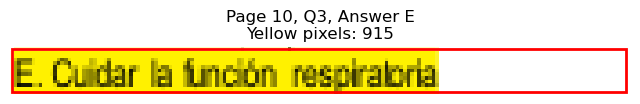


Page 10, Q3 - Selected Answer: E (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=82.6, y0=362.5, x1=161.5, y1=374.6
Page 10, Q4, A: Yellow pixels: 0
Page 10, Q4, A: Total non-white pixels: 396
Page 10, Q4, A: Yellow percentage: 0.0%


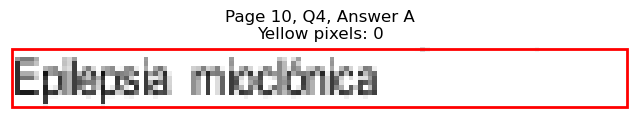

Page 10, Q4 - B: Detected box: x0=71.3, y0=374.5, x1=193.8, y1=386.6
Page 10, Q4, B: Yellow pixels: 0
Page 10, Q4, B: Total non-white pixels: 591
Page 10, Q4, B: Yellow percentage: 0.0%


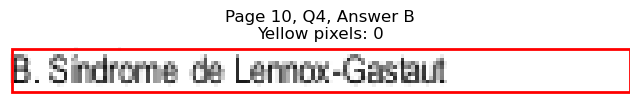

Page 10, Q4 - C: Detected box: x0=71.3, y0=386.5, x1=155.4, y1=398.6
Page 10, Q4, C: Yellow pixels: 0
Page 10, Q4, C: Total non-white pixels: 391
Page 10, Q4, C: Yellow percentage: 0.0%


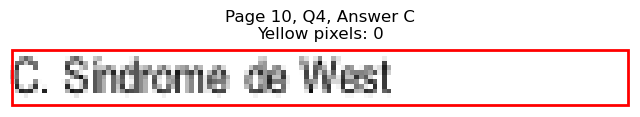

Page 10, Q4 - D: Detected box: x0=322.9, y0=362.5, x1=405.6, y1=374.6
Page 10, Q4, D: Yellow pixels: 712
Page 10, Q4, D: Total non-white pixels: 1066
Page 10, Q4, D: Yellow percentage: 66.8%


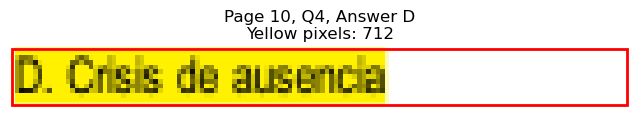

Page 10, Q4 - E: Detected box: x0=322.9, y0=374.5, x1=368.8, y1=386.6
Page 10, Q4, E: Yellow pixels: 80
Page 10, Q4, E: Total non-white pixels: 419
Page 10, Q4, E: Yellow percentage: 19.1%


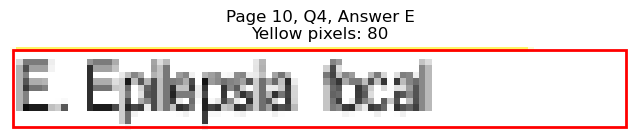


Page 10, Q4 - Selected Answer: D (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=82.6, y0=422.5, x1=130.0, y1=434.6
Page 10, Q5, A: Yellow pixels: 0
Page 10, Q5, A: Total non-white pixels: 475
Page 10, Q5, A: Yellow percentage: 0.0%


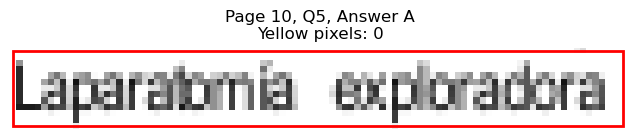

Page 10, Q5 - B: Detected box: x0=141.0, y0=434.6, x1=209.4, y1=446.6
Page 10, Q5, B: Yellow pixels: 0
Page 10, Q5, B: Total non-white pixels: 368
Page 10, Q5, B: Yellow percentage: 0.0%


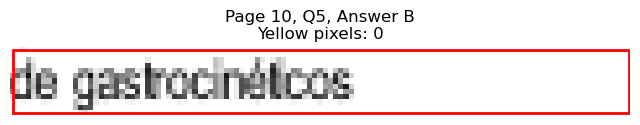

Page 10, Q5 - C: Detected box: x0=71.3, y0=446.6, x1=159.3, y1=458.6
Page 10, Q5, C: Yellow pixels: 698
Page 10, Q5, C: Total non-white pixels: 1118
Page 10, Q5, C: Yellow percentage: 62.4%


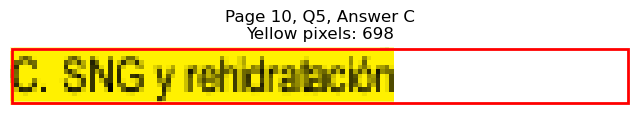

Page 10, Q5 - D: Detected box: x0=322.9, y0=422.5, x1=409.3, y1=434.6
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 676
Page 10, Q5, D: Yellow percentage: 0.0%


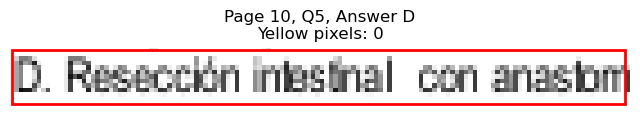

Page 10, Q5 - E: Detected box: x0=322.9, y0=434.6, x1=440.0, y1=446.6
Page 10, Q5, E: Yellow pixels: 0
Page 10, Q5, E: Total non-white pixels: 597
Page 10, Q5, E: Yellow percentage: 0.0%


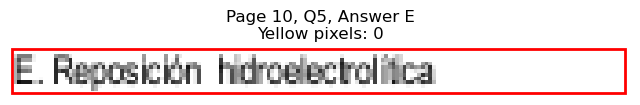


Page 10, Q5 - Selected Answer: C (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=82.6, y0=507.4, x1=164.6, y1=519.4
Page 10, Q6, A: Yellow pixels: 691
Page 10, Q6, A: Total non-white pixels: 1053
Page 10, Q6, A: Yellow percentage: 65.6%


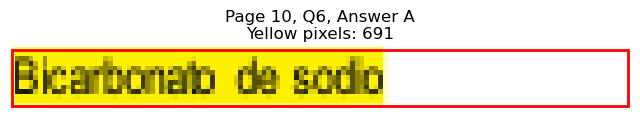

Page 10, Q6 - B: Detected box: x0=71.3, y0=519.4, x1=130.0, y1=531.4
Page 10, Q6, B: Yellow pixels: 79
Page 10, Q6, B: Total non-white pixels: 393
Page 10, Q6, B: Yellow percentage: 20.1%


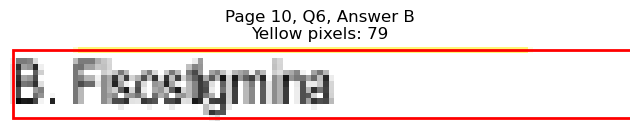

Page 10, Q6 - C: Detected box: x0=71.3, y0=531.4, x1=131.5, y1=543.5
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 358
Page 10, Q6, C: Yellow percentage: 0.0%


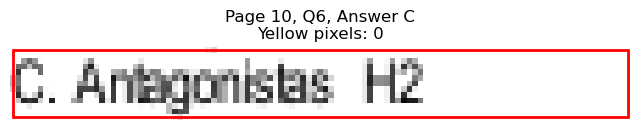

Page 10, Q6 - D: Detected box: x0=322.9, y0=507.4, x1=371.0, y1=519.4
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 238
Page 10, Q6, D: Yellow percentage: 0.0%


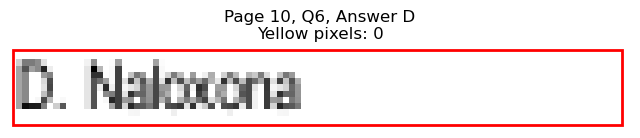

Page 10, Q6 - E: Detected box: x0=322.9, y0=519.4, x1=372.5, y1=531.4
Page 10, Q6, E: Yellow pixels: 0
Page 10, Q6, E: Total non-white pixels: 412
Page 10, Q6, E: Yellow percentage: 0.0%


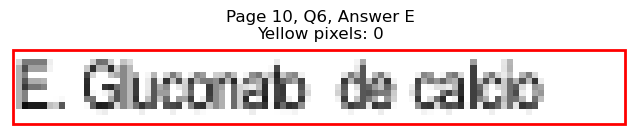


Page 10, Q6 - Selected Answer: A (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=82.6, y0=567.5, x1=120.2, y1=579.5
Page 10, Q7, A: Yellow pixels: 0
Page 10, Q7, A: Total non-white pixels: 174
Page 10, Q7, A: Yellow percentage: 0.0%


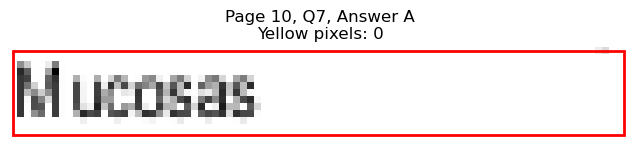

Page 10, Q7 - B: Detected box: x0=71.3, y0=579.4, x1=123.2, y1=591.5
Page 10, Q7, B: Yellow pixels: 0
Page 10, Q7, B: Total non-white pixels: 248
Page 10, Q7, B: Yellow percentage: 0.0%


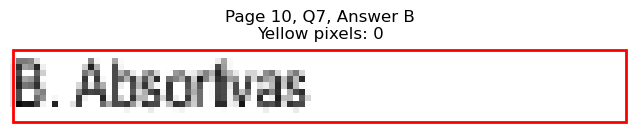

Page 10, Q7 - C: Detected box: x0=71.3, y0=591.5, x1=127.0, y1=603.5
Page 10, Q7, C: Yellow pixels: 0
Page 10, Q7, C: Total non-white pixels: 261
Page 10, Q7, C: Yellow percentage: 0.0%


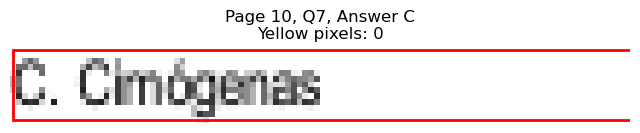

Page 10, Q7 - D: Detected box: x0=322.9, y0=567.5, x1=372.6, y1=579.5
Page 10, Q7, D: Yellow pixels: 412
Page 10, Q7, D: Total non-white pixels: 637
Page 10, Q7, D: Yellow percentage: 64.7%


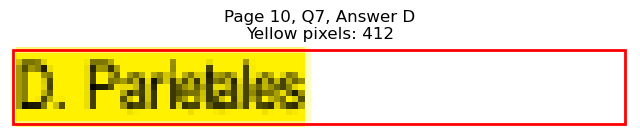

Page 10, Q7 - E: Detected box: x0=322.9, y0=579.4, x1=380.0, y1=591.5
Page 10, Q7, E: Yellow pixels: 47
Page 10, Q7, E: Total non-white pixels: 341
Page 10, Q7, E: Yellow percentage: 13.8%


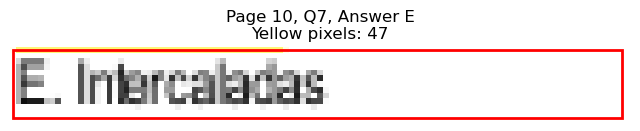


Page 10, Q7 - Selected Answer: D (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=82.6, y0=639.5, x1=167.5, y1=651.6
Page 10, Q8, A: Yellow pixels: 0
Page 10, Q8, A: Total non-white pixels: 407
Page 10, Q8, A: Yellow percentage: 0.0%


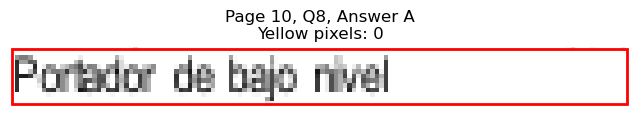

Page 10, Q8 - B: Detected box: x0=71.3, y0=651.5, x1=142.7, y1=663.6
Page 10, Q8, B: Yellow pixels: 0
Page 10, Q8, B: Total non-white pixels: 359
Page 10, Q8, B: Yellow percentage: 0.0%


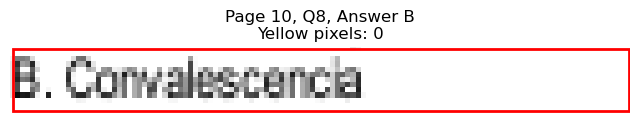

Page 10, Q8 - C: Detected box: x0=71.3, y0=663.5, x1=115.0, y1=675.6
Page 10, Q8, C: Yellow pixels: 618
Page 10, Q8, C: Total non-white pixels: 1014
Page 10, Q8, C: Yellow percentage: 60.9%


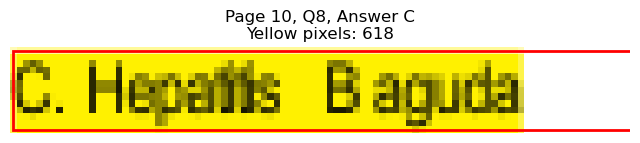

Page 10, Q8 - D: Detected box: x0=322.9, y0=639.5, x1=418.3, y1=651.6
Page 10, Q8, D: Yellow pixels: 0
Page 10, Q8, D: Total non-white pixels: 454
Page 10, Q8, D: Yellow percentage: 0.0%


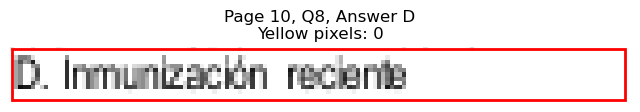

Page 10, Q8 - E: Detected box: x0=322.9, y0=651.5, x1=365.8, y1=663.6
Page 10, Q8, E: Yellow pixels: 0
Page 10, Q8, E: Total non-white pixels: 402
Page 10, Q8, E: Yellow percentage: 0.0%


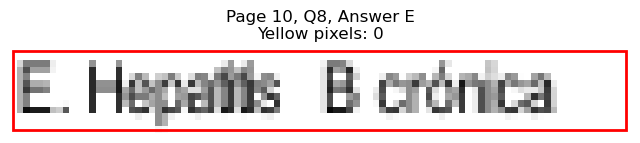


Page 10, Q8 - Selected Answer: C (based on yellow pixel count)




Page 10, Q9 - A: Detected box: x0=82.6, y0=700.3, x1=133.0, y1=712.3
Page 10, Q9, A: Yellow pixels: 0
Page 10, Q9, A: Total non-white pixels: 493
Page 10, Q9, A: Yellow percentage: 0.0%


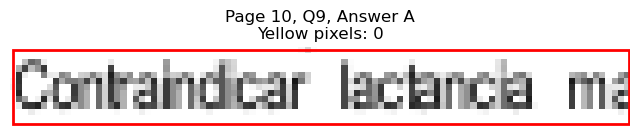

Page 10, Q9 - B: Detected box: x0=71.3, y0=712.3, x1=162.2, y1=724.4
Page 10, Q9, B: Yellow pixels: 0
Page 10, Q9, B: Total non-white pixels: 472
Page 10, Q9, B: Yellow percentage: 0.0%


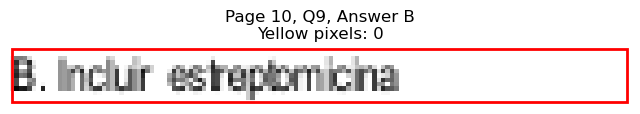

Page 10, Q9 - C: Detected box: x0=71.3, y0=724.3, x1=148.0, y1=736.4
Page 10, Q9, C: Yellow pixels: 0
Page 10, Q9, C: Total non-white pixels: 482
Page 10, Q9, C: Yellow percentage: 0.0%


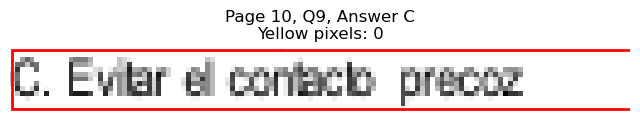

Page 10, Q9 - D: Detected box: x0=322.9, y0=700.3, x1=394.3, y1=712.3
Page 10, Q9, D: Yellow pixels: 0
Page 10, Q9, D: Total non-white pixels: 338
Page 10, Q9, D: Yellow percentage: 0.0%


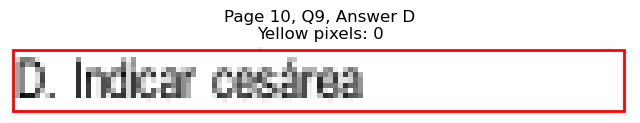

Page 10, Q9 - E: Detected box: x0=322.9, y0=712.3, x1=413.9, y1=724.4
Page 10, Q9, E: Yellow pixels: 704
Page 10, Q9, E: Total non-white pixels: 1196
Page 10, Q9, E: Yellow percentage: 58.9%


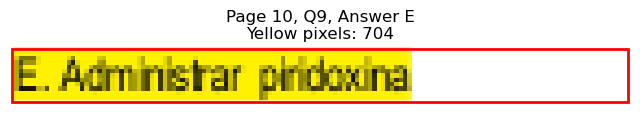


Page 10, Q9 - Selected Answer: E (based on yellow pixel count)





Page 11: Found 9 questions
Page 11, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=182.5, y1=108.8
Page 11, Q1, A: Yellow pixels: 0
Page 11, Q1, A: Total non-white pixels: 630
Page 11, Q1, A: Yellow percentage: 0.0%


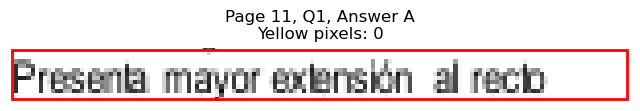

Page 11, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=167.4, y1=121.6
Page 11, Q1, B: Yellow pixels: 0
Page 11, Q1, B: Total non-white pixels: 451
Page 11, Q1, B: Yellow percentage: 0.0%


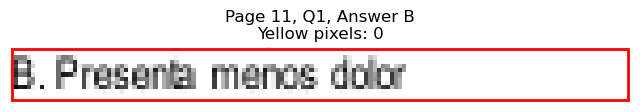

Page 11, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=256.2, y1=133.6
Page 11, Q1, C: Yellow pixels: 1654
Page 11, Q1, C: Total non-white pixels: 2379
Page 11, Q1, C: Yellow percentage: 69.5%


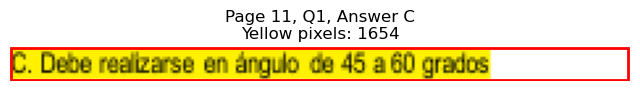

Page 11, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=514.3, y1=108.8
Page 11, Q1, D: Yellow pixels: 0
Page 11, Q1, D: Total non-white pixels: 894
Page 11, Q1, D: Yellow percentage: 0.0%


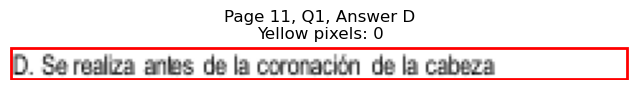

Page 11, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=435.7, y1=121.6
Page 11, Q1, E: Yellow pixels: 0
Page 11, Q1, E: Total non-white pixels: 540
Page 11, Q1, E: Yellow percentage: 0.0%


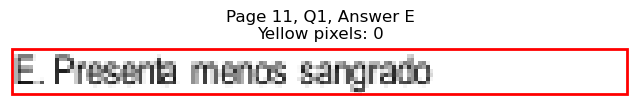


Page 11, Q1 - Selected Answer: C (based on yellow pixel count)




Page 11, Q2 - A: Detected box: x0=82.6, y0=181.6, x1=146.5, y1=193.6
Page 11, Q2, A: Yellow pixels: 0
Page 11, Q2, A: Total non-white pixels: 297
Page 11, Q2, A: Yellow percentage: 0.0%


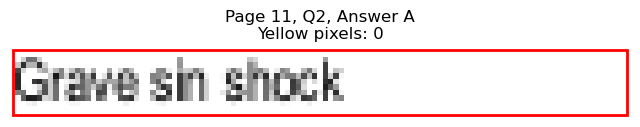

Page 11, Q2 - B: Detected box: x0=71.3, y0=193.6, x1=152.6, y1=205.6
Page 11, Q2, B: Yellow pixels: 656
Page 11, Q2, B: Total non-white pixels: 1040
Page 11, Q2, B: Yellow percentage: 63.1%


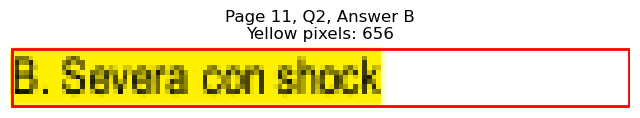

Page 11, Q2 - C: Detected box: x0=71.3, y0=205.6, x1=103.0, y1=217.7
Page 11, Q2, C: Yellow pixels: 79
Page 11, Q2, C: Total non-white pixels: 196
Page 11, Q2, C: Yellow percentage: 40.3%


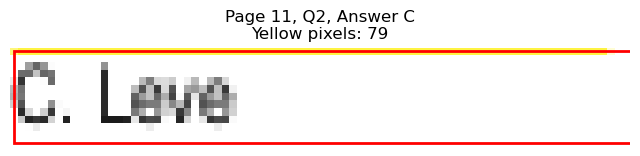

Page 11, Q2 - D: Detected box: x0=322.9, y0=181.6, x1=374.8, y1=193.6
Page 11, Q2, D: Yellow pixels: 0
Page 11, Q2, D: Total non-white pixels: 258
Page 11, Q2, D: Yellow percentage: 0.0%


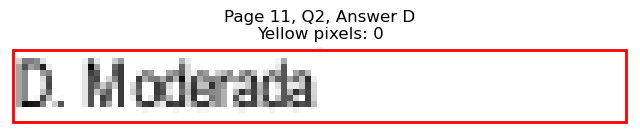

Page 11, Q2 - E: Detected box: x0=322.9, y0=193.6, x1=401.7, y1=205.6
Page 11, Q2, E: Yellow pixels: 0
Page 11, Q2, E: Total non-white pixels: 361
Page 11, Q2, E: Yellow percentage: 0.0%


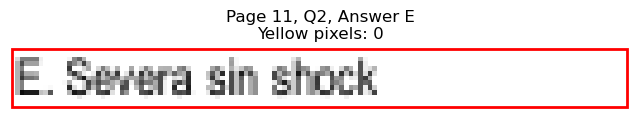


Page 11, Q2 - Selected Answer: B (based on yellow pixel count)




Page 11, Q3 - A: Detected box: x0=71.3, y0=253.6, x1=79.7, y1=265.7
Page 11, Q3, A: Yellow pixels: 24
Page 11, Q3, A: Total non-white pixels: 111
Page 11, Q3, A: Yellow percentage: 21.6%


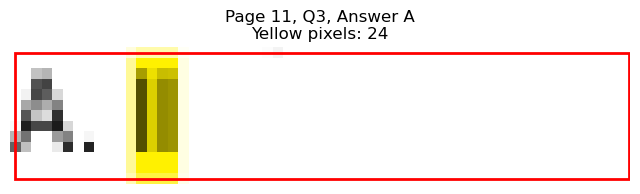

Page 11, Q3 - B: Detected box: x0=71.3, y0=265.7, x1=91.0, y1=277.7
Page 11, Q3, B: Yellow pixels: 4
Page 11, Q3, B: Total non-white pixels: 88
Page 11, Q3, B: Yellow percentage: 4.5%


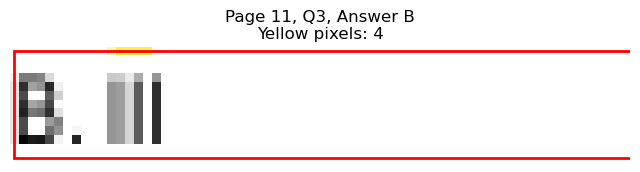

Page 11, Q3 - C: Detected box: x0=71.3, y0=277.7, x1=92.5, y1=289.7
Page 11, Q3, C: Yellow pixels: 0
Page 11, Q3, C: Total non-white pixels: 73
Page 11, Q3, C: Yellow percentage: 0.0%


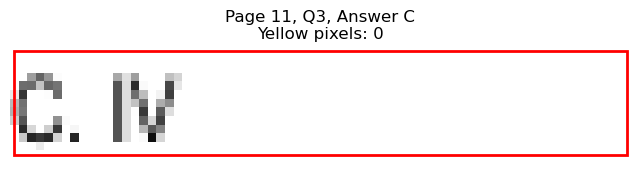

Page 11, Q3 - D: Detected box: x0=322.9, y0=253.6, x1=341.8, y1=265.7
Page 11, Q3, D: Yellow pixels: 0
Page 11, Q3, D: Total non-white pixels: 67
Page 11, Q3, D: Yellow percentage: 0.0%


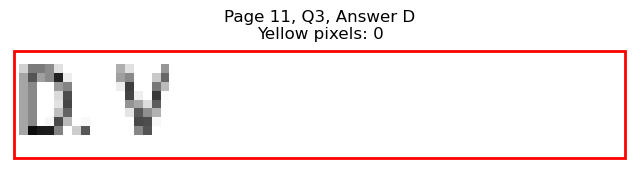

Page 11, Q3 - E: Detected box: x0=322.9, y0=265.7, x1=338.0, y1=277.7
Page 11, Q3, E: Yellow pixels: 0
Page 11, Q3, E: Total non-white pixels: 53
Page 11, Q3, E: Yellow percentage: 0.0%


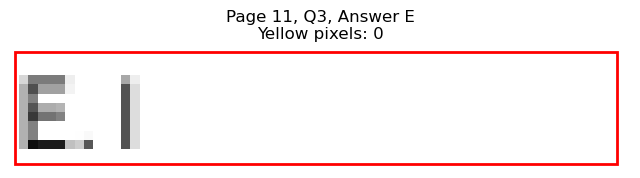


Page 11, Q3 - Selected Answer: A (based on yellow pixel count)




Page 11, Q4 - A: Detected box: x0=82.6, y0=314.5, x1=136.0, y1=326.5
Page 11, Q4, A: Yellow pixels: 0
Page 11, Q4, A: Total non-white pixels: 281
Page 11, Q4, A: Yellow percentage: 0.0%


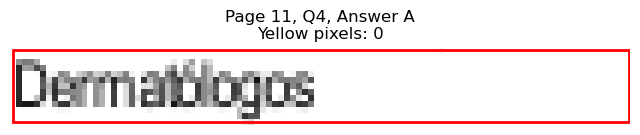

Page 11, Q4 - B: Detected box: x0=71.3, y0=326.5, x1=172.9, y1=338.5
Page 11, Q4, B: Yellow pixels: 864
Page 11, Q4, B: Total non-white pixels: 1300
Page 11, Q4, B: Yellow percentage: 66.5%


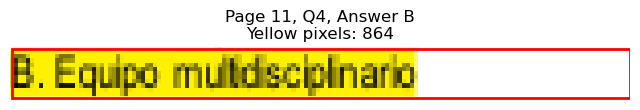

Page 11, Q4 - C: Detected box: x0=71.3, y0=338.5, x1=159.2, y1=350.5
Page 11, Q4, C: Yellow pixels: 99
Page 11, Q4, C: Total non-white pixels: 523
Page 11, Q4, C: Yellow percentage: 18.9%


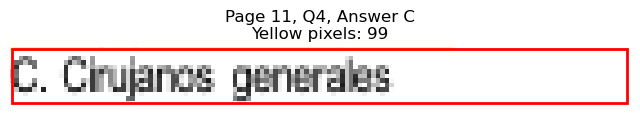

Page 11, Q4 - D: Detected box: x0=322.9, y0=314.5, x1=407.0, y1=326.5
Page 11, Q4, D: Yellow pixels: 0
Page 11, Q4, D: Total non-white pixels: 429
Page 11, Q4, D: Yellow percentage: 0.0%


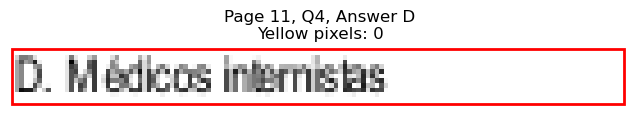

Page 11, Q4 - E: Detected box: x0=322.9, y0=326.5, x1=406.3, y1=338.5
Page 11, Q4, E: Yellow pixels: 0
Page 11, Q4, E: Total non-white pixels: 414
Page 11, Q4, E: Yellow percentage: 0.0%


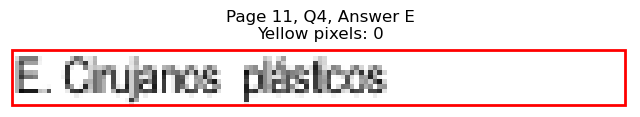


Page 11, Q4 - Selected Answer: B (based on yellow pixel count)




Page 11, Q5 - A: Detected box: x0=82.6, y0=398.5, x1=112.0, y1=410.6
Page 11, Q5, A: Yellow pixels: 234
Page 11, Q5, A: Total non-white pixels: 366
Page 11, Q5, A: Yellow percentage: 63.9%


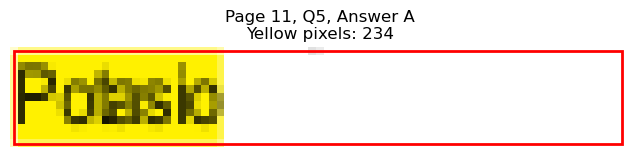

Page 11, Q5 - B: Detected box: x0=71.3, y0=410.5, x1=121.0, y1=422.6
Page 11, Q5, B: Yellow pixels: 27
Page 11, Q5, B: Total non-white pixels: 281
Page 11, Q5, B: Yellow percentage: 9.6%


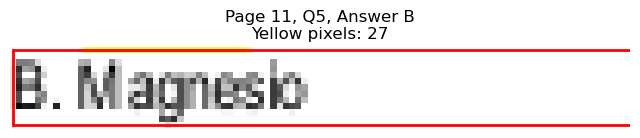

Page 11, Q5 - C: Detected box: x0=71.3, y0=422.5, x1=106.0, y1=434.6
Page 11, Q5, C: Yellow pixels: 0
Page 11, Q5, C: Total non-white pixels: 152
Page 11, Q5, C: Yellow percentage: 0.0%


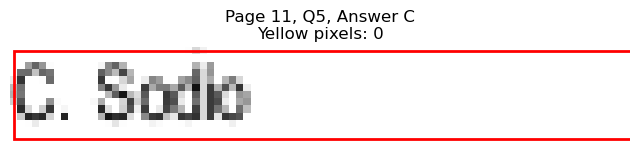

Page 11, Q5 - D: Detected box: x0=322.9, y0=398.5, x1=356.0, y1=410.6
Page 11, Q5, D: Yellow pixels: 0
Page 11, Q5, D: Total non-white pixels: 143
Page 11, Q5, D: Yellow percentage: 0.0%


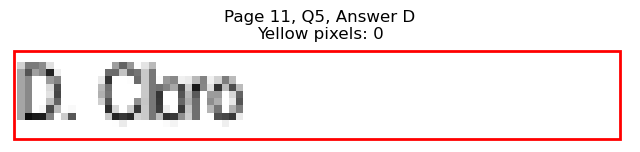

Page 11, Q5 - E: Detected box: x0=322.9, y0=410.5, x1=363.5, y1=422.6
Page 11, Q5, E: Yellow pixels: 0
Page 11, Q5, E: Total non-white pixels: 187
Page 11, Q5, E: Yellow percentage: 0.0%


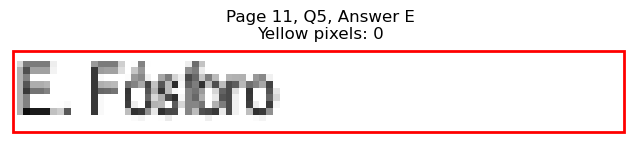


Page 11, Q5 - Selected Answer: A (based on yellow pixel count)




Page 11, Q6 - A: Detected box: x0=82.6, y0=470.6, x1=165.2, y1=482.6
Page 11, Q6, A: Yellow pixels: 0
Page 11, Q6, A: Total non-white pixels: 444
Page 11, Q6, A: Yellow percentage: 0.0%


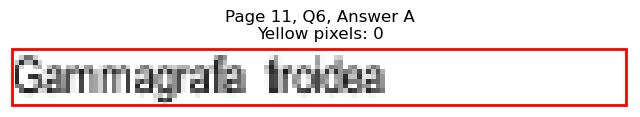

Page 11, Q6 - B: Detected box: x0=71.3, y0=483.4, x1=223.2, y1=495.4
Page 11, Q6, B: Yellow pixels: 1365
Page 11, Q6, B: Total non-white pixels: 1950
Page 11, Q6, B: Yellow percentage: 70.0%


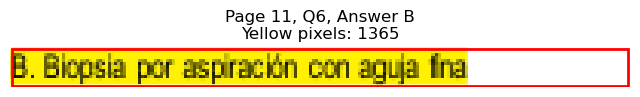

Page 11, Q6 - C: Detected box: x0=71.3, y0=495.4, x1=163.0, y1=507.4
Page 11, Q6, C: Yellow pixels: 141
Page 11, Q6, C: Total non-white pixels: 604
Page 11, Q6, C: Yellow percentage: 23.3%


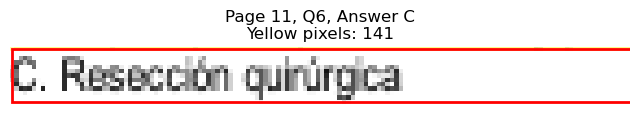

Page 11, Q6 - D: Detected box: x0=322.9, y0=470.6, x1=404.8, y1=482.6
Page 11, Q6, D: Yellow pixels: 0
Page 11, Q6, D: Total non-white pixels: 417
Page 11, Q6, D: Yellow percentage: 0.0%


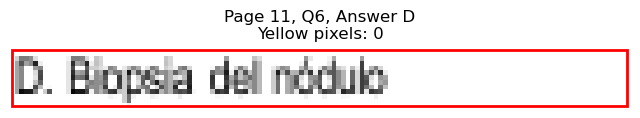

Page 11, Q6 - E: Detected box: x0=322.9, y0=483.4, x1=394.2, y1=495.4
Page 11, Q6, E: Yellow pixels: 0
Page 11, Q6, E: Total non-white pixels: 339
Page 11, Q6, E: Yellow percentage: 0.0%


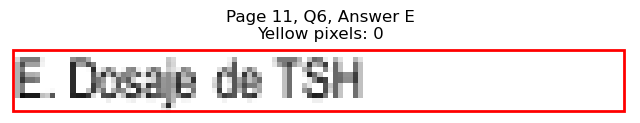


Page 11, Q6 - Selected Answer: B (based on yellow pixel count)




Page 11, Q7 - A: Detected box: x0=82.6, y0=531.4, x1=121.0, y1=543.5
Page 11, Q7, A: Yellow pixels: 0
Page 11, Q7, A: Total non-white pixels: 198
Page 11, Q7, A: Yellow percentage: 0.0%


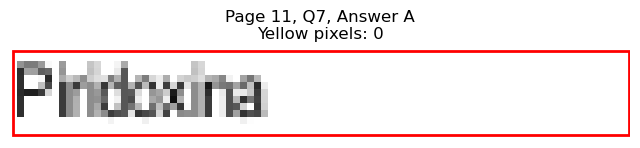

Page 11, Q7 - B: Detected box: x0=71.3, y0=543.4, x1=111.3, y1=555.5
Page 11, Q7, B: Yellow pixels: 327
Page 11, Q7, B: Total non-white pixels: 494
Page 11, Q7, B: Yellow percentage: 66.2%


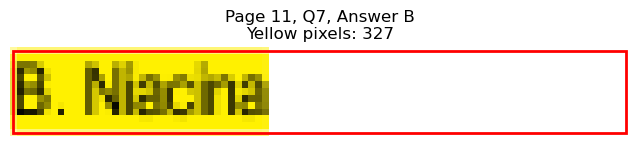

Page 11, Q7 - C: Detected box: x0=71.3, y0=555.4, x1=124.0, y1=567.5
Page 11, Q7, C: Yellow pixels: 37
Page 11, Q7, C: Total non-white pixels: 291
Page 11, Q7, C: Yellow percentage: 12.7%


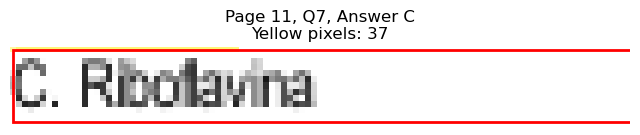

Page 11, Q7 - D: Detected box: x0=322.9, y0=531.4, x1=399.6, y1=543.5
Page 11, Q7, D: Yellow pixels: 0
Page 11, Q7, D: Total non-white pixels: 385
Page 11, Q7, D: Yellow percentage: 0.0%


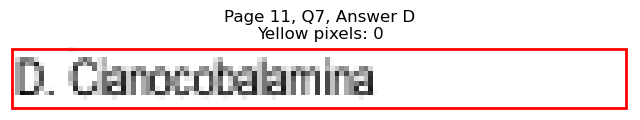

Page 11, Q7 - E: Detected box: x0=322.9, y0=543.4, x1=365.0, y1=555.5
Page 11, Q7, E: Yellow pixels: 0
Page 11, Q7, E: Total non-white pixels: 203
Page 11, Q7, E: Yellow percentage: 0.0%


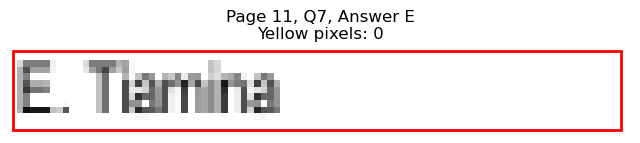


Page 11, Q7 - Selected Answer: B (based on yellow pixel count)




Page 11, Q8 - A: Detected box: x0=82.6, y0=591.5, x1=196.1, y1=603.5
Page 11, Q8, A: Yellow pixels: 1485
Page 11, Q8, A: Total non-white pixels: 2145
Page 11, Q8, A: Yellow percentage: 69.2%


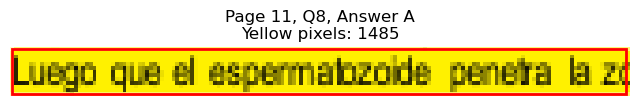

Page 11, Q8 - B: Detected box: x0=71.3, y0=615.5, x1=263.4, y1=627.5
Page 11, Q8, B: Yellow pixels: 30
Page 11, Q8, B: Total non-white pixels: 954
Page 11, Q8, B: Yellow percentage: 3.1%


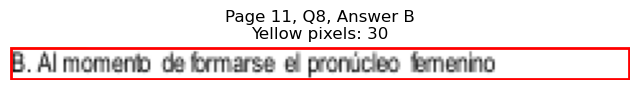

Page 11, Q8 - C: Detected box: x0=71.3, y0=627.5, x1=260.5, y1=639.6
Page 11, Q8, C: Yellow pixels: 0
Page 11, Q8, C: Total non-white pixels: 907
Page 11, Q8, C: Yellow percentage: 0.0%


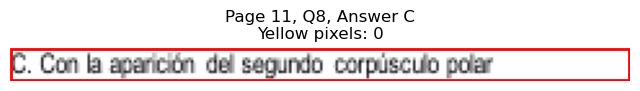

Page 11, Q8 - D: Detected box: x0=322.9, y0=591.5, x1=525.5, y1=603.5
Page 11, Q8, D: Yellow pixels: 0
Page 11, Q8, D: Total non-white pixels: 972
Page 11, Q8, D: Yellow percentage: 0.0%


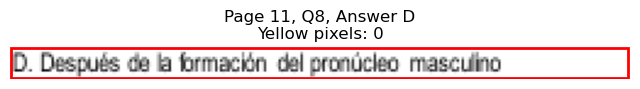

Page 11, Q8 - E: Detected box: x0=322.9, y0=603.5, x1=495.6, y1=615.5
Page 11, Q8, E: Yellow pixels: 0
Page 11, Q8, E: Total non-white pixels: 839
Page 11, Q8, E: Yellow percentage: 0.0%


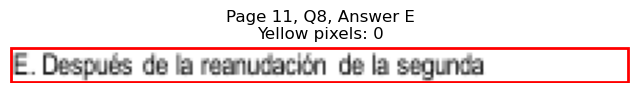


Page 11, Q8 - Selected Answer: A (based on yellow pixel count)




Page 11, Q9 - A: Detected box: x0=150.1, y0=676.3, x1=236.5, y1=688.3
Page 11, Q9, A: Yellow pixels: 0
Page 11, Q9, A: Total non-white pixels: 434
Page 11, Q9, A: Yellow percentage: 0.0%


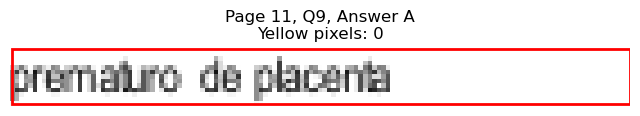

Page 11, Q9 - B: Detected box: x0=71.3, y0=688.3, x1=128.5, y1=700.3
Page 11, Q9, B: Yellow pixels: 0
Page 11, Q9, B: Total non-white pixels: 277
Page 11, Q9, B: Yellow percentage: 0.0%


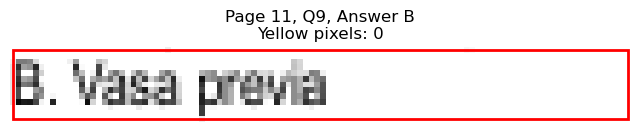

Page 11, Q9 - C: Detected box: x0=71.3, y0=700.3, x1=145.7, y1=712.3
Page 11, Q9, C: Yellow pixels: 0
Page 11, Q9, C: Total non-white pixels: 347
Page 11, Q9, C: Yellow percentage: 0.0%


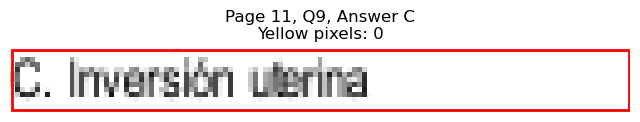

Page 11, Q9 - D: Detected box: x0=322.9, y0=676.3, x1=393.5, y1=688.3
Page 11, Q9, D: Yellow pixels: 0
Page 11, Q9, D: Total non-white pixels: 349
Page 11, Q9, D: Yellow percentage: 0.0%


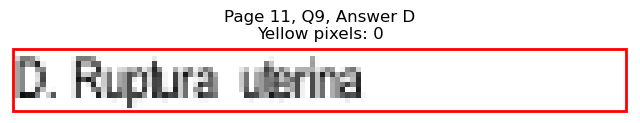

Page 11, Q9 - E: Detected box: x0=322.9, y0=688.3, x1=415.4, y1=700.3
Page 11, Q9, E: Yellow pixels: 706
Page 11, Q9, E: Total non-white pixels: 1196
Page 11, Q9, E: Yellow percentage: 59.0%


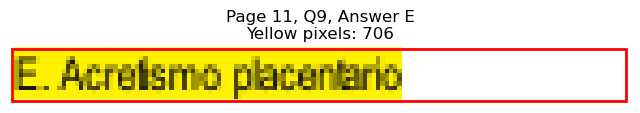


Page 11, Q9 - Selected Answer: E (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Pre-escolar de 4 años, desde hace una semana p...
1   Mujer obesa de 35 años, ingresa por vómitos bi...
2   Paciente de 65 años, diagnosticado de fibrilac...
3          ¿Cuál es una señal de alarma en el Dengue?
4   ¿Qué tipo de shock puede originar el taponamie...
..                                                ...
95  Mujer de 27 años, acude a la emergencia por pr...
96  Mujer de 40 años, que presenta un nódulo tiroi...
97  ¿Cuál es la deficiencia vitamínica que produce...
98  En el proceso de fecundación. ¿Cuándo se induc...
99  Multigesta de 36 semanas, G5 P2022, asintomáti...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                                       Rubéola   
1                       Cetaoacidosis diabética   
2                 Cuantificación de fibrinógeno   
3            Dolor abdominal intenso y continuo   
4                                   Neurogénico   
..                                          ...   
95                                      Potasio   
96                         Gammagrafía tiroidea   
97                                   Piridoxina   
98  Luego que el espermatozoide penetra la zona   
99        Desprendimiento prematuro de placenta   

                                        option_B  \
0                                       Kawasaki   
1                             Pancreatitis aguda   
2                            Tiempo de reptilase   
3                                  Trombocitosis   
4                                   Hipovolémico   
..                                           ...   
95                                      Magnesio   
96         Biopsia por aspiración con aguja fina   
97                                       Niacina   
98  Al momento de formarse el pronúcleo femenino   
99                                   Vasa previa   

                                         option_C  \
0                        Mononucleosis infecciosa   
1                        Intoxicación alimentaria   
2       Tiempo de tromboplastina parcial activado   
3                            Náuseas persistentes   
4                                    Distributivo   
..                                            ...   
95                                          Sodio   
96                           Resección quirúrgica   
97                                    Riboflavina   
98  Con la aparición del segundo corpúsculo polar   
99                              Inversión uterina   

                                           option_D  \
0                                       Escarlatina   
1                                      Estado mixto   
2                                Tiempo de trombina   
3                                          Poliuria   
4                                       Obstructivo   
..                                              ...   
95                                            Cloro   
96                               Biopsia del nódulo   
97                                  Cianocobalamina   
98  Después de la formación del pronúcleo masculino   
99                                  Ruptura uterina   

                                   option_E  
0                        Eritema infeccioso  
1                       Estado hiperosmolar  
2               Tiempo de protrombina (INR)  
3                                    Fiebre  
4                              Cardiogénico  
..                                      ...  
95                                  Fósforo  
96                            Dosaje de TSH  
97                                  Tiamina  
98  Después de la reanudación de la segunda  
99                    Acretismo placentario  

[100 rows x 5 columns]

In [9]:
correct_answers_df

correct_answer
0               C
1               D
2               E
3               A
4               D
..            ...
95              A
96              B
97              B
98              A
99              E

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "option_E", "correct_answer"]
total_df

questions  \
0   Pre-escolar de 4 años, desde hace una semana p...   
1   Mujer obesa de 35 años, ingresa por vómitos bi...   
2   Paciente de 65 años, diagnosticado de fibrilac...   
3          ¿Cuál es una señal de alarma en el Dengue?   
4   ¿Qué tipo de shock puede originar el taponamie...   
..                                                ...   
95  Mujer de 27 años, acude a la emergencia por pr...   
96  Mujer de 40 años, que presenta un nódulo tiroi...   
97  ¿Cuál es la deficiencia vitamínica que produce...   
98  En el proceso de fecundación. ¿Cuándo se induc...   
99  Multigesta de 36 semanas, G5 P2022, asintomáti...   

                                       option_A  \
0                                       Rubéola   
1                       Cetaoacidosis diabética   
2                 Cuantificación de fibrinógeno   
3            Dolor abdominal intenso y continuo   
4                                   Neurogénico   
..                                          ...   
95                                      Potasio   
96                         Gammagrafía tiroidea   
97                                   Piridoxina   
98  Luego que el espermatozoide penetra la zona   
99        Desprendimiento prematuro de placenta   

                                        option_B  \
0                                       Kawasaki   
1                             Pancreatitis aguda   
2                            Tiempo de reptilase   
3                                  Trombocitosis   
4                                   Hipovolémico   
..                                           ...   
95                                      Magnesio   
96         Biopsia por aspiración con aguja fina   
97                                       Niacina   
98  Al momento de formarse el pronúcleo femenino   
99                                   Vasa previa   

                                         option_C  \
0                        Mononucleosis infecciosa   
1                        Intoxicación alimentaria   
2       Tiempo de tromboplastina parcial activado   
3                            Náuseas persistentes   
4                                    Distributivo   
..                                            ...   
95                                          Sodio   
96                           Resección quirúrgica   
97                                    Riboflavina   
98  Con la aparición del segundo corpúsculo polar   
99                              Inversión uterina   

                                           option_D  \
0                                       Escarlatina   
1                                      Estado mixto   
2                                Tiempo de trombina   
3                                          Poliuria   
4                                       Obstructivo   
..                                              ...   
95                                            Cloro   
96                               Biopsia del nódulo   
97                                  Cianocobalamina   
98  Después de la formación del pronúcleo masculino   
99                                  Ruptura uterina   

                                   option_E correct_answer  
0                        Eritema infeccioso              C  
1                       Estado hiperosmolar              D  
2               Tiempo de protrombina (INR)              E  
3                                    Fiebre              A  
4                              Cardiogénico              D  
..                                      ...            ...  
95                                  Fósforo              A  
96                            Dosaje de TSH              B  
97                                  Tiamina              B  
98  Después de la reanudación de la segunda              A  
99                    Acretismo placentario              E  

[100 rows x 7 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2018/PRUEBA B.csv
